# Utils

In [1]:
import json
import os, json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import gzip, pickle
from typing import Optional

## 경로 설정

In [32]:
# Dataset
ITEM_ATTR_CSV = os.path.join("/home/parkdw00/Codes/data/books/books_llmrec_format", "item_attribute.csv")
DATA_BASE_DIR = "/home/parkdw00/Codes/A-LLMRec/data/books"
U_ITEM_PATH   = f"/home/parkdw00/Codes/data/books/5core/item_meta_2017_kcore5_user_item.json"
META_GZ_PATH  = f"{DATA_BASE_DIR}/books_text_name_dict.json.gz"
PARTS = 5

test_path = os.path.join(DATA_BASE_DIR, "books_label.txt")
train_path = os.path.join(DATA_BASE_DIR, "books_train_raw.txt")


# ######################### A-LLMRec #########################
BASE_DIR = f"/home/parkdw00/Codes/A-LLMRec/books_results"
PRED_P1 = f"{BASE_DIR}/predict_label_part1.json"
BASE_DIR = f"/home/parkdw00/Codes/data/books/A-LLMRec_format/A-LLMRec_results"
PRED_P5 = f"{BASE_DIR}/predict_label_part5.json"


######################## LLMRec #########################
# BASE_DIR = "/home/parkdw00/Codes/data/books/books_llmrec_format"
# PRED_P1    = f"{BASE_DIR}/predict_label_part1.json"
# PRED_P5    = f"{BASE_DIR}/predict_label_part5.json"


# ###################### Augmentation #######################
# BASE_DIR = f"/home/parkdw00/Codes/Augmentation/data/books"
# PRED_P1    = f"{BASE_DIR}/predict_label_part1.json"
# PRED_P5    = f"{BASE_DIR}/predict_label_part5.json"


# ###################### Traditional CF ######################
# model = "LightGCN"  # "MF-BPR" or "LightGCN"
# BASE_DIR = f"/home/parkdw00/Codes/data/books/traditionalCF"
# PRED_P1    = f"{BASE_DIR}/predict_label_part1.json"
# PRED_P5    = f"{BASE_DIR}/predict_label_part5.json"


with open(PRED_P5) as f:
    pred_dict = json.load(f)
print(pred_dict["0"][:30])  # user 0의 상위 10개 예측 아이템 ID


actual = sum(len(v) for v in pred_dict.values())
print("actual predict_label interactions:", actual)

[15005, 2626, 12287, 7727, 2236, 166, 1252, 18463, 4022, 226, 15994, 17751, 2661, 8234, 18455, 1358, 4548, 20191, 19217, 5086, 4532, 3716, 4851, 6418, 16917, 1322, 14471, 39, 10512, 78]
actual predict_label interactions: 353411


In [33]:

train_data = {}
with open(train_path, "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        u_str, i_str = line.split()
        u = str(u_str)         # 키는 문자열로
        i = int(i_str)         # 아이템은 정수로 (혹은 문자열로 둘 수도 있음)

        if u not in train_data:
            train_data[u] = []
        train_data[u].append(i)

ground_truth = {}
with open(test_path, "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        u_str, i_str, _ = line.split()
        u = str(u_str)
        i = int(i_str)
        # ground truth가 여러 개면 리스트에 append, 한 개만 있으면 덮어쓰거나 첫 개만 쓰면 됨
        if u not in ground_truth:
            ground_truth[u] = []
        ground_truth[u].append(i)

expected = sum(len(v) for v in ground_truth.values())
print("expected ground_truth interactions:", expected)

# ground truth에서 가장 긴 기록을 가진 사용자 검색, 해당 사용자의 기록 길이 확인
max_len_user = max(ground_truth.items(), key=lambda x: len(x[1]))
print(f"User with the longest ground truth interaction: {max_len_user[0]}, Length: {len(max_len_user[1])}")

# 공통 사용자
common_users = set(train_data.keys()) & set(ground_truth.keys())
print(len(train_data.keys()))
print(len(ground_truth.keys()))
print(len(common_users))


expected ground_truth interactions: 440917
User with the longest ground truth interaction: 1687, Length: 528
32559
31445
31445


### Multi-hot-vector

X shape: (32559, 20529) nnz: 471229
X_svd shape: (32559, 100) explained_var_ratio_sum: 0.13843718

Users per cluster (%)
Cluster 0: 1230 users (3.78%)
Cluster 1: 31329 users (96.22%)


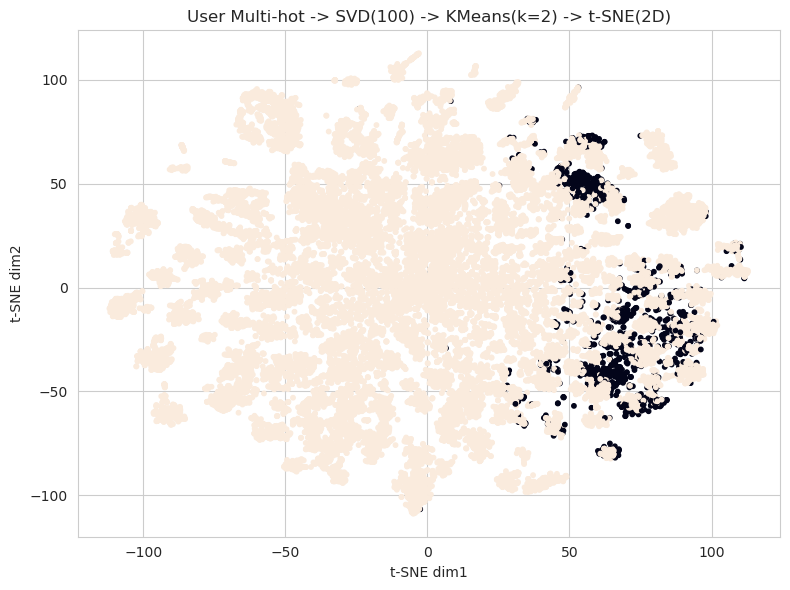

In [13]:
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter

# -----------------------------
# 1) train_data -> multi-hot (sparse CSR)
# -----------------------------
# train_data: { "user_id(str)": [item_id(int), ...], ... }

users = list(train_data.keys())

# item universe(전체 아이템 id) 수집
all_items = set()
for u in users:
    all_items.update(train_data[u])#[-10:])

# item_id가 0..N-1로 연속이 아닐 수 있으니 re-index
item_list = sorted(all_items)
item2col = {item: idx for idx, item in enumerate(item_list)}

n_users = len(users)
n_items = len(item_list)

# CSR 만들기: (row=user, col=item) 위치에 1
rows = []
cols = []
data = []
for r, u in enumerate(users):
    # 중복 interaction은 1로 처리(멀티핫)
    seen_list = train_data[u]#[-10:]
    seen = set(seen_list)
    for item in seen:
        rows.append(r)
        cols.append(item2col[item])
        data.append(1)

X = csr_matrix((data, (rows, cols)), shape=(n_users, n_items), dtype=np.float32)
print("X shape:", X.shape, "nnz:", X.nnz)

# -----------------------------
# 2) 고차원 희소벡터 -> 저차원 임베딩 (SVD)
# -----------------------------
# KMeans는 고차원 희소에서 바로 돌려도 되지만,
# 보통 SVD로 50~200 차원 정도로 줄이면 훨씬 안정적임.
svd_dim = min(100, n_items - 1) if n_items > 1 else 1
svd = TruncatedSVD(n_components=svd_dim, random_state=42)
X_svd = svd.fit_transform(X)
print("X_svd shape:", X_svd.shape, "explained_var_ratio_sum:", svd.explained_variance_ratio_.sum())

# -----------------------------
# 3) K-means
# -----------------------------
k = 2  # 원하는 클러스터 수로 바꿔
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
labels = kmeans.fit_predict(X_svd)

# -----------------------------
# cluster별 사용자 수 출력
# -----------------------------
cluster_cnt = Counter(labels)

print("\nUsers per cluster (%)")
for c in sorted(cluster_cnt.keys()):
    ratio = cluster_cnt[c] / len(labels) * 100
    print(f"Cluster {c}: {cluster_cnt[c]} users ({ratio:.2f}%)")

# -----------------------------
# 4) 2D 시각화 좌표 만들기 (t-SNE)
# -----------------------------
# 사용자 수가 아주 많으면(수만 이상) t-SNE는 느릴 수 있음 -> 아래 subsample 옵션 사용 권장
use_subsample = False
max_points = 5000

if use_subsample and n_users > max_points:
    rng = np.random.RandomState(42)
    idx = rng.choice(n_users, size=max_points, replace=False)
    X_vis_in = X_svd[idx]
    labels_vis = labels[idx]
else:
    X_vis_in = X_svd
    labels_vis = labels

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=42,
)
Z = tsne.fit_transform(X_vis_in)

# -----------------------------
# 5) Plot
# -----------------------------
plt.figure(figsize=(8, 6))
plt.scatter(Z[:, 0], Z[:, 1], c=labels_vis, s=10)
plt.title(f"User Multi-hot -> SVD({svd_dim}) -> KMeans(k={k}) -> t-SNE(2D)")
plt.xlabel("t-SNE dim1")
plt.ylabel("t-SNE dim2")
plt.tight_layout()
plt.show()


# RQ1
추천 파이프라인 속에서 LLM이 생성한 데이터의 편향/환각 현상 분석

포함: LLMRec, Augmentation

## LLMRec

### Bias

✅ 데이터 로드 완료. 총 25878개 아이템
🔄 카테고리 파싱 진행 중...
🔍 고유 카테고리 개수 (Set): 334
📊 누적 카테고리 태그 수 (List): 76174
📊 그래프 저장 완료: /home/parkdw00/Codes/data/books/books_llmrec_format/poster/Real_Category_Distribution_Parsed.png


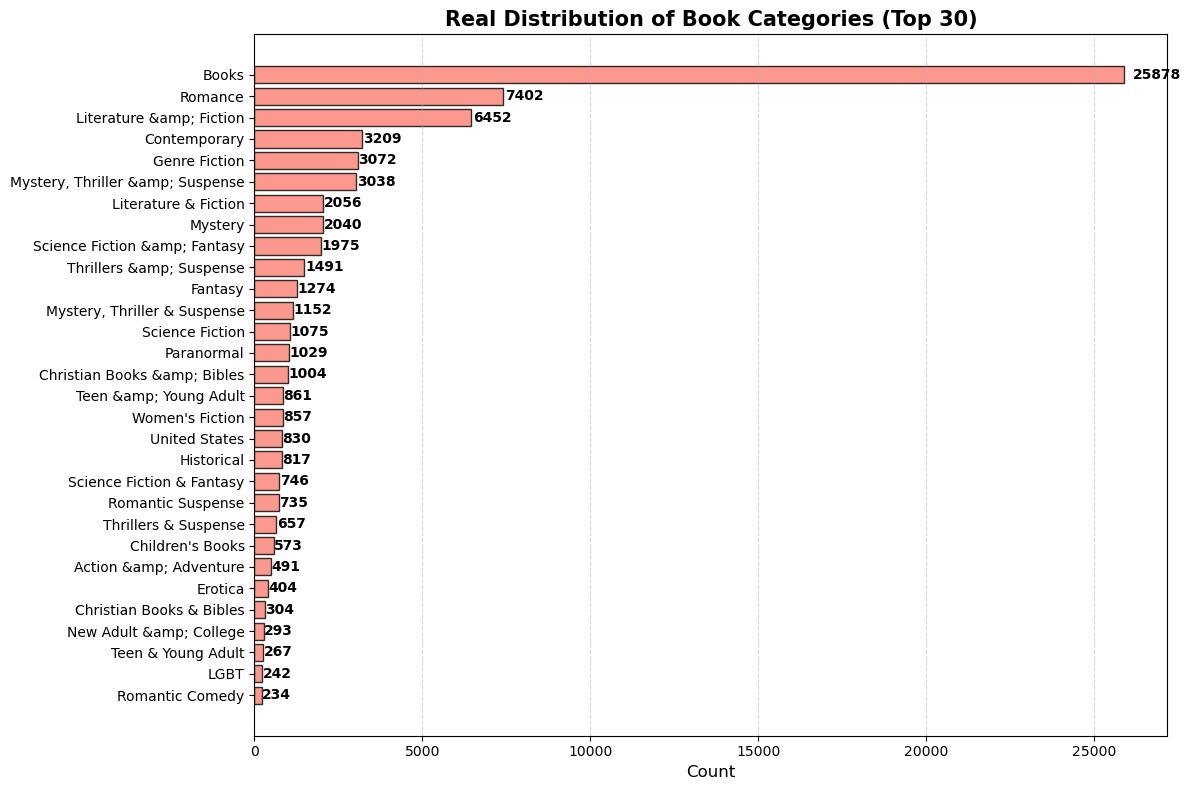

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import os
from collections import Counter

# ✅ 경로 설정
base_dir = "/home/parkdw00/Codes/data/books/books_llmrec_format/"
save_dir = "/home/parkdw00/Codes/data/books/books_llmrec_format/poster/"

# ✅ 1. 데이터 로드 (요청하신 컬럼명 적용)
# header=0을 쓸지 None을 쓸지는 파일에 헤더가 포함되어 있는지에 따라 다릅니다.
# 보통 names를 지정하면 header=0 (첫줄 무시) 혹은 header=None (첫줄부터 데이터)를 상황에 맞춰 써야 합니다.
# 여기서는 기존 파일에 헤더가 있다면 header=0을 추가해야 합니다.
if os.path.exists(ITEM_ATTR_CSV):
    item_attr_df = pd.read_csv(ITEM_ATTR_CSV, names=["id", "brand", "title", "category"], header=0) 
    print(f"✅ 데이터 로드 완료. 총 {len(item_attr_df)}개 아이템")
else:
    print(f"❌ 파일을 찾을 수 없습니다: {ITEM_ATTR_CSV}")
    exit()

# ✅ 2. 카테고리 파싱 함수 정의
def parse_categories(cat_raw):
    """
    문자열 형태의 리스트("['A', 'B']")나 단순 문자열("A")을 실제 리스트로 변환
    """
    if pd.isna(cat_raw):
        return []
    
    cat_str = str(cat_raw).strip()
    
    try:
        # 1) "['Fiction', 'History']" 형태 파싱
        if cat_str.startswith("[") and cat_str.endswith("]"):
            parsed = ast.literal_eval(cat_str)
            return [str(c).strip() for c in parsed if c]
        
        # 2) "Fiction, History" 쉼표 구분 형태
        elif "," in cat_str:
            return [c.strip() for c in cat_str.split(",") if c.strip()]
            
        # 3) 단일 문자열
        else:
            return [cat_str]
    except:
        return [cat_str]

# ✅ 3. 카테고리 집합(Set) 및 리스트(List) 생성
all_categories = set()      # 중복 없는 전체 카테고리 목록 (요청하신 부분)
all_categories_list = []    # 빈도수 계산을 위한 전체 리스트 (시각화용)

print("🔄 카테고리 파싱 진행 중...")
for item_id in item_attr_df.index:
    cat_raw = item_attr_df.loc[item_id, "category"]
    cats = parse_categories(cat_raw)
    
    all_categories.update(cats)       # Set 업데이트 (Unique)
    all_categories_list.extend(cats)  # List 확장 (Count용)

print(f"🔍 고유 카테고리 개수 (Set): {len(all_categories)}")
print(f"📊 누적 카테고리 태그 수 (List): {len(all_categories_list)}")

# ✅ 4. 실제 분포 시각화 (Top K)
def plot_real_distribution(data_list, title, top_k=20):
    if not data_list:
        print("데이터가 없어 시각화할 수 없습니다.")
        return

    # 빈도 계산
    counter = Counter(data_list)
    
    # 데이터프레임 변환
    stat_df = pd.DataFrame.from_dict(counter, orient='index', columns=['Count']).reset_index()
    stat_df.rename(columns={'index': 'Category'}, inplace=True)
    
    # 상위 Top K 정렬
    df_topk = stat_df.sort_values(by='Count', ascending=False).head(top_k).reset_index(drop=True)

    # 그래프 그리기 (가로 막대)
    plt.figure(figsize=(12, 8))
    bars = plt.barh(df_topk['Category'][::-1], df_topk['Count'][::-1], color='salmon', edgecolor='black', alpha=0.8)

    # 수치 표시
    for bar in bars:
        width = bar.get_width()
        plt.text(width + (width * 0.01), bar.get_y() + bar.get_height()/2, 
                 f'{int(width)}', ha='left', va='center', fontsize=10, fontweight='bold')

    plt.title(f"Real Distribution of {title} (Top {top_k})", fontsize=15, fontweight='bold')
    plt.xlabel("Count", fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()

    # 저장
    os.makedirs(save_dir, exist_ok=True)
    filename = "Real_Category_Distribution_Parsed.png"
    plt.savefig(os.path.join(save_dir, filename))
    print(f"📊 그래프 저장 완료: {os.path.join(save_dir, filename)}")
    plt.show()

# 실행
plot_real_distribution(all_categories_list, "Book Categories", top_k=30)

✅ 파일 로드 성공: /home/parkdw00/Codes/data/books/books_llmrec_format/augmented_user_profiling_dict_part5_step0_try0 (총 32559명)

========== Gender: Others (not Male/Female) ==========
['non-binary', 'non-binary', 'non-binary']
Count (Others): 3
total_users: 32559
count_in_plot (gender labels): 32559

========== 시각화 시작 ==========
📊 저장 완료: Predicted_age.png. /home/parkdw00/Codes/data/books/books_llmrec_format/poster/Predicted_age.png
📊 저장 완료: Predicted_gender.png. /home/parkdw00/Codes/data/books/books_llmrec_format/poster/Predicted_gender.png
📊 저장 완료: Predicted_country.png. /home/parkdw00/Codes/data/books/books_llmrec_format/poster/Predicted_country.png
📊 저장 완료: Predicted_language.png. /home/parkdw00/Codes/data/books/books_llmrec_format/poster/Predicted_language.png
📊 저장 완료: Predicted_liked_category.png. /home/parkdw00/Codes/data/books/books_llmrec_format/poster/Predicted_liked_category.png
📊 저장 완료: Predicted_disliked_category.png. /home/parkdw00/Codes/data/books/books_llmrec_format/poster/Pre

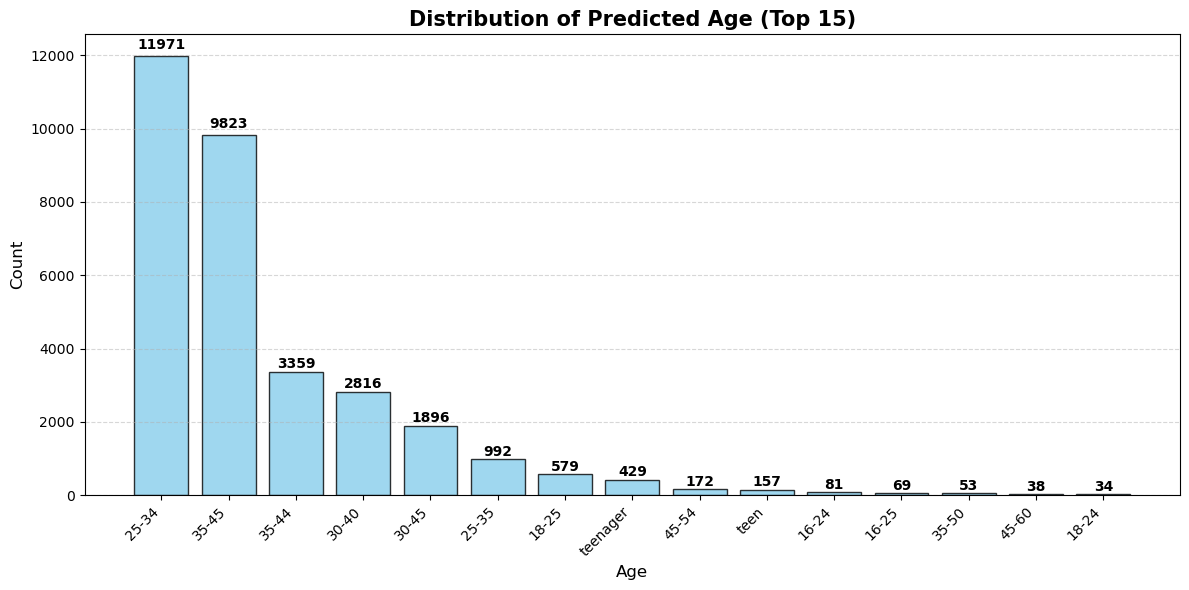

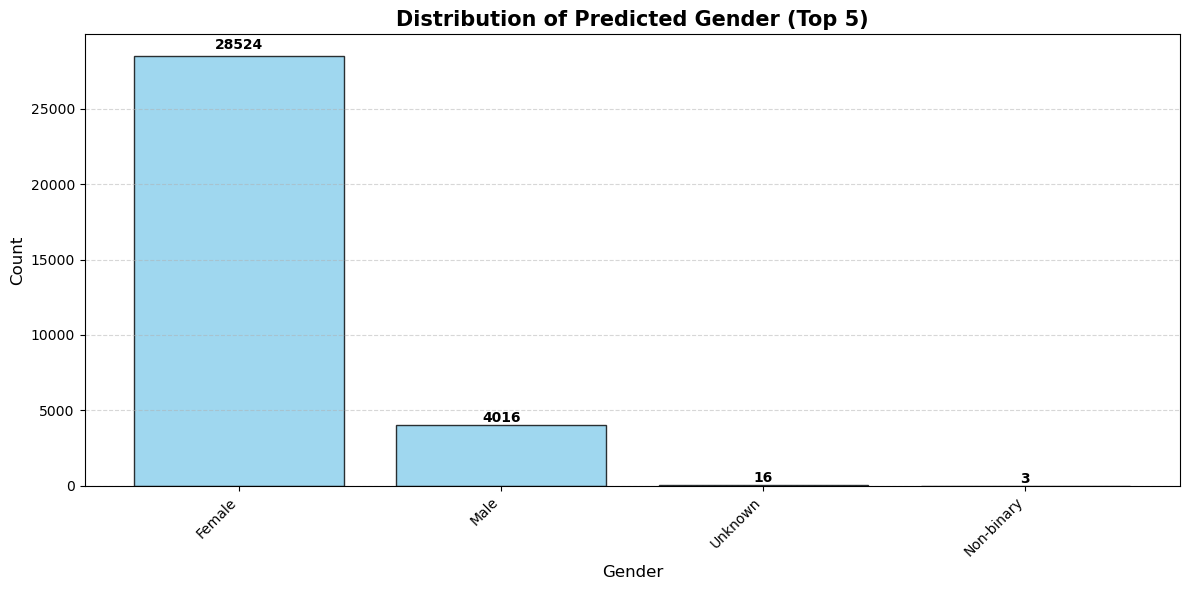

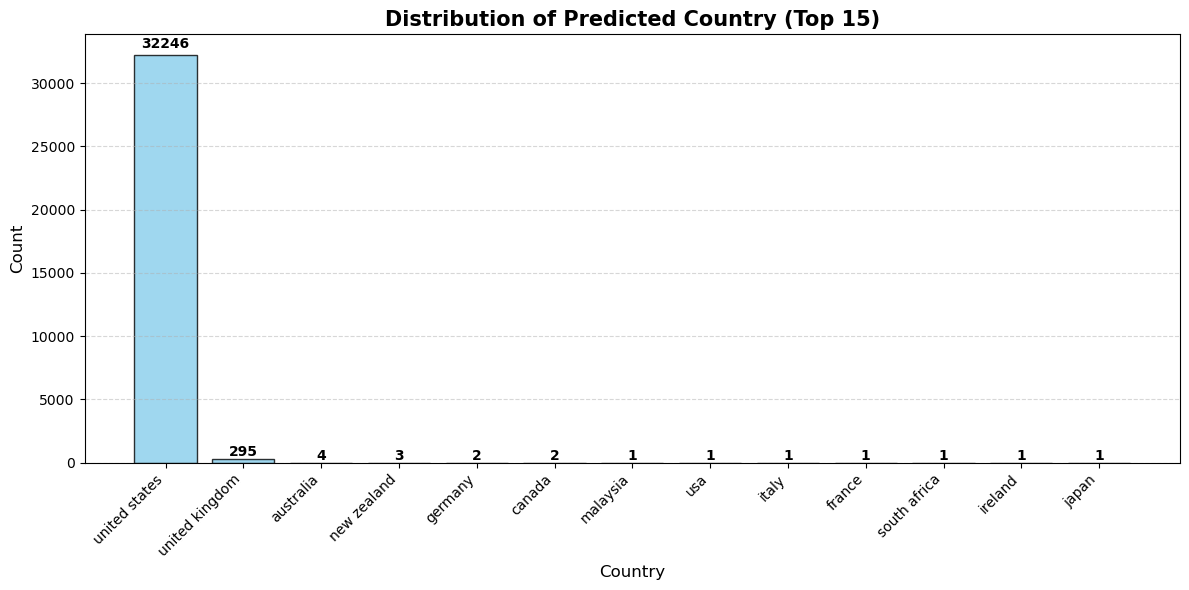

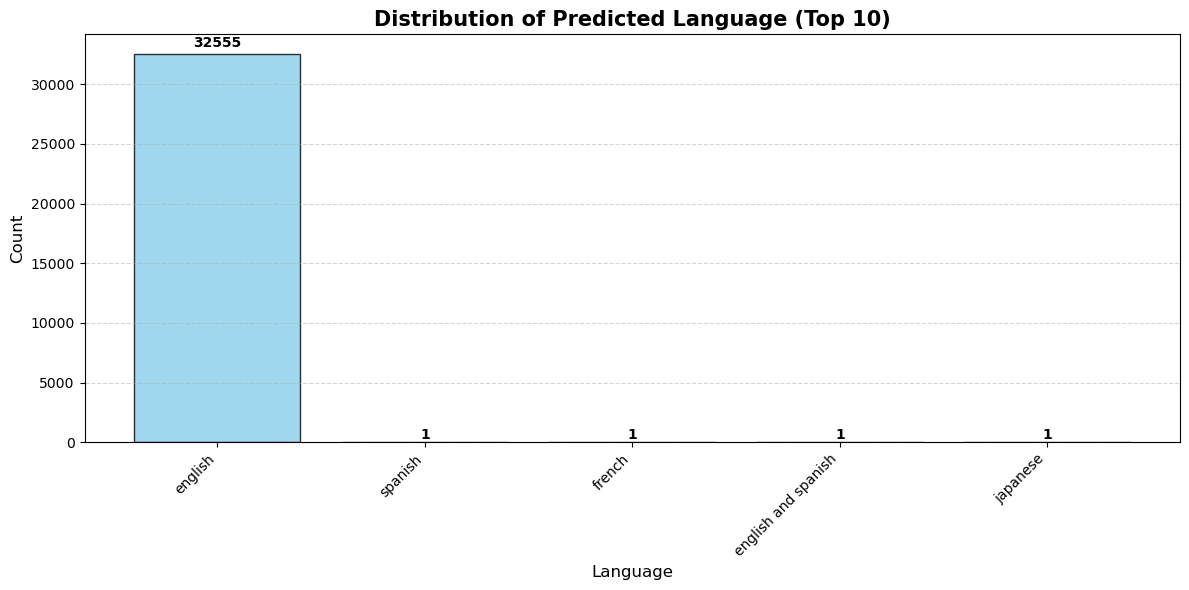

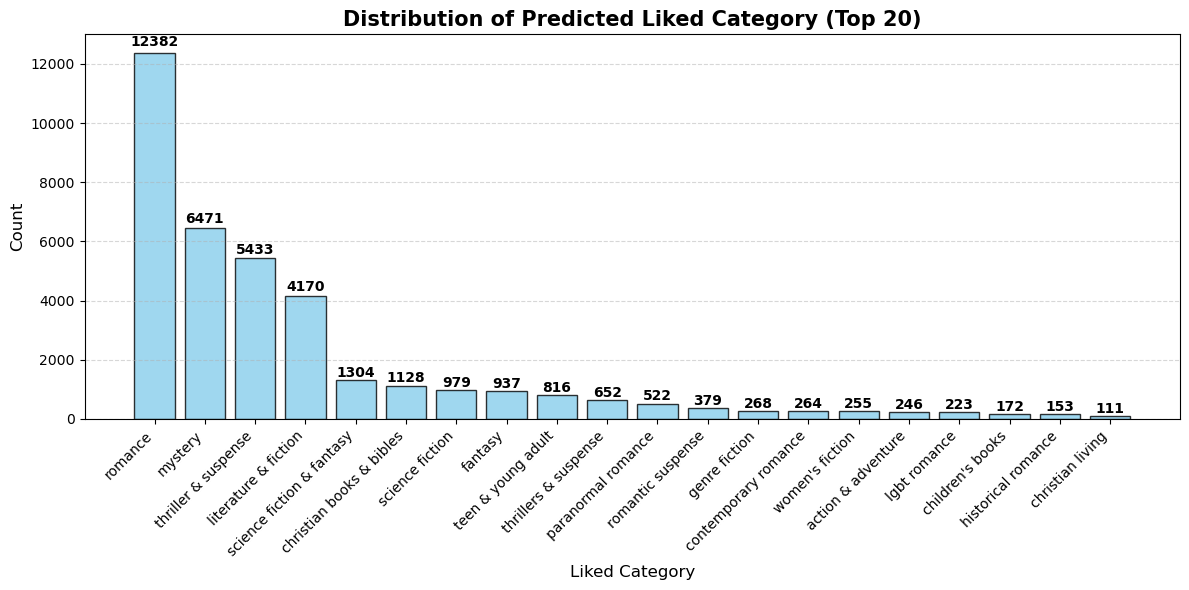

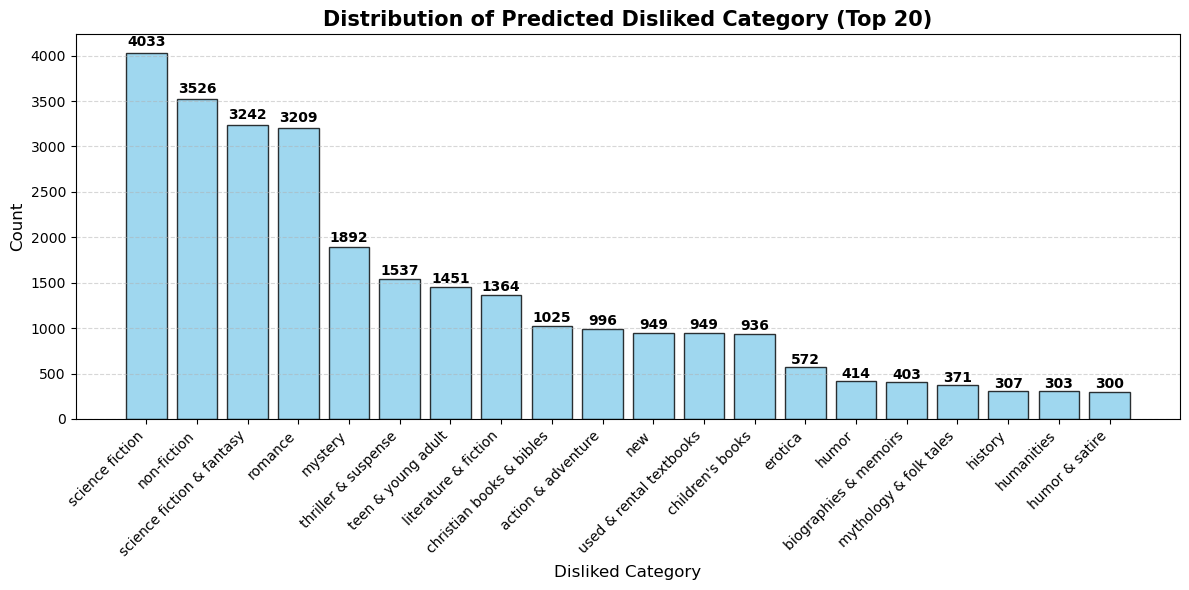

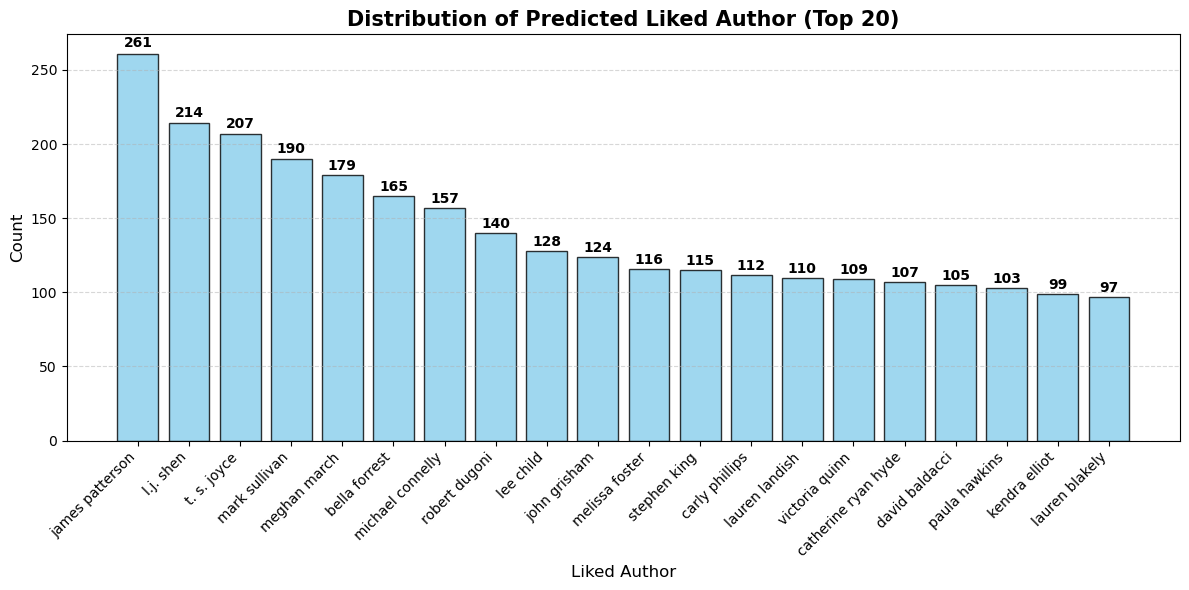

In [13]:
import matplotlib.pyplot as plt
import pickle
import json
import ast
import re
from collections import Counter
import pandas as pd
import os

# ✅ 파일 경로 설정
file_path = "/home/parkdw00/Codes/data/books/books_llmrec_format/augmented_user_profiling_dict_part5_step0_try0"
save_dir  = "/home/parkdw00/Codes/data/books/books_llmrec_format/poster/"

# ✅ 시각화할 대상 키(Key) 정의
target_keys = [
    'age', 'gender',
    'liked category', 'disliked category',
    'liked author', 'country', 'language'
]

# 데이터를 저장할 딕셔너리 초기화
data_storage = {key: [] for key in target_keys}

# ✅ gender에서 남/여로 분류되지 않는 값 저장 리스트
other_gender_list = []

# ✅ 데이터 로드
if os.path.exists(file_path):
    with open(file_path, "rb") as f:
        augmented_dict = pickle.load(f)
    print(f"✅ 파일 로드 성공: {file_path} (총 {len(augmented_dict)}명)")
else:
    print(f"❌ 파일을 찾을 수 없습니다: {file_path}")
    augmented_dict = {}

# -------------------------
# Helpers
# -------------------------
def normalize_gender(val: str):
    """
    gender 값을 최대한 유하게 정규화해서
    'm', 'f', 'nb', 'other' 중 하나로 매핑 (또는 None)
    """
    if val is None:
        return None

    s = str(val).strip().lower()
    s = re.sub(r"\s+", " ", s)

    if s in {"", "unknown", "none", "n/a", "na", "null", "nil", "unspecified", "?"}:
        return None

    if re.fullmatch(r"(m|male|man|boy|masc|masculine)", s):
        return "m"
    if re.fullmatch(r"(f|female|woman|girl|fem|feminine)", s):
        return "f"

    if any(x in s for x in ["prefer not", "rather not", "no answer", "not say", "private"]):
        return None

    if any(x in s for x in ["nonbinary", "non-binary", "nb", "genderqueer", "gender fluid", "genderfluid", "agender"]):
        return "nb"

    if re.search(r"\b(m|male)\b", s) and re.search(r"\b(f|female)\b", s):
        return "other"

    if any(x in s for x in ["남", "남자", "남성"]):
        return "m"
    if any(x in s for x in ["여", "여자", "여성"]):
        return "f"

    if re.fullmatch(r"m\.", s):
        return "m"
    if re.fullmatch(r"f\.", s):
        return "f"

    return "other"


def clean_and_parse(profile_text):
    if profile_text is None:
        return None

    s = str(profile_text).strip()

    # 1) 코드펜스에서 {...}만 뽑기
    m = re.search(r"```(?:json)?\s*(\{.*\})\s*```", s, flags=re.DOTALL | re.IGNORECASE)
    if m:
        s = m.group(1)
    else:
        s = s.replace("```json", "").replace("```", "").strip()

    s = s.replace("\r", "").strip()

    # 2) Python dict literal이면 ast 먼저
    if re.search(r"\{\s*'", s):
        try:
            return ast.literal_eval(s)
        except Exception:
            pass

    # 3) JSON용 불법 escape만 최소 수정
    s_json = s.replace("\\'", "'")

    # 4) JSON 시도
    try:
        return json.loads(s_json)
    except Exception:
        pass

    # 5) 마지막 보험: ast 재시도
    try:
        return ast.literal_eval(s)
    except Exception:
        return None


def split_authors(val):
    results = []
    items = val if isinstance(val, list) else [val]

    for item in items:
        if not item:
            continue
        s = str(item).strip().lower()

        # 구분자 통일 (쉼표 제외)
        s = re.sub(r"\s*(?:&|;|\||/)\s*", " , ", s)
        s = re.sub(r"\s+(?:and|with)\s+", " , ", s)

        looks_like_last_first = bool(re.search(r"^[a-z\.\-]+,\s*[a-z]", s))
        if looks_like_last_first:
            parts = [s.strip()]
        else:
            parts = [p.strip() for p in s.split(",") if p.strip()]

        results.extend(parts)

    return results


# -------------------------
# ✅ 메인 루프: 데이터 추출
# -------------------------
for user_id, profile_text in augmented_dict.items():
    profile = clean_and_parse(profile_text)

    if not profile:
        # 파싱 실패면 모든 키가 빠지므로 skip
        continue

    for key in target_keys:
        val = profile.get(key, None)

        # gender는 "무조건 1명당 1개"를 넣기 위해, 여기서 continue 하면 안 됨
        if key != "gender" and not val:
            continue

        if key == "liked author":
            if val:
                authors = split_authors(val)
                data_storage[key].extend(authors)
            continue

        if key == "gender":
            raw = "" if val is None else str(val).strip()
            raw_l = raw.lower()

            # 1) 남/여 정규화
            g = normalize_gender(raw)

            if g == "m":
                data_storage[key].append("Male")

            elif g == "f":
                data_storage[key].append("Female")

            elif g == "nb":
                # non-binary는 그대로 표기
                data_storage[key].append("Non-binary")
                other_gender_list.append(raw)

            else:
                # unknown / none / 기타
                if raw_l in {"", "unknown", "none", "n/a", "na", "null", "nil", "unspecified", "?"}:
                    data_storage[key].append("Unknown")
                else:
                    # 그 외 애매한 값은 원문 유지하고 싶으면 title-case로
                    label = raw.strip().title()
                    data_storage[key].append(label)
                    other_gender_list.append(raw)

            continue

        # ---- 기존 로직(성별 제외) ----
        if isinstance(val, list):
            cleaned_items = [str(item).strip().lower() for item in val if item]
            data_storage[key].extend(cleaned_items)

        elif isinstance(val, str):
            v = val.strip()
            if v.lower() in ['unknown', 'none', 'n/a', '']:
                continue

            if ',' in v:
                data_storage[key].extend([x.strip().lower() for x in v.split(',') if x.strip()])
            else:
                data_storage[key].append(v.lower())

# -------------------------
# ✅ gender 기타 값 출력 + 진단 출력
# -------------------------
print("\n========== Gender: Others (not Male/Female) ==========")
print(other_gender_list)
print(f"Count (Others): {len(other_gender_list)}")

total_users = len(augmented_dict)
print("total_users:", total_users)
print("count_in_plot (gender labels):", len(data_storage["gender"]))

# -------------------------
# ✅ 시각화 함수
# -------------------------
def plot_distribution(category_name, data_list, top_k=10):
    if not data_list:
        print(f"⚠️ {category_name} - 데이터가 없습니다.")
        return

    counter = Counter(data_list)
    df = pd.DataFrame.from_dict(counter, orient='index', columns=['Count']).reset_index()
    df.rename(columns={'index': 'Category'}, inplace=True)
    df_topk = df.sort_values(by='Count', ascending=False).head(top_k).reset_index(drop=True)

    plt.figure(figsize=(12, 6))
    bars = plt.bar(df_topk['Category'], df_topk['Count'], color='skyblue', edgecolor='black', alpha=0.8)

    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            yval + (yval * 0.01),
            int(yval),
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='bold'
        )

    plt.title(f"Distribution of Predicted {category_name.title()} (Top {top_k})", fontsize=15, fontweight='bold')
    plt.xlabel(category_name.title(), fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()

    os.makedirs(save_dir, exist_ok=True)
    filename = f"Predicted_{category_name.replace(' ', '_')}.png"
    save_path = os.path.join(save_dir, filename)
    plt.savefig(save_path)
    print(f"📊 저장 완료: {filename}. {save_path}")

# -------------------------
# ✅ 실행: 각 키별 시각화 수행
# -------------------------
print("\n========== 시각화 시작 ==========")

plot_distribution('age', data_storage['age'], top_k=15)
plot_distribution('gender', data_storage['gender'], top_k=5)
plot_distribution('country', data_storage['country'], top_k=15)
plot_distribution('language', data_storage['language'], top_k=10)

plot_distribution('liked category', data_storage['liked category'], top_k=20)
plot_distribution('disliked category', data_storage['disliked category'], top_k=20)
plot_distribution('liked author', data_storage['liked author'], top_k=20)


In [6]:
OUT_TXT = os.path.join(
    "/home/parkdw00/Codes/data/books/books_llmrec_format",
    "liked_author_by_user.txt"
)

with open(OUT_TXT, "w", encoding="utf-8") as f:
    for user_id, profile_text in augmented_dict.items():
        profile = clean_and_parse(profile_text)

        if not profile:
            continue

        val = profile.get("liked author", None)
        if not val:
            continue

        # author 분리
        authors = split_authors(val)

        if not authors:
            continue

        # 중복 제거 + 순서 유지
        seen = set()
        uniq_authors = []
        for a in authors:
            if a not in seen:
                seen.add(a)
                uniq_authors.append(a)

        # 한 줄로 저장
        line = f"{user_id}\t" + " | ".join(uniq_authors) + "\n"
        f.write(line)

print(f"✅ liked author txt 저장 완료: {OUT_TXT}")


✅ liked author txt 저장 완료: /home/parkdw00/Codes/data/books/books_llmrec_format/liked_author_by_user.txt


In [12]:
import os
import re
import json
import ast
import pickle
from collections import Counter
from typing import Dict, Any, Optional, List, Tuple

import pandas as pd
import matplotlib.pyplot as plt


# -----------------------------
# Configuration
# -----------------------------
file_path = "/home/parkdw00/Codes/data/books/books_llmrec_format/augmented_user_profiling_dict_part1_step0"
base_save_dir = "/home/parkdw00/Codes/data/books/books_llmrec_format/poster/Gender"

target_keys = [
    "age", "gender",
    "liked category", "disliked category",
    "liked author", "country", "language",
]


# -----------------------------
# Parsing / Normalization
# -----------------------------
def clean_and_parse(profile_text: str, model: str = "gpt-4o") -> Optional[Dict[str, Any]]:
    if not isinstance(profile_text, str):
        return None

    if model == "gpt-4o":
        cleaned = (
            profile_text.strip()
            .replace("'''", "")
            .replace("```json", "")
            .replace("```", "")
            .replace("\n", "")
            .replace("\r", "")
            .replace("children's", "childrens")
            .replace("Children\\'s", "childrens")
        )
    else:
        cleaned = profile_text.strip()

    try:
        cleaned_json = re.sub(r"(?<!\\)'", '"', cleaned)
        return json.loads(cleaned_json)
    except json.JSONDecodeError:
        try:
            return ast.literal_eval(cleaned)
        except Exception:
            return None

def normalize_gender(raw: Any) -> Optional[str]:
    if raw is None:
        return None

    if isinstance(raw, list) and len(raw) > 0:
        raw = raw[0]

    if not isinstance(raw, str):
        return None

    s = raw.strip().lower()
    if s in {"m", "male", "man", "boy", "masculine"}:
        return "m"
    if s in {"f", "female", "woman", "girl", "feminine"}:
        return "f"

    if len(s) >= 1:
        if s[0] == "m":
            return "m"
        if s[0] == "f":
            return "f"

    return None


GENRE_NORMALIZATION = {
    "thrillers & suspense": "thriller & suspense",
    "thriller and suspense": "thriller & suspense",
    "thrillers and suspense": "thriller & suspense",
}

def normalize_genre(s: str) -> str:
    s = s.strip().lower()
    return GENRE_NORMALIZATION.get(s, s)

def maybe_normalize_by_key(key: str, s: str) -> str:
    # 장르/카테고리 계열에만 적용 (원하면 키 추가 가능)
    if key in {"liked category", "disliked category"}:
        return normalize_genre(s)
    return s

def normalize_item_value(key: str, val: Any) -> List[str]:
    out: List[str] = []

    if val is None:
        return out

    def push(x: str):
        x = x.strip().lower()
        if not x or x in {"unknown", "none", "n/a"}:
            return
        x = maybe_normalize_by_key(key, x)
        out.append(x)

    if isinstance(val, list):
        for item in val:
            if item is None:
                continue
            push(str(item))
        return out

    if isinstance(val, str):
        s = val.strip()
        if not s:
            return out
        if s.lower() in {"unknown", "none", "n/a"}:
            return out

        if "," in s:
            for p in s.split(","):
                push(p)
            return out

        if key == "gender":
            push(s[0])   # m/f만 남기게 됨
        else:
            push(s)
        return out

    push(str(val))
    return out



# -----------------------------
# Plotting
# -----------------------------
def plot_distribution(
    key: str,
    data_list: List[str],
    save_dir: str,
    gender: str,
    n_users: int,
    top_k: int = 10,
):

    if not data_list:
        print(f"{key}: no data")
        return

    counter = Counter(data_list)
    df = (
        pd.DataFrame.from_dict(counter, orient="index", columns=["Count"])
        .reset_index()
        .rename(columns={"index": "Category"})
    )

    df_topk = df.sort_values(by="Count", ascending=False).head(top_k).reset_index(drop=True)

    os.makedirs(save_dir, exist_ok=True)

    plt.figure(figsize=(12, 6))
    bars = plt.bar(df_topk["Category"], df_topk["Count"], alpha=0.85, edgecolor="black")

    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval + (yval * 0.01),
            int(yval),
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    title = f"{gender} (N={n_users}) — {key.replace('_', ' ').title()} (Top {top_k})"
    plt.title(title, fontsize=15, fontweight="bold")

    plt.xlabel(key.replace('_', ' ').title(), fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()

    filename = f"Predicted_{key.replace(' ', '_')}.png"
    save_path = os.path.join(save_dir, filename)
    plt.savefig(save_path, dpi=200)
    plt.close()
    print(f"saved: {save_path}")



def get_topk_for_key(key: str) -> int:
    if key == "age":
        return 15
    if key == "gender":
        return 5
    if key == "country":
        return 15
    if key == "language":
        return 10
    if key in {"liked category", "disliked category", "liked author"}:
        return 20
    return 10


# -----------------------------
# Main
# -----------------------------
def main() -> None:
    if not os.path.exists(file_path):
        print(f"file not found: {file_path}")
        return

    with open(file_path, "rb") as f:
        augmented_dict = pickle.load(f)

    print(f"loaded: {file_path} (users: {len(augmented_dict)})")

    profiles_by_gender: Dict[str, List[Dict[str, Any]]] = {"m": [], "f": []}
    failed = 0
    unknown_gender = 0

    for user_id, profile_text in augmented_dict.items():
        profile = clean_and_parse(profile_text)
        if not profile:
            failed += 1
            continue

        g = normalize_gender(profile.get("gender"))
        if g not in {"m", "f"}:
            unknown_gender += 1
            continue

        profile["gender"] = g
        profiles_by_gender[g].append(profile)

    print(f"parsed_ok_male: {len(profiles_by_gender['m'])}")
    print(f"parsed_ok_female: {len(profiles_by_gender['f'])}")
    print(f"parse_failed: {failed}")
    print(f"unknown_gender_excluded: {unknown_gender}")

    save_dir_map = {
        "m": os.path.join(base_save_dir, "Male"),
        "f": os.path.join(base_save_dir, "Female"),
    }

    for g in ["m", "f"]:
        group_profiles = profiles_by_gender[g]
        save_dir = save_dir_map[g]

        gender_name = "Male" if g == "m" else "Female"
        n_users = len(group_profiles)

        data_storage = {k: [] for k in target_keys}        

        for profile in group_profiles:
            for key in target_keys:
                vals = normalize_item_value(key, profile.get(key))
                if vals:
                    data_storage[key].extend(vals)

        for key in target_keys:
            k = get_topk_for_key(key)
            plot_distribution(
                key=key,
                data_list=data_storage[key],
                save_dir=save_dir,
                gender=gender_name,
                n_users=n_users,
                top_k=k,
            )



if __name__ == "__main__":
    main()


loaded: /home/parkdw00/Codes/data/books/books_llmrec_format/augmented_user_profiling_dict_part1_step0 (users: 32559)
parsed_ok_male: 520
parsed_ok_female: 32033
parse_failed: 0
unknown_gender_excluded: 6
saved: /home/parkdw00/Codes/data/books/books_llmrec_format/poster/Gender/Male/Predicted_age.png
saved: /home/parkdw00/Codes/data/books/books_llmrec_format/poster/Gender/Male/Predicted_gender.png
saved: /home/parkdw00/Codes/data/books/books_llmrec_format/poster/Gender/Male/Predicted_liked_category.png
saved: /home/parkdw00/Codes/data/books/books_llmrec_format/poster/Gender/Male/Predicted_disliked_category.png
saved: /home/parkdw00/Codes/data/books/books_llmrec_format/poster/Gender/Male/Predicted_liked_author.png
saved: /home/parkdw00/Codes/data/books/books_llmrec_format/poster/Gender/Male/Predicted_country.png
saved: /home/parkdw00/Codes/data/books/books_llmrec_format/poster/Gender/Male/Predicted_language.png
occupation: no data
saved: /home/parkdw00/Codes/data/books/books_llmrec_format

### RQ3

In [20]:
import matplotlib.pyplot as plt
import pickle
import json
import ast
import re
from collections import Counter
import pandas as pd
import os

# ✅ 기본 설정
base_dir = "/home/parkdw00/Codes/data/books/books_llmrec_format/"
save_dir = "/home/parkdw00/Codes/data/books/books_llmrec_format/poster/step_comparison/"
os.makedirs(save_dir, exist_ok=True)

# ✅ 분석할 파일 목록 (part5_step0 ~ step4)
file_names = [f"augmented_user_profiling_dict_part5_step{i}_try0" for i in range(5)]

# ✅ 시각화할 대상 키(Key) 정의
target_keys = [
    'age', 'gender',
    'liked category', 'disliked category',
    'liked author', 'country', 'language'
]

# ==========================================
# Helpers (아래 코드와 "동일" 로직)
# ==========================================
def normalize_gender(val: str):
    if val is None:
        return None

    s = str(val).strip().lower()
    s = re.sub(r"\s+", " ", s)

    if s in {"", "unknown", "none", "n/a", "na", "null", "nil", "unspecified", "?"}:
        return None

    if re.fullmatch(r"(m|male|man|boy|masc|masculine)", s):
        return "m"
    if re.fullmatch(r"(f|female|woman|girl|fem|feminine)", s):
        return "f"

    if any(x in s for x in ["prefer not", "rather not", "no answer", "not say", "private"]):
        return None

    if any(x in s for x in ["nonbinary", "non-binary", "nb", "genderqueer", "gender fluid", "genderfluid", "agender"]):
        return "nb"

    if re.search(r"\b(m|male)\b", s) and re.search(r"\b(f|female)\b", s):
        return "other"

    if any(x in s for x in ["남", "남자", "남성"]):
        return "m"
    if any(x in s for x in ["여", "여자", "여성"]):
        return "f"

    if re.fullmatch(r"m\.", s):
        return "m"
    if re.fullmatch(r"f\.", s):
        return "f"

    return "other"


def clean_and_parse(profile_text):
    if profile_text is None:
        return None

    s = str(profile_text).strip()

    # 1) 코드펜스에서 {...}만 뽑기
    m = re.search(r"```(?:json)?\s*(\{.*\})\s*```", s, flags=re.DOTALL | re.IGNORECASE)
    if m:
        s = m.group(1)
    else:
        s = s.replace("```json", "").replace("```", "").strip()

    s = s.replace("\r", "").strip()

    # 2) Python dict literal이면 ast 먼저
    if re.search(r"\{\s*'", s):
        try:
            return ast.literal_eval(s)
        except Exception:
            pass

    # 3) JSON용 불법 escape만 최소 수정
    s_json = s.replace("\\'", "'")

    # 4) JSON 시도
    try:
        return json.loads(s_json)
    except Exception:
        pass

    # 5) 마지막 보험: ast 재시도
    try:
        return ast.literal_eval(s)
    except Exception:
        return None


def split_authors(val):
    results = []
    items = val if isinstance(val, list) else [val]

    for item in items:
        if not item:
            continue
        s = str(item).strip().lower()

        # 구분자 통일 (쉼표 제외)
        s = re.sub(r"\s*(?:&|;|\||/)\s*", " , ", s)
        s = re.sub(r"\s+(?:and|with)\s+", " , ", s)

        looks_like_last_first = bool(re.search(r"^[a-z\.\-]+,\s*[a-z]", s))
        if looks_like_last_first:
            parts = [s.strip()]
        else:
            parts = [p.strip() for p in s.split(",") if p.strip()]

        results.extend(parts)

    return results


# ==========================================
# ✅ 전체 스텝 데이터 로드 (파싱/정제 로직을 아래 코드처럼)
# ==========================================
def load_all_steps_data(base_dir, file_names, target_keys):
    all_steps_data = {}           # {step_name: step_data}
    all_steps_others_gender = {}  # {step_name: other_gender_list}

    for fname in file_names:
        step_name = fname  # part5_step0 형태 그대로 유지
        file_path = os.path.join(base_dir, fname)

        step_data = {key: [] for key in target_keys}
        other_gender_list = []

        if os.path.exists(file_path):
            print(f"📂 파일 로드 중: {fname} ...", end=" ")
            with open(file_path, "rb") as f:
                augmented_dict = pickle.load(f)
            print(f"완료 (총 {len(augmented_dict)}명)")

            for _, profile_text in augmented_dict.items():
                profile = clean_and_parse(profile_text)
                if not profile:
                    continue

                for key in target_keys:
                    val = profile.get(key, None)

                    # gender는 "무조건 1명당 1개"를 넣기 위해 여기서 continue 하면 안 됨
                    if key != "gender" and not val:
                        continue

                    if key == "liked author":
                        if val:
                            authors = split_authors(val)
                            step_data[key].extend(authors)
                        continue

                    if key == "gender":
                        raw = "" if val is None else str(val).strip()
                        raw_l = raw.lower()

                        g = normalize_gender(raw)

                        if g == "m":
                            step_data[key].append("Male")
                        elif g == "f":
                            step_data[key].append("Female")
                        elif g == "nb":
                            step_data[key].append("Non-binary")
                            if raw != "":
                                other_gender_list.append(raw)
                        else:
                            if raw_l in {"", "unknown", "none", "n/a", "na", "null", "nil", "unspecified", "?"}:
                                step_data[key].append("Unknown")
                            else:
                                label = raw.strip().title()
                                step_data[key].append(label)
                                if raw != "":
                                    other_gender_list.append(raw)
                        continue

                    # ---- 기존 로직(성별 제외) ----
                    if isinstance(val, list):
                        cleaned_items = [str(item).strip().lower() for item in val if item]
                        step_data[key].extend(cleaned_items)

                    elif isinstance(val, str):
                        v = val.strip()
                        if v.lower() in ['unknown', 'none', 'n/a', '']:
                            continue

                        if ',' in v:
                            step_data[key].extend([x.strip().lower() for x in v.split(',') if x.strip()])
                        else:
                            step_data[key].append(v.lower())

        else:
            print(f"❌ 파일을 찾을 수 없습니다: {file_path}")

        all_steps_data[step_name] = step_data
        all_steps_others_gender[step_name] = other_gender_list

        # 스텝별 진단 출력 (원하면 주석 처리)
        print(f"  - {step_name}: gender labels N={len(step_data['gender'])}, others={len(other_gender_list)}")

    # 스텝별 기타 gender 값도 함께 반환
    return all_steps_data, all_steps_others_gender


# ==========================================
# ✅ 통합 시각화 함수 (2행 3열 그리드)
# ==========================================
def plot_grid_distribution(target_key, all_steps_data, top_k=10, bar_color="skyblue"):
    steps = sorted(all_steps_data.keys())  # part5_step0 ~ part5_step4

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    print(f"\n🎨 그리는 중: {target_key}")

    for i, step_name in enumerate(steps):
        if i >= 5:
            break

        data_list = all_steps_data[step_name][target_key]
        ax = axes[i]

        if not data_list:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center')
            ax.set_title(f"{step_name}", fontsize=12, fontweight='bold')
            continue

        counter = Counter(data_list)
        df = pd.DataFrame.from_dict(counter, orient='index', columns=['Count']).reset_index()
        df.rename(columns={'index': 'Category'}, inplace=True)
        df_topk = df.sort_values(by='Count', ascending=False).head(top_k).reset_index(drop=True)

        bars = ax.bar(df_topk['Category'], df_topk['Count'], color=bar_color, edgecolor='black', alpha=0.8)

        for bar in bars:
            yval = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                yval + (yval * 0.01),
                int(yval),
                ha='center',
                va='bottom',
                fontsize=9
            )

        title_step = step_name.replace("augmented_user_profiling_dict_", "").replace("_", " ").upper()
        ax.set_title(f"{title_step} (N={len(data_list)})", fontsize=12, fontweight='bold')
        ax.tick_params(axis='x', rotation=45, labelsize=9)
        ax.grid(axis='y', linestyle='--', alpha=0.5)

    # 남은 칸 off
    for j in range(5, 6):
        axes[j].axis('off')

    plt.suptitle(f"Distribution Changes: {target_key.title()} (Step 0 - 4)", fontsize=20, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    filename = f"Comparison_{target_key.replace(' ', '_')}.png"
    save_path = os.path.join(save_dir, filename)
    plt.savefig(save_path)
    print(f"✅ 저장 완료: {filename}  |  {save_path}")
    plt.close()


# ==========================================
# 🚀 메인 실행부
# ==========================================
print("========== 데이터 로딩 시작 ==========")
db, others_gender_by_step = load_all_steps_data(base_dir, file_names, target_keys)

# (선택) 스텝별 기타 gender 리스트 출력
print("\n========== Gender Others by Step ==========")
for step_name in sorted(others_gender_by_step.keys()):
    lst = others_gender_by_step[step_name]
    print(f"{step_name}: {len(lst)}")
    if len(lst) > 0:
        print(lst[:50])  # 너무 길면 앞 50개만

print("\n========== 그래프 생성 시작 ==========")

plot_grid_distribution('age', db, top_k=15)
plot_grid_distribution('gender', db, top_k=5)
plot_grid_distribution('country', db, top_k=10)
plot_grid_distribution('language', db, top_k=10)

plot_grid_distribution('liked category', db, top_k=15)
plot_grid_distribution('disliked category', db, top_k=15)
plot_grid_distribution('liked author', db, top_k=15)

print("\n🎉 모든 과정이 완료되었습니다.")


========== 데이터 로딩 시작 ==========
📂 파일 로드 중: augmented_user_profiling_dict_part5_step0_try0 ... 완료 (총 32559명)
  - augmented_user_profiling_dict_part5_step0_try0: gender labels N=32559, others=3
📂 파일 로드 중: augmented_user_profiling_dict_part5_step1_try0 ... 완료 (총 32559명)
  - augmented_user_profiling_dict_part5_step1_try0: gender labels N=32559, others=2
📂 파일 로드 중: augmented_user_profiling_dict_part5_step2_try0 ... 완료 (총 32559명)
  - augmented_user_profiling_dict_part5_step2_try0: gender labels N=32559, others=1
📂 파일 로드 중: augmented_user_profiling_dict_part5_step3_try0 ... 완료 (총 32559명)
  - augmented_user_profiling_dict_part5_step3_try0: gender labels N=32559, others=1
📂 파일 로드 중: augmented_user_profiling_dict_part5_step4_try0 ... 완료 (총 32559명)
  - augmented_user_profiling_dict_part5_step4_try0: gender labels N=32559, others=1

========== Gender Others by Step ==========
augmented_user_profiling_dict_part5_step0_try0: 3
['non-binary', 'non-binary', 'non-binary']
augmented_user_profiling_dict_

### Hallucination

In [1]:
import os
import re
import json
import ast
import pickle
from collections import Counter
from typing import Any, Dict, Optional

import pandas as pd

# =========================
# Paths (Books)
# =========================
PART1_PATH = "/home/parkdw00/Codes/data/books/books_llmrec_format/augmented_user_profiling_dict_part5_step4_try1"
PART5_PATH = "/home/parkdw00/Codes/data/books/books_llmrec_format/augmented_user_profiling_dict_part5_step4_try0"

OUT_DIR = "/home/parkdw00/Codes/data/books/books_llmrec_format/poster/"
os.makedirs(OUT_DIR, exist_ok=True)

OUT_SUMMARY_CSV = os.path.join(OUT_DIR, "profile_rawstring_consistency_part1_vs_part5_summary.csv")
OUT_COUNTS_CSV  = os.path.join(OUT_DIR, "profile_rawstring_consistency_part1_vs_part5_counts.csv")
OUT_USERS_TXT   = os.path.join(OUT_DIR, "profile_rawstring_consistency_part1_vs_part5_mismatch_users.txt")

# =========================
# Target keys (Books)
# =========================
TARGET_KEYS = [
    "age", "gender",
    "liked category", "disliked category",
    "liked author", "country", "language",
]

# =========================
# Load pickles
# =========================
def load_pickle(path: str) -> Dict[str, Any]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    with open(path, "rb") as f:
        obj = pickle.load(f)
    return {str(k): v for k, v in obj.items()}

part1 = load_pickle(PART1_PATH)
part5 = load_pickle(PART5_PATH)

common_users = sorted(set(part1.keys()) & set(part5.keys()), key=lambda x: int(x) if x.isdigit() else x)
print(f"✅ part1 users: {len(part1)}")
print(f"✅ part5 users: {len(part5)}")
print(f"✅ common users: {len(common_users)}")

# =========================
# Parse + key normalization only
# (값 정규화는 하지 않음)
# =========================
def clean_and_parse(profile_text: Any) -> Optional[Dict[str, Any]]:
    if profile_text is None:
        return None

    cleaned = str(profile_text).strip()
    cleaned = cleaned.replace("'''", "").replace("```json", "").replace("```", "")
    cleaned = cleaned.replace("\n", " ").replace("\r", " ")
    cleaned = re.sub(r"\s+", " ", cleaned).strip()

    # json
    try:
        obj = json.loads(cleaned)
        return obj if isinstance(obj, dict) else None
    except Exception:
        pass

    # python literal
    try:
        obj = ast.literal_eval(cleaned)
        return obj if isinstance(obj, dict) else None
    except Exception:
        pass

    # single quote -> double quote 후 json
    try:
        cleaned_forced = re.sub(r"(?<!\\)'", '"', cleaned)
        obj = json.loads(cleaned_forced)
        return obj if isinstance(obj, dict) else None
    except Exception:
        return None

def normalize_key_name(k: str) -> str:
    return str(k).lower().strip().replace(" ", "_")

def normalize_keys(profile: Dict[str, Any]) -> Dict[str, Any]:
    new_profile = {}
    for k, v in profile.items():
        nk = normalize_key_name(k)

        # Books에서 올 수 있는 흔한 변형을 최대한 흡수 (값은 그대로)
        # liked category / liked_category / liked categories / liked_categories 등
        if nk in {"liked_categories", "liked_category"}:
            nk = "liked_category"
        if nk in {"disliked_categories", "disliked_category"}:
            nk = "disliked_category"
        if nk in {"liked_authors", "liked_author"}:
            nk = "liked_author"

        new_profile[nk] = v
    return new_profile

# TARGET_KEYS도 normalize_key_name 기준으로 매칭되게 변환
TARGET_KEYS_NORM = [normalize_key_name(k) for k in TARGET_KEYS]

# =========================
# Raw-string comparison
# =========================
def val_to_raw(v: Any, sort_list: bool = False) -> Any:
    """
    값 자체를 "원본 문자열에 가까운 형태"로 비교하기 위한 변환.
    - str: strip만
    - list: 원소를 str로 변환한 list (sort_list=True면 정렬해서 순서 영향 제거)
    - 기타: str(v).strip()
    """
    if v is None:
        return None
    if isinstance(v, str):
        return v.strip()
    if isinstance(v, list):
        lst = [str(x) for x in v]
        return sorted(lst) if sort_list else lst
    return str(v).strip()

def raw_equal(a: Any, b: Any) -> bool:
    return a == b

# 리스트 순서까지 같아야 "같음"으로 볼지 결정
# - True: 순서 무시 (정렬 후 비교)
# - False: 순서까지 포함 (그대로 비교)
SORT_LIST_BEFORE_COMPARE = False

rows = []
mismatch_users = []

for uid in common_users:
    p1_raw = clean_and_parse(part1[uid])
    p5_raw = clean_and_parse(part5[uid])

    if not p1_raw or not p5_raw:
        rows.append({
            "user_id": uid,
            "parse_ok_part1": bool(p1_raw),
            "parse_ok_part5": bool(p5_raw),
            "mismatch_count": None,
            "mismatch_keys": "PARSE_FAIL",
        })
        continue

    p1 = normalize_keys(p1_raw)
    p5 = normalize_keys(p5_raw)

    mism_keys = []
    detail = {}

    for key_norm in TARGET_KEYS_NORM:
        v1 = val_to_raw(p1.get(key_norm, None), sort_list=SORT_LIST_BEFORE_COMPARE)
        v2 = val_to_raw(p5.get(key_norm, None), sort_list=SORT_LIST_BEFORE_COMPARE)

        if not raw_equal(v1, v2):
            mism_keys.append(key_norm)

        detail[f"{key_norm}_part1"] = v1
        detail[f"{key_norm}_part5"] = v2

    mismatch_count = len(mism_keys)
    if mismatch_count > 0:
        mismatch_users.append(uid)

    row = {
        "user_id": uid,
        "parse_ok_part1": True,
        "parse_ok_part5": True,
        "mismatch_count": mismatch_count,
        "mismatch_keys": ",".join(mism_keys) if mism_keys else "",
    }
    row.update(detail)
    rows.append(row)

df = pd.DataFrame(rows)

# =========================
# Save outputs
# =========================
df.to_csv(OUT_SUMMARY_CSV, index=False)
print(f"✅ Saved summary CSV: {OUT_SUMMARY_CSV}")

# field별 mismatch count (parse ok만)
df_ok = df[(df["parse_ok_part1"] == True) & (df["parse_ok_part5"] == True)].copy()

field_counts = Counter()
for keys in df_ok["mismatch_keys"].fillna("").tolist():
    if not keys:
        continue
    for k in keys.split(","):
        k = k.strip()
        if k:
            field_counts[k] += 1

counts_df = pd.DataFrame(
    sorted(field_counts.items(), key=lambda x: x[1], reverse=True),
    columns=["field", "mismatch_user_count"]
)
counts_df.to_csv(OUT_COUNTS_CSV, index=False)
print(f"✅ Saved mismatch counts CSV: {OUT_COUNTS_CSV}")

with open(OUT_USERS_TXT, "w") as f:
    for uid in mismatch_users:
        f.write(f"{uid}\n")
print(f"✅ Saved mismatch users list: {OUT_USERS_TXT}")

print("\n===== QUICK STATS =====")
print("parsed OK users:", len(df_ok))
print("users with >=1 mismatch:", int((df_ok["mismatch_count"].fillna(0) > 0).sum()))
if (df_ok["mismatch_count"].fillna(0) > 0).any():
    print("avg mismatch_count among mismatched:",
          float(df_ok.loc[df_ok["mismatch_count"].fillna(0) > 0, "mismatch_count"].mean()))
print("\nTop mismatch fields:")
print(counts_df.head(10))


✅ part1 users: 32559
✅ part5 users: 32559
✅ common users: 32559
✅ Saved summary CSV: /home/parkdw00/Codes/data/books/books_llmrec_format/poster/profile_rawstring_consistency_part1_vs_part5_summary.csv
✅ Saved mismatch counts CSV: /home/parkdw00/Codes/data/books/books_llmrec_format/poster/profile_rawstring_consistency_part1_vs_part5_counts.csv
✅ Saved mismatch users list: /home/parkdw00/Codes/data/books/books_llmrec_format/poster/profile_rawstring_consistency_part1_vs_part5_mismatch_users.txt

===== QUICK STATS =====
parsed OK users: 32559
users with >=1 mismatch: 10365
avg mismatch_count among mismatched: 1.1925711529184757

Top mismatch fields:
               field  mismatch_user_count
0  disliked_category                 5285
1                age                 4433
2     liked_category                 1240
3       liked_author                 1165
4             gender                  191
5            country                   47


## Augmentation

### Bias

meta_df: (25879, 3)
   item_id                                              title  \
0        0                                      Jack And Jill   
1        1                                       Little Women   
2        2  A Storm of Swords: Part 2 Blood and Gold (A So...   

                                           category  
0      [Books, Literature & Fiction, Genre Fiction]  
1  [Books, Literature &amp; Fiction, Genre Fiction]  
2       [Books, Science Fiction & Fantasy, Fantasy]  
cat_long_df: (25879, 2)
   item_id category_token
0        0  Genre Fiction
1        1  Genre Fiction
2        2        Fantasy
3        3       Classics
4        4       Classics
[POS ITEM COUNTS] unique items: 3635
    item_id  pos_count
0     22744          7
1     22458          7
2     23087          6
3     24712          6
4     24015          6
5     21653          6
6     25290          6
7     20656          6
8     25420          6
9     22963          6
10    22717          6
11    2339

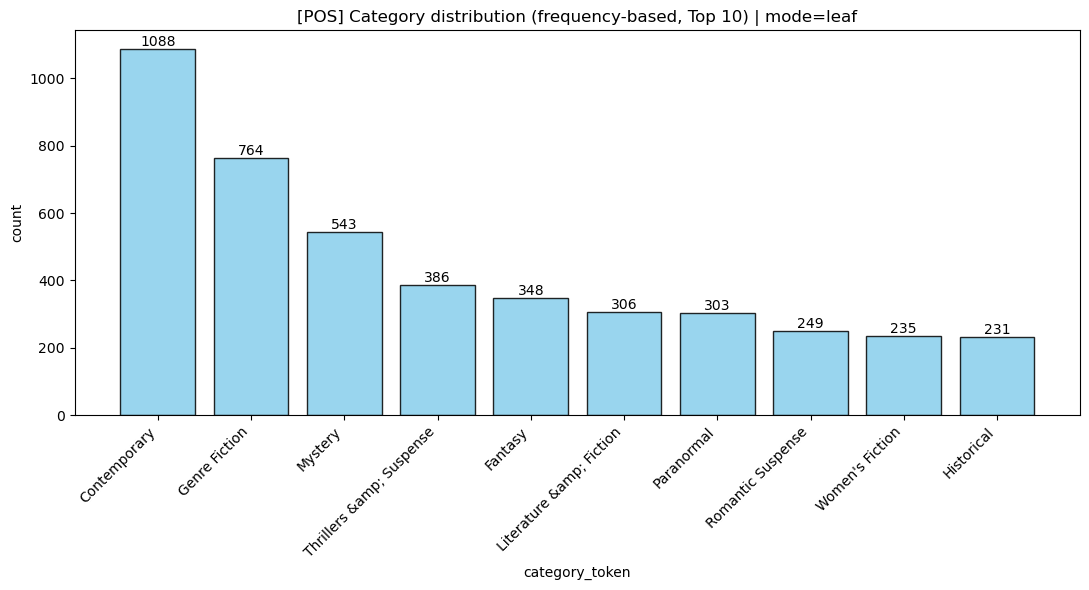

saved figure to: /home/parkdw00/Codes/Augmentation/data/books/results/pos_unique_item_category_bar_part5_step0_AB_leaf.png


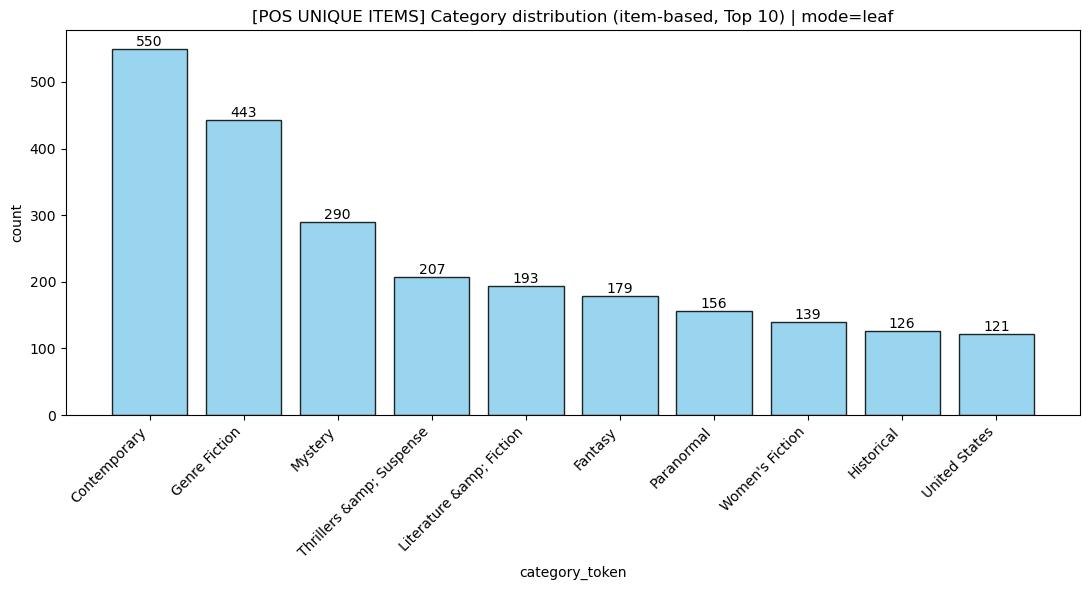

In [30]:
import os
import json
import pickle
from collections import Counter
from pathlib import Path
from typing import Any

import pandas as pd
import matplotlib.pyplot as plt


# =========================
# Paths (Books)
# =========================
META_JSONL_PATH = "/home/parkdw00/Codes/data/books/item_meta_2017_kcore10_user_item_split_filtered.json"
PKL_PATH = "/home/parkdw00/Codes/Augmentation/data/books/aug_triplets_part5_step0.pkl"

OUT_DIR = "/home/parkdw00/Codes/Augmentation/data/books/results"
os.makedirs(OUT_DIR, exist_ok=True)


def load_pickle(path: str):
    with open(path, "rb") as f:
        return pickle.load(f)


def load_books_item_meta_jsonl(meta_path: str) -> pd.DataFrame:
    """
    JSONL 한 줄 예시:
    {"item_id": 0, "asin": "...", "title": "...", "category": ["Books", "Literature & Fiction", "Genre Fiction"], ...}

    반환 df 컬럼:
    - item_id (int)
    - title (str, optional)
    - category (list[str], optional)
    """
    rows = []
    with open(meta_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                obj = json.loads(line)
            except Exception:
                continue
            if "item_id" not in obj:
                continue
            rows.append({
                "item_id": int(obj["item_id"]),
                "title": obj.get("title", None),
                "category": obj.get("category", None),
            })
    return pd.DataFrame(rows)


def build_category_long_table(
    meta_df: pd.DataFrame,
    mode: str = "leaf",
) -> pd.DataFrame:
    """
    (item_id, category_token) long-form 생성.

    mode:
    - "leaf": category path의 마지막 토큰만 사용
      예: ["Books","Literature & Fiction","Genre Fiction"] -> "Genre Fiction"
    - "all": category path의 모든 토큰을 각각 카운트
      예: -> "Books", "Literature & Fiction", "Genre Fiction"
    - "path": category path 전체를 " > "로 join해서 하나의 토큰으로 카운트
      예: -> "Books > Literature & Fiction > Genre Fiction"
    """
    rows = []

    for _, r in meta_df.iterrows():
        item_id = int(r["item_id"])
        cat = r.get("category", None)

        if cat is None or (isinstance(cat, float) and pd.isna(cat)):
            continue

        if isinstance(cat, str):
            # 어떤 전처리에서 문자열로 들어왔을 가능성 방어
            # "['Books', '...']" 형태면 eval은 위험하니 최소 처리만
            cat_list = [cat.strip()] if cat.strip() else []
        elif isinstance(cat, list):
            cat_list = [str(x).strip() for x in cat if x is not None and str(x).strip()]
        else:
            cat_list = [str(cat).strip()] if str(cat).strip() else []

        if not cat_list:
            continue

        if mode == "leaf":
            rows.append((item_id, cat_list[-1]))
        elif mode == "all":
            for tok in cat_list:
                rows.append((item_id, tok))
        elif mode == "path":
            rows.append((item_id, " > ".join(cat_list)))
        else:
            raise ValueError(f"Unknown mode: {mode}")

    return pd.DataFrame(rows, columns=["item_id", "category_token"])


def analyze_pos_category_distribution(
    triplets_pkl_path: str,
    cat_long_df: pd.DataFrame,
    topk: int = 30,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    반환:
    - counts: pos 선택 빈도 기반 category 분포 (count, prob)
    - cat_item_count_df: 유니크 pos 아이템 기준 category 분포 (item_count)
    """
    triplets = load_pickle(triplets_pkl_path)

    pos_items = []
    for t in triplets:
        if not isinstance(t, (list, tuple)) or len(t) < 3:
            continue
        _, pos, _ = t[0], t[1], t[2]
        try:
            pos_items.append(int(pos))
        except Exception:
            continue

    if len(pos_items) == 0:
        empty1 = pd.DataFrame(columns=["category_token", "count", "prob"])
        empty2 = pd.DataFrame(columns=["category_token", "item_count"])
        return empty1, empty2

    # === pos_items 내 유니크 아이템별 선택 횟수 ===
    pos_item_counter = Counter(pos_items)
    pos_item_count_df = (
        pd.DataFrame(pos_item_counter.items(), columns=["item_id", "pos_count"])
        .sort_values("pos_count", ascending=False)
        .reset_index(drop=True)
    )

    print(f"[POS ITEM COUNTS] unique items: {len(pos_item_count_df)}")
    print(pos_item_count_df.head(20))
    print("count stats:\n", pos_item_count_df["pos_count"].describe())

    # === 유니크 아이템 기준 category 카운트 ===
    unique_pos_items = pos_item_count_df["item_id"].unique()

    unique_item_cats = (
        pd.DataFrame({"item_id": unique_pos_items})
        .merge(cat_long_df, on="item_id", how="left")
        .dropna(subset=["category_token"])
        .drop_duplicates(subset=["item_id", "category_token"])
    )

    cat_item_count_df = (
        unique_item_cats.groupby("category_token")
        .size()
        .sort_values(ascending=False)
        .rename("item_count")
        .reset_index()
    )

    print("[UNIQUE POS ITEMS] category count (item-based)")
    print(cat_item_count_df.head(20))

    # === 빈도 기반 category 분포 ===
    pos_df = pd.DataFrame({"item_id": pos_items})
    merged = pos_df.merge(cat_long_df, on="item_id", how="left").dropna(subset=["category_token"])

    counts = (
        merged.groupby("category_token")
        .size()
        .sort_values(ascending=False)
        .rename("count")
        .reset_index()
    )

    total = int(counts["count"].sum()) if len(counts) > 0 else 0
    counts["prob"] = counts["count"] / max(1, total)

    if topk is not None:
        counts = counts.head(topk)

    return counts, cat_item_count_df


def plot_bar_vertical(
    df: pd.DataFrame,
    x_col: str,
    y_col: str,
    title: str,
    topk: int = 10,
    save_path: str | None = None,
):
    if df is None or df.empty:
        print("No data to plot.")
        return

    d = df.sort_values(y_col, ascending=False).head(topk).copy()

    plt.figure(figsize=(11, 6))
    bars = plt.bar(d[x_col], d[y_col], color="skyblue", edgecolor="black", alpha=0.85)
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.xticks(rotation=45, ha="right")

    for bar in bars:
        h = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            h,
            f"{int(h)}",
            ha="center",
            va="bottom",
            fontsize=10,
        )

    plt.tight_layout()

    if save_path is not None:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=300)
        print(f"saved figure to: {save_path}")

    plt.show()


# =========================
# Run
# =========================
meta_df = load_books_item_meta_jsonl(META_JSONL_PATH)
print("meta_df:", meta_df.shape)
print(meta_df.head(3))

# 여기 mode를 바꿔가며 보면 됨: "leaf" 추천
MODE = "leaf"   # "leaf" | "all" | "path"
cat_long_df = build_category_long_table(meta_df, mode=MODE)
print("cat_long_df:", cat_long_df.shape)
print(cat_long_df.head(5))

pos_cat_df, unique_pos_cat_df = analyze_pos_category_distribution(PKL_PATH, cat_long_df, topk=30)

# CSV 저장
pos_cat_csv = f"{OUT_DIR}/pos_category_dist_part1_step0_AB_{MODE}.csv"
uniq_cat_csv = f"{OUT_DIR}/unique_pos_item_category_dist_part1_step0_AB_{MODE}.csv"
pos_cat_df.to_csv(pos_cat_csv, index=False)
unique_pos_cat_df.to_csv(uniq_cat_csv, index=False)
print("saved:", pos_cat_csv)
print("saved:", uniq_cat_csv)

print("\n[AB] positive(pos) category distribution (top 30)")
print(pos_cat_df.head(30))

# Plot (frequency-based)
plot_bar_vertical(
    pos_cat_df,
    x_col="category_token",
    y_col="count",
    title=f"[POS] Category distribution (frequency-based, Top 10) | mode={MODE}",
    topk=10,
    save_path=f"{OUT_DIR}/pos_category_bar_part1_step0_AB_{MODE}.png",
)

# Plot (unique-item-based)
unique_plot_df = unique_pos_cat_df.rename(columns={"item_count": "count"})
plot_bar_vertical(
    unique_plot_df,
    x_col="category_token",
    y_col="count",
    title=f"[POS UNIQUE ITEMS] Category distribution (item-based, Top 10) | mode={MODE}",
    topk=10,
    save_path=f"{OUT_DIR}/pos_unique_item_category_bar_part5_step0_AB_{MODE}.png",
)


### RQ3

In [27]:
import os
import json
import pickle
from collections import Counter
from pathlib import Path
from typing import Dict, List, Tuple

import pandas as pd
import matplotlib.pyplot as plt


# =========================
# Paths (Books)
# =========================
META_JSONL_PATH = "/home/parkdw00/Codes/data/books/item_meta_2017_kcore10_user_item_split_filtered.json"

PKL_DIR = "/home/parkdw00/Codes/Augmentation/data/books"
PKL_TEMPLATE = "aug_triplets_part5_step{step}.pkl"  # step=0..4

OUT_DIR = "/home/parkdw00/Codes/Augmentation/data/books/results/step_comparison_groupplot"
os.makedirs(OUT_DIR, exist_ok=True)


# =========================
# IO
# =========================
def load_pickle(path: str):
    with open(path, "rb") as f:
        return pickle.load(f)


def load_books_item_meta_jsonl(meta_path: str) -> pd.DataFrame:
    rows = []
    with open(meta_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                obj = json.loads(line)
            except Exception:
                continue
            if "item_id" not in obj:
                continue
            rows.append({
                "item_id": int(obj["item_id"]),
                "title": obj.get("title", None),
                "category": obj.get("category", None),
            })
    return pd.DataFrame(rows)


def build_category_long_table(meta_df: pd.DataFrame, mode: str = "leaf") -> pd.DataFrame:
    rows = []
    for _, r in meta_df.iterrows():
        item_id = int(r["item_id"])
        cat = r.get("category", None)

        if cat is None or (isinstance(cat, float) and pd.isna(cat)):
            continue

        if isinstance(cat, str):
            cat_list = [cat.strip()] if cat.strip() else []
        elif isinstance(cat, list):
            cat_list = [str(x).strip() for x in cat if x is not None and str(x).strip()]
        else:
            cat_list = [str(cat).strip()] if str(cat).strip() else []

        if not cat_list:
            continue

        if mode == "leaf":
            rows.append((item_id, cat_list[-1]))
        elif mode == "all":
            for tok in cat_list:
                rows.append((item_id, tok))
        elif mode == "path":
            rows.append((item_id, " > ".join(cat_list)))
        else:
            raise ValueError(f"Unknown mode: {mode}")

    return pd.DataFrame(rows, columns=["item_id", "category_token"])


# =========================
# Analysis
# =========================
def analyze_pos_category_distribution(
    triplets_pkl_path: str,
    cat_long_df: pd.DataFrame,
    topk: int | None = 30,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    triplets = load_pickle(triplets_pkl_path)

    pos_items: List[int] = []
    for t in triplets:
        if not isinstance(t, (list, tuple)) or len(t) < 3:
            continue
        pos = t[1]
        try:
            pos_items.append(int(pos))
        except Exception:
            continue

    if len(pos_items) == 0:
        empty1 = pd.DataFrame(columns=["category_token", "count", "prob"])
        empty2 = pd.DataFrame(columns=["category_token", "item_count"])
        return empty1, empty2

    pos_item_counter = Counter(pos_items)
    pos_item_count_df = (
        pd.DataFrame(pos_item_counter.items(), columns=["item_id", "pos_count"])
        .sort_values("pos_count", ascending=False)
        .reset_index(drop=True)
    )

    unique_pos_items = pos_item_count_df["item_id"].unique()

    unique_item_cats = (
        pd.DataFrame({"item_id": unique_pos_items})
        .merge(cat_long_df, on="item_id", how="left")
        .dropna(subset=["category_token"])
        .drop_duplicates(subset=["item_id", "category_token"])
    )

    cat_item_count_df = (
        unique_item_cats.groupby("category_token")
        .size()
        .sort_values(ascending=False)
        .rename("item_count")
        .reset_index()
    )

    pos_df = pd.DataFrame({"item_id": pos_items})
    merged = pos_df.merge(cat_long_df, on="item_id", how="left").dropna(subset=["category_token"])

    counts = (
        merged.groupby("category_token")
        .size()
        .sort_values(ascending=False)
        .rename("count")
        .reset_index()
    )

    total = int(counts["count"].sum()) if len(counts) > 0 else 0
    counts["prob"] = counts["count"] / max(1, total)

    if topk is not None:
        counts = counts.head(topk)

    return counts, cat_item_count_df


def load_steps_pos_category(
    pkl_dir: str,
    pkl_template: str,
    steps: List[int],
    cat_long_df: pd.DataFrame,
    topk: int | None = 30,
) -> Tuple[Dict[str, pd.DataFrame], Dict[str, pd.DataFrame]]:
    freq_by_step: Dict[str, pd.DataFrame] = {}
    uniq_by_step: Dict[str, pd.DataFrame] = {}

    for s in steps:
        step_name = f"Step {s}"
        pkl_path = os.path.join(pkl_dir, pkl_template.format(step=s))
        if not os.path.exists(pkl_path):
            print(f"❌ missing: {pkl_path}")
            freq_by_step[step_name] = pd.DataFrame(columns=["category_token", "count", "prob"])
            uniq_by_step[step_name] = pd.DataFrame(columns=["category_token", "item_count"])
            continue

        print(f"📂 loading: {pkl_path}")
        freq_df, uniq_df = analyze_pos_category_distribution(pkl_path, cat_long_df, topk=topk)
        freq_by_step[step_name] = freq_df
        uniq_by_step[step_name] = uniq_df

    return freq_by_step, uniq_by_step


# =========================
# Groupplot (2x3 grid, Step0~4)
# =========================
def plot_group_grid(
    dfs_by_step: Dict[str, pd.DataFrame],
    kind: str,                 # "pos_freq" or "pos_unique"
    topk: int,
    mode_tag: str,
    out_path: str,
    color: str = "skyblue",
):
    # Step 정렬 (Step 0..4)
    steps = sorted(dfs_by_step.keys(), key=lambda x: int(x.split()[-1]))

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for i, step_name in enumerate(steps):
        if i >= 5:
            break

        ax = axes[i]
        df = dfs_by_step[step_name]

        if df is None or df.empty:
            ax.text(0.5, 0.5, "No Data", ha="center", va="center")
            ax.set_title(step_name, fontsize=12, fontweight="bold")
            ax.axis("off")
            continue

        d = df.copy()

        # unique-item 기반이면 item_count -> count로 통일
        if "count" not in d.columns and "item_count" in d.columns:
            d = d.rename(columns={"item_count": "count"})

        if "count" not in d.columns:
            ax.text(0.5, 0.5, "No count column", ha="center", va="center")
            ax.set_title(step_name, fontsize=12, fontweight="bold")
            ax.axis("off")
            continue

        d = d.sort_values("count", ascending=False).head(topk).copy()

        bars = ax.bar(d["category_token"], d["count"], color=color, edgecolor="black", alpha=0.85)

        for bar in bars:
            h = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                h + (h * 0.01),
                f"{int(h)}",
                ha="center",
                va="bottom",
                fontsize=9,
                fontweight="bold",
            )

        ax.set_title(f"{step_name} (Top {topk})", fontsize=12, fontweight="bold")
        ax.tick_params(axis="x", rotation=45, labelsize=9)
        ax.grid(axis="y", linestyle="--", alpha=0.5)
        ax.set_xlabel("")
        ax.set_ylabel("count")

    # 마지막 6번째 칸 비우기
    axes[5].axis("off")

    title_map = {
        "pos_freq": "[POS] Category distribution (frequency-based)",
        "pos_unique": "[POS UNIQUE ITEMS] Category distribution (item-based)",
    }
    main_title = title_map.get(kind, kind)
    fig.suptitle(f"{main_title} | mode={mode_tag} | Step 0-4", fontsize=18, fontweight="bold")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_path, dpi=300)
    plt.close()
    print(f"✅ saved groupplot: {out_path}")


# =========================
# Run
# =========================
meta_df = load_books_item_meta_jsonl(META_JSONL_PATH)
MODE = "leaf"  # "leaf" | "all" | "path"
cat_long_df = build_category_long_table(meta_df, mode=MODE)

STEPS = [0, 1, 2, 3, 4]

pos_freq_by_step, pos_uniq_by_step = load_steps_pos_category(
    pkl_dir=PKL_DIR,
    pkl_template=PKL_TEMPLATE,
    steps=STEPS,
    cat_long_df=cat_long_df,
    topk=30,
)

# groupplot 저장 (각 1장씩)
plot_group_grid(
    dfs_by_step=pos_freq_by_step,
    kind="pos_freq",
    topk=10,
    mode_tag=MODE,
    out_path=f"{OUT_DIR}/groupplot_pos_freq_{MODE}.png",
    color="skyblue",
)

plot_group_grid(
    dfs_by_step=pos_uniq_by_step,
    kind="pos_unique",
    topk=10,
    mode_tag=MODE,
    out_path=f"{OUT_DIR}/groupplot_pos_unique_{MODE}.png",
    color="skyblue",
)


📂 loading: /home/parkdw00/Codes/Augmentation/data/books/aug_triplets_part5_step0.pkl
📂 loading: /home/parkdw00/Codes/Augmentation/data/books/aug_triplets_part5_step1.pkl
📂 loading: /home/parkdw00/Codes/Augmentation/data/books/aug_triplets_part5_step2.pkl
📂 loading: /home/parkdw00/Codes/Augmentation/data/books/aug_triplets_part5_step3.pkl
📂 loading: /home/parkdw00/Codes/Augmentation/data/books/aug_triplets_part5_step4.pkl
✅ saved groupplot: /home/parkdw00/Codes/Augmentation/data/books/results/step_comparison_groupplot/groupplot_pos_freq_leaf.png
✅ saved groupplot: /home/parkdw00/Codes/Augmentation/data/books/results/step_comparison_groupplot/groupplot_pos_unique_leaf.png


### Hallucination

In [ ]:
import pickle
from collections import Counter, defaultdict

AB_PATH = "/home/parkdw00/Codes/Augmentation/data/books/aug_triplets_part1_step0_AB.pkl"
BA_PATH = "/home/parkdw00/Codes/Augmentation/data/books/aug_triplets_part1_step0_BA.pkl"

def load_triplets(path: str):
    with open(path, "rb") as f:
        return pickle.load(f)  # List[Tuple[int,int,int]]

def build_pos_counter(triplets):
    """
    key = (u, a, b) where a<b are the unordered pair
    value = Counter({pos_item: count})
    """
    d = defaultdict(Counter)
    for u, pos, neg in triplets:
        a, b = sorted((int(pos), int(neg)))
        key = (int(u), a, b)
        d[key][int(pos)] += 1
    return d

ab = load_triplets(AB_PATH)
ba = load_triplets(BA_PATH)

print("AB triplets:", len(ab))
print("BA triplets:", len(ba))

ab_map = build_pos_counter(ab)
ba_map = build_pos_counter(ba)

common_keys = set(ab_map.keys()) & set(ba_map.keys())
only_ab = set(ab_map.keys()) - set(ba_map.keys())
only_ba = set(ba_map.keys()) - set(ab_map.keys())

if only_ab or only_ba:
    print(f"WARNING: key mismatch. only_ab={len(only_ab)}, only_ba={len(only_ba)}")

mismatch_total = 0
match_total = 0
total_compared = 0

# optional: mismatch examples
examples = []

for key in common_keys:
    # key=(u,a,b)
    u, a, b = key

    ab_counts = ab_map[key]  # Counter(pos)
    ba_counts = ba_map[key]

    total_ab = sum(ab_counts.values())
    total_ba = sum(ba_counts.values())
    if total_ab != total_ba:
        # 같은 key에 대해 AB/BA 샘플 수가 다르면 비교가 애매함
        # 그래도 가능한 범위(min)까지만 비교하거나, 그냥 스킵할 수도 있음.
        # 여기선 "가능한 매칭" 기준으로 계산.
        pass

    # 같은 pos로 매칭 가능한 개수
    match_a = min(ab_counts.get(a, 0), ba_counts.get(a, 0))
    match_b = min(ab_counts.get(b, 0), ba_counts.get(b, 0))
    matches = match_a + match_b

    # 비교 가능한 총 개수(멀티셋이므로 양쪽 중 작은 쪽 기준)
    total = min(total_ab, total_ba)

    mismatches = total - matches

    match_total += matches
    mismatch_total += mismatches
    total_compared += total

    if mismatches > 0 and len(examples) < 20:
        examples.append({
            "user": u, "pair": (a, b),
            "AB": dict(ab_counts), "BA": dict(ba_counts),
            "mismatches": mismatches, "total": total
        })

print("\n===== RESULT =====")
print("Compared pairs(keys):", len(common_keys))
print("Total comparable samples:", total_compared)
print("Match count:", match_total)
print("Mismatch count (pos differs AB vs BA):", mismatch_total)
if total_compared > 0:
    print("Mismatch rate:", mismatch_total / total_compared)

print("\n===== mismatch examples (up to 20) =====")
for ex in examples:
    print(ex)


AB triplets: 6511
BA triplets: 6511

===== RESULT =====
Compared pairs(keys): 6511
Total comparable samples: 6511
Match count: 4486
Mismatch count (pos differs AB vs BA): 2025
Mismatch rate: 0.31101213331285515

===== mismatch examples (up to 20) =====
{'user': 32326, 'pair': (22667, 24567), 'AB': {22667: 1}, 'BA': {24567: 1}, 'mismatches': 1, 'total': 1}
{'user': 31923, 'pair': (21440, 24843), 'AB': {24843: 1}, 'BA': {21440: 1}, 'mismatches': 1, 'total': 1}
{'user': 11400, 'pair': (21315, 21838), 'AB': {21315: 1}, 'BA': {21838: 1}, 'mismatches': 1, 'total': 1}
{'user': 22821, 'pair': (20997, 22851), 'AB': {20997: 1}, 'BA': {22851: 1}, 'mismatches': 1, 'total': 1}
{'user': 1224, 'pair': (22207, 23048), 'AB': {23048: 1}, 'BA': {22207: 1}, 'mismatches': 1, 'total': 1}
{'user': 27927, 'pair': (21230, 22967), 'AB': {21230: 1}, 'BA': {22967: 1}, 'mismatches': 1, 'total': 1}
{'user': 1482, 'pair': (20963, 22795), 'AB': {22795: 1}, 'BA': {20963: 1}, 'mismatches': 1, 'total': 1}
{'user': 23361

# RQ2 & RQ3
LLM이 생성한 데이터로 추천을 반복한 (피드백루프 이후)결과 분석(Part1: RQ2, Part5: RQ3)

포함: LLMRec, A-LLMRec, Augmentation, TR_CF

## Hallucination

### A-LLMRec

In [4]:
import json
from collections import defaultdict

# 2) 각 시나리오별 pred_count 및 user 집합 수집
scenarios = [
    ('case2','part1'),
    ('case2','part5'),
]
pred_counts = {}
pred_user_sets = {}
for case, part in scenarios:
    path = f"{BASE_DIR}/predict_label_{part}.json"
    with open(path) as f:
        raw = json.load(f)
    # 문자열 키 → 정수, 예측 수
    cnt_dict = {int(u): len(titles) for u, titles in raw.items()}
    key = f"{case}_{part}"
    pred_counts[key] = cnt_dict
    pred_user_sets[key] = set(cnt_dict.keys())

# 3) 공통 유저 집합: train ∩ label (요청하신 방식), int형으로 변환 
common_users = sorted(set(train_data) & set(ground_truth))

# 4) 실제(interactions) 총합 계산 (common users만)
actual_total = sum(len(ground_truth[u]) for u in common_users)
print(f"Actual total interactions (common users): {actual_total}, {len(common_users)}명\n")

# 5) 시나리오별 계산 및 출력 + case별 missing user 카운트
case_missing_users = {'case1': set(), 'case2': set()}
common_users = [int(u) for u in common_users]  # 정수형으로 변환

for case, part in scenarios:
    key = f"{case}_{part}"
    pred_users = pred_user_sets[key]
    missing_users = set(common_users) - pred_users  # 예측에 없는 common user
    case_missing_users[case].update(missing_users)  # case별 누적

    pred_total = sum(pred_counts[key].get(u, 0) for u in common_users)
    missing    = actual_total - pred_total
    missing_pct= missing / actual_total * 100

    print(f"{key}:")
    print(f"  Predicted total (common users) = {pred_total}")
    print(f"  Missing interactions           = {missing} ({missing_pct:.2f}%)")
    print(f"  Missing users (count)          = {len(missing_users)}\n")


Actual total interactions (common users): 440917, 31445명

case2_part1:
  Predicted total (common users) = 440485
  Missing interactions           = 432 (0.10%)
  Missing users (count)          = 0

case2_part5:
  Predicted total (common users) = 440917
  Missing interactions           = 0 (0.00%)
  Missing users (count)          = 0



In [12]:
def load_userlist_counts(path: str) -> dict[int, int]:
    if not os.path.exists(path):
        return {}
    with open(path, "r") as f:
        data = json.load(f)
    out = {}
    if isinstance(data, dict):
        for u, arr in data.items():
            try:
                uid = int(u)
            except:
                continue
            if isinstance(arr, list):
                out[uid] = len(arr)
            elif isinstance(arr, int):
                out[uid] = arr
            else:
                out[uid] = 0
    return out

def summarize_case2_part(part: int, max_step: int) -> pd.DataFrame:
    rows, all_users = [], set()

    # 모든 step에서 user id 유니온 수집
    for step in range(1, max_step+1):
        miss_path = os.path.join(BASE_DIR, f"missing_titles_books_case2_part{part}_step{step}.json")
        dup_path  = os.path.join(BASE_DIR, f"skipped_duplicates_books_case2_part{part}_step{step}.json")
        miss = load_userlist_counts(miss_path)
        dup  = load_userlist_counts(dup_path)
        all_users |= set(miss.keys()) | set(dup.keys())

    # step별 카운트(없으면 0)
    for step in range(1, max_step+1):
        miss_path = os.path.join(BASE_DIR, f"missing_titles_books_case2_part{part}_step{step}.json")
        dup_path  = os.path.join(BASE_DIR, f"skipped_duplicates_books_case2_part{part}_step{step}.json")
        miss = load_userlist_counts(miss_path)
        dup  = load_userlist_counts(dup_path)
        for u in sorted(all_users):
            rows.append({
                "user_id": u,
                "step": step,
                "missing_title": int(miss.get(u, 0)),
                "skipped_duplicates": int(dup.get(u, 0)),
            })
    return pd.DataFrame(rows).sort_values(["user_id","step"]).reset_index(drop=True)

# 요약 생성
df1  = summarize_case2_part(part=1,  max_step=1)
df5  = summarize_case2_part(part=5,  max_step=5)

# (1) part5: step별 합계 표 출력
step_totals1 = (
    df1.groupby("step")[["missing_title","skipped_duplicates"]]
      .sum()
      .reset_index()
      .astype({"step": int, "missing_title": int, "skipped_duplicates": int})
)
print(step_totals1.to_string(index=False))

step_totals5 = (
    df5.groupby("step")[["missing_title","skipped_duplicates"]]
      .sum()
      .reset_index()
      .astype({"step": int, "missing_title": int, "skipped_duplicates": int})
)
print(step_totals5.to_string(index=False))


# (2) parts overall totals (part5/part10 전체 합계) 출력
overall1  = df1[["missing_title","skipped_duplicates"]].sum().astype(int).to_dict()
overall5  = df5[["missing_title","skipped_duplicates"]].sum().astype(int).to_dict()

parts_overall = pd.DataFrame([
    {"part": 1,  **overall1},
    {"part": 5,  **overall5},
])[["part","missing_title","skipped_duplicates"]]

print("\n[parts overall totals]")
print(parts_overall.to_string(index=False))



 step  missing_title  skipped_duplicates
    1          32750                2717
 step  missing_title  skipped_duplicates
    1           3526               12390
    2           3278                5525
    3          20058                2626
    4           3846                2725
    5           3212                1816

[parts overall totals]
 part  missing_title  skipped_duplicates
    1          32750                2717
    5          33920               25082


In [7]:
import os, json
import pandas as pd

PARTS = 5
base_dir_hallu = "/home/parkdw00/Codes/data/books/A-LLMRec_format/A-LLMRec_results"
PREFIX = "predict_label_part5_step"   # 필요하면 predict_label 쪽으로 바꿔
TRY0, TRY1 = 0, 1

def load_json(path):
    with open(path, "r") as f:
        d = json.load(f)
    out = {}
    for k, v in d.items():
        uid = int(k)
        if v is None:
            out[uid] = []
        elif isinstance(v, list):
            out[uid] = [int(x) for x in v]
        else:
            out[uid] = [int(v)]
    return out

def compare_step(d0, d1, step):
    all_users = sorted(set(d0.keys()) | set(d1.keys()))
    rows = []
    changed = 0
    for u in all_users:
        a = d0.get(u, [])
        b = d1.get(u, [])
        if a == b:
            continue
        changed += 1
        sa, sb = set(a), set(b)
        rows.append({
            "step": step,
            "user_id": u,
            "try0": a,
            "try1": b,
            "len_try0": len(a),
            "len_try1": len(b),
            "only_in_try0": sorted(list(sa - sb)),
            "only_in_try1": sorted(list(sb - sa)),
            "set_equal": (sa == sb),
        })
    return changed, pd.DataFrame(rows)

# ---- run ----
summary_rows = []
detail_dfs = []

for step in range(1, PARTS+1):
    p0 = os.path.join(base_dir_hallu, f"{PREFIX}{step}_try{TRY0}.json")
    p1 = os.path.join(base_dir_hallu, f"{PREFIX}{step}_try{TRY1}.json")

    d0 = load_json(p0)
    d1 = load_json(p1)

    changed, df_detail = compare_step(d0, d1, step)
    union_users = len(set(d0.keys()) | set(d1.keys()))
    exact_equal = union_users - changed

    # set은 같은데 순서만 다른 케이스
    order_only = int(df_detail["set_equal"].sum()) if len(df_detail) else 0

    summary_rows.append({
        "step": step,
        "users_try0": len(d0),
        "users_try1": len(d1),
        "users_union": union_users,
        "users_changed(+1 per user)": changed,
        "users_exact_equal": exact_equal,
        "changed_set_equal_but_order_diff": order_only,
        "file_try0": p0,
        "file_try1": p1,
    })

    detail_dfs.append(df_detail)

df_summary = pd.DataFrame(summary_rows)
df_detail_all = pd.concat(detail_dfs, ignore_index=True) if detail_dfs else pd.DataFrame()

df_summary


,step,users_try0,users_try1,users_union,users_changed(+1 per user),users_exact_equal,changed_set_equal_but_order_diff,file_try0,file_try1
0,1,0,0,0,0,0,0,/home/parkdw00/Codes/data/books/A-LLMRec_forma...,/home/parkdw00/Codes/data/books/A-LLMRec_forma...
1,2,0,0,0,0,0,0,/home/parkdw00/Codes/data/books/A-LLMRec_forma...,/home/parkdw00/Codes/data/books/A-LLMRec_forma...
2,3,0,0,0,0,0,0,/home/parkdw00/Codes/data/books/A-LLMRec_forma...,/home/parkdw00/Codes/data/books/A-LLMRec_forma...
3,4,0,0,0,0,0,0,/home/parkdw00/Codes/data/books/A-LLMRec_forma...,/home/parkdw00/Codes/data/books/A-LLMRec_forma...
4,5,0,0,0,0,0,0,/home/parkdw00/Codes/data/books/A-LLMRec_forma...,/home/parkdw00/Codes/data/books/A-LLMRec_forma...


In [39]:
import os
import json
from collections import defaultdict

def load_predict_json(path: str) -> dict[int, list[int]]:
    with open(path, "r") as f:
        raw = json.load(f)
    # key가 str일 수 있으니 int로 통일
    out = {}
    for k, v in raw.items():
        try:
            uid = int(k)
        except:
            continue
        if isinstance(v, list):
            out[uid] = [int(x) for x in v]
        else:
            out[uid] = [int(v)]
    return out

def aggregate_across_steps(result_root: str, parts: int, steps: list[int], try_id: int) -> dict[int, list[int]]:
    """
    step별 predict_label을 읽어 user별로 전부 이어붙임.
    (중복 제거는 나중에 set으로 할지/순서 보존할지 선택 가능)
    """
    agg = defaultdict(list)
    for s in steps:
        p = os.path.join(result_root, f"predict_label_part{parts}_step{s}_try{try_id}.json")
        if not os.path.exists(p):
            raise FileNotFoundError(f"missing file: {p}")
        d = load_predict_json(p)
        for u, items in d.items():
            agg[u].extend(items)
    return dict(agg)

def unique_list_preserve_order(xs):
    seen = set()
    out = []
    for x in xs:
        if x not in seen:
            out.append(x)
            seen.add(x)
    return out

def compute_logical_contradiction(try0_agg: dict[int, list[int]], try1_agg: dict[int, list[int]]):
    users = sorted(set(try0_agg.keys()) | set(try1_agg.keys()))

    sum_intersection = 0
    sum_denominator  = 0

    per_user = []  # 원하면 유저별 결과도 저장

    for u in users:
        a = unique_list_preserve_order(try0_agg.get(u, []))
        b = unique_list_preserve_order(try1_agg.get(u, []))

        set_a = set(a)
        set_b = set(b)

        inter = len(set_a & set_b)
        denom = max(len(set_a), len(set_b))  # 더 긴 추천 길이 기준

        # 둘 다 비어있으면 이 유저는 비교 불가. 분모 0이므로 스킵(정책)
        if denom == 0:
            continue

        sum_intersection += inter
        sum_denominator  += denom

        overlap_u = inter / denom
        contradiction_u = 1 - overlap_u

        per_user.append({
            "user_id": u,
            "len_try0": len(set_a),
            "len_try1": len(set_b),
            "intersection": inter,
            "denom_maxlen": denom,
            "overlap_ratio": overlap_u,
            "contradiction": contradiction_u,
        })

    if sum_denominator == 0:
        raise ValueError("No comparable users: sum_denominator is 0.")

    overlap_global = sum_intersection / sum_denominator
    contradiction_global = 1 - overlap_global

    return contradiction_global, overlap_global, sum_intersection, sum_denominator, per_user


if __name__ == "__main__":
    parts = 1#5
    steps = [1]#[1,2,3,4,5]

    RESULT_ROOT = "/home/parkdw00/Codes/data/books/A-LLMRec_format/A-LLMRec_results"

    # 1) try별로 step1~5를 전부 합치기
    try0_agg = aggregate_across_steps(RESULT_ROOT, parts=parts, steps=steps, try_id=0)
    try1_agg = aggregate_across_steps(RESULT_ROOT, parts=parts, steps=steps, try_id=1)

    # 2) contradiction 계산
    contradiction, overlap, num, den, per_user = compute_logical_contradiction(try0_agg, try1_agg)

    print("=== Logical Contradiction (try0 vs try1) ===")
    print(f"global_overlap = {overlap:.6f}  (={num}/{den})")
    print(f"logical_contradiction = {contradiction:.6f}")

    # 3) 유저별 상세 저장(선택)
    out_path = os.path.join(RESULT_ROOT, f"logical_contradiction_part{parts}_try0_vs_try1_per_user.json")
    with open(out_path, "w") as f:
        json.dump(per_user, f, indent=2)
    print(f"Saved per-user stats: {out_path}")


=== Logical Contradiction (try0 vs try1) ===
global_overlap = 0.458170  (=162790/355305)
logical_contradiction = 0.541830
Saved per-user stats: /home/parkdw00/Codes/data/books/A-LLMRec_format/A-LLMRec_results/logical_contradiction_part1_try0_vs_try1_per_user.json


### Augmentation

## Performance

In [14]:
""" 
Performance Check
"""

import json
import os
import numpy as np

def evaluate_prediction(pred_dict, ground_truth, common_users):
    precision_list = []
    recall_list = []
    hit_ratio_list = []
    ndcg_list = []
    hit_item_list = []

    for user_str, pred_items in pred_dict.items():
        if int(user_str) in common_users:
            user = int(user_str)
            if str(user) not in ground_truth:
                continue

            gt_items = set(ground_truth[str(user)])  # flat list of item_ids
            if not gt_items:
                continue

            k = len(gt_items)
            pred_topk = pred_items[:k]
            hit_items = set(pred_topk) & gt_items

            precision = len(hit_items) / k
            recall = len(hit_items) / len(gt_items)
            hit_ratio = 1.0 if len(hit_items) > 0 else 0.0

            hit_item_list.append((user, k, len(hit_items)))

            dcg = sum([1.0 / np.log2(i + 2) for i, item in enumerate(pred_topk) if item in gt_items])
            idcg = sum([1.0 / np.log2(i + 2) for i in range(min(len(gt_items), k))])
            ndcg = dcg / idcg if idcg > 0 else 0.0

            precision_list.append(precision)
            recall_list.append(recall)
            hit_ratio_list.append(hit_ratio)
            ndcg_list.append(ndcg)

    return {
        "precision": np.mean(precision_list),
        "recall": np.mean(recall_list),
        "hit_ratio": np.mean(hit_ratio_list),
        "ndcg": np.mean(ndcg_list),
        "hit_details": hit_item_list
    }

with open(PRED_P1) as f:
    pred_dict  = json.load(f)
print(len(pred_dict))
# 평가
result = evaluate_prediction(pred_dict, ground_truth, common_users)

print(f"Part1 Results:")
print(f"precision: {result['precision']:.4f}, recall: {result['recall']:.4f}, "
        f"hit_ratio: {result['hit_ratio']:.4f}, ndcg: {result['ndcg']:.4f}")

with open(PRED_P5) as f:
    pred_dict  = json.load(f)
print(len(pred_dict))

# 평가
result = evaluate_prediction(pred_dict, ground_truth, common_users)

print(f"Part5 Results:")
print(f"precision: {result['precision']:.4f}, recall: {result['recall']:.4f}, "
        f"hit_ratio: {result['hit_ratio']:.4f}, ndcg: {result['ndcg']:.4f}")


30952
Part1 Results:
precision: 0.1507, recall: 0.1507, hit_ratio: 0.6319, ndcg: 0.1687
31239
Part5 Results:
precision: 0.0606, recall: 0.0606, hit_ratio: 0.4245, ndcg: 0.0722


## Popularity & Diversity

### LLMRec, A-LLMRec, Augmentation, TR CF

32559 users in train_data
31445 users in ground_truth (Label)
31445 users in pred_p1
31445 users in pred_p5
len(common_users_final): 31445


/tmp/ipykernel_1936763/390001556.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


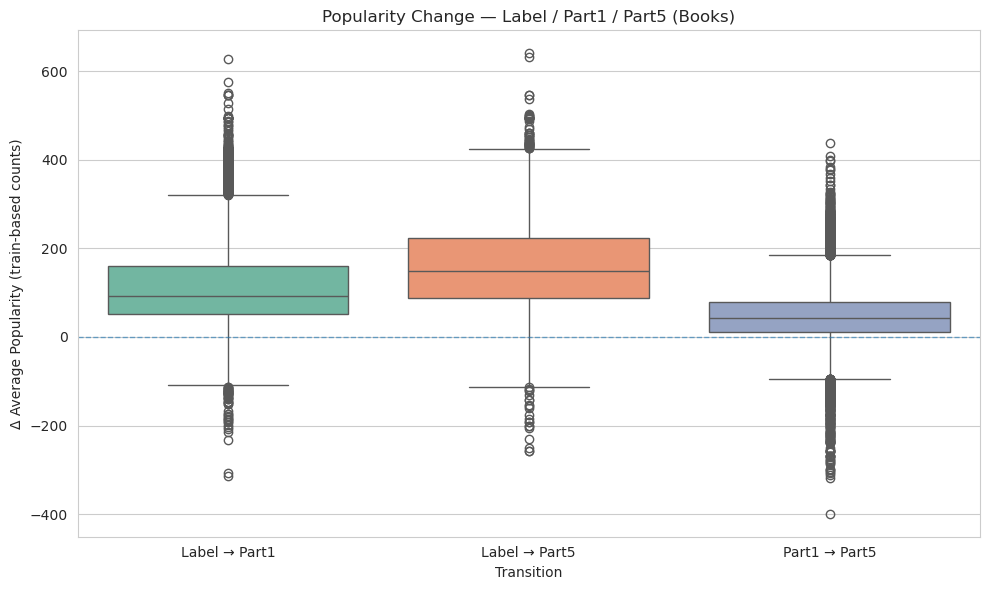

Summary (Popularity Δ)
                 count     mean     std    min     25%      50%      75%  \
transition                                                                 
Label → Part1  31445.0  111.022  82.281 -315.0  50.917   91.333  159.000   
Label → Part5  31445.0  158.013  89.542 -258.0  88.600  147.667  223.353   
Part1 → Part5  31445.0   46.992  58.976 -399.0  10.100   42.650   79.778   

                 max  
transition            
Label → Part1  628.0  
Label → Part5  640.0  
Part1 → Part5  437.0  


In [5]:
import json
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ---------------------------
# 1) Popularity from train_data
# ---------------------------
item_pop = Counter()
for items in train_data.values():
    for it in items:
        item_pop[int(it)] += 1

# ---------------------------
# 2) Load predictions
# ---------------------------
with open(PRED_P1) as f:
    pred_p1 = json.load(f)
with open(PRED_P5) as f:
    pred_p5 = json.load(f)

print(len(train_data), "users in train_data")
print(len(ground_truth), "users in ground_truth (Label)")
print(len(pred_p1), "users in pred_p1")
print(len(pred_p5), "users in pred_p5")

# ---------------------------
# 3) Common users
# ---------------------------
common_users_pred  = set(pred_p1.keys()) & set(pred_p5.keys())
common_users_label = set(ground_truth.keys())

# common_users는 (train ∩ label)로 이미 계산되어 있다고 가정
common_users_final = (
    set(map(str, common_users))
    & common_users_pred
    & common_users_label
)

print("len(common_users_final):", len(common_users_final))

# ---------------------------
# 4) Popularity metric
# ---------------------------
def avg_popularity_from_item_ids(user_items: dict[str, list[int]]):
    """
    Return: dict[uid(str)] -> avg_popularity
    """
    out = {}
    for uid, items in user_items.items():
        ids = [int(x) for x in items]
        pops = [item_pop.get(it, 0) for it in ids]
        out[str(uid)] = float(np.mean(pops)) if pops else 0.0
    return out

# 공통 사용자만 필터링
label_common = {u: ground_truth[u] for u in common_users_final}
p1_common    = {u: pred_p1[u]     for u in common_users_final}
p5_common    = {u: pred_p5[u]     for u in common_users_final}

m_label = avg_popularity_from_item_ids(label_common)
m_p1    = avg_popularity_from_item_ids(p1_common)
m_p5    = avg_popularity_from_item_ids(p5_common)

# ---------------------------
# 5) Δ transitions (Popularity only)
# ---------------------------
d_label_p1 = []
d_label_p5 = []
d_p1_p5    = []

for u in common_users_final:
    lp = m_label.get(u, 0.0)
    p1 = m_p1.get(u, 0.0)
    p5 = m_p5.get(u, 0.0)

    d_label_p1.append(p1 - lp)
    d_label_p5.append(p5 - lp)
    d_p1_p5.append(p5 - p1)

df_delta = pd.DataFrame({
    "delta": d_label_p1 + d_label_p5 + d_p1_p5,
    "transition": (
        ["Label → Part1"] * len(d_label_p1)
        + ["Label → Part5"] * len(d_label_p5)
        + ["Part1 → Part5"] * len(d_p1_p5)
    ),
    "metric": ["Popularity"] * (len(d_label_p1) + len(d_label_p5) + len(d_p1_p5)),
    "case": ["Books"] * (len(d_label_p1) + len(d_label_p5) + len(d_p1_p5)),
})

# ---------------------------
# 6) Plot
# ---------------------------
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

ax = sns.boxplot(
    data=df_delta,
    x="transition",
    y="delta",
    palette="Set2"
)

ax.set_title("Popularity Change — Label / Part1 / Part5 (Books)")
ax.set_xlabel("Transition")
ax.set_ylabel("Δ Average Popularity (train-based counts)")
ax.axhline(0, linestyle="--", linewidth=1, alpha=0.6)

plt.tight_layout()
plt.show()

print("Summary (Popularity Δ)")
print(df_delta.groupby("transition")["delta"].describe().round(3))


len(common_users_base): 31445
A-LLMRec: users used = 30952
LLMRec: users used = 31445
Augmentation: users used = 31445
df_delta shape: (93842, 5)


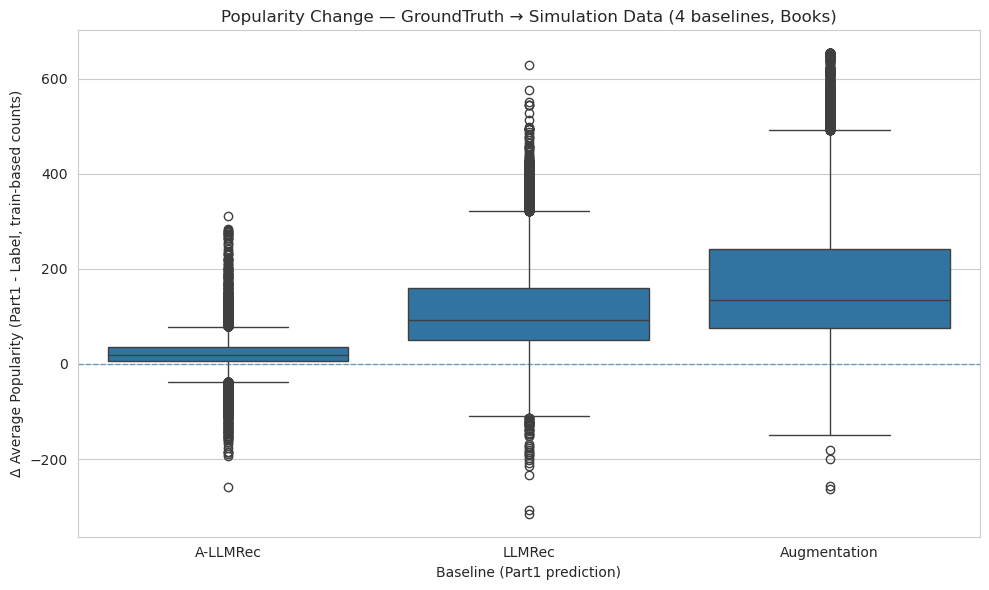

Summary (Δ Popularity = Part1 - Label)
                count     mean      std    min     25%      50%      75%  \
baseline                                                                   
A-LLMRec      30952.0   21.512   29.886 -259.0   6.267   18.000   35.216   
Augmentation  31445.0  169.564  124.995 -262.5  75.500  133.778  241.889   
LLMRec        31445.0  111.022   82.281 -315.0  50.917   91.333  159.000   

                max  
baseline             
A-LLMRec      312.0  
Augmentation  653.0  
LLMRec        628.0  
plot is saved -> /home/parkdw00/Codes/data/books/plots/popularity.png


In [4]:
# ===== ML-1M: Label vs Part1 (4 baselines) Popularity Change Boxplot =====
import json
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# 0) Paths (Part1 predictions of 4 baselines)
# ---------------------------
BASELINES_P1 = {
    "A-LLMRec": "/home/parkdw00/Codes/A-LLMRec/books_results/predict_label_part1.json",
    "LLMRec": "/home/parkdw00/Codes/data/books/books_llmrec_format/predict_label_part1.json",
    "Augmentation": "/home/parkdw00/Codes/Augmentation/data/books/predict_label_part1.json",
    #"TraditionalCF": "/home/parkdw00/Codes/data/books/traditionalCF/predict_label_part1.json",
}

# ---------------------------
# 1) Popularity from train_data
# ---------------------------
def build_item_popularity(train_data: dict) -> Counter:
    item_pop = Counter()
    for items in train_data.values():
        for it in items:
            item_pop[int(it)] += 1
    return item_pop

item_pop = build_item_popularity(train_data)

# ---------------------------
# 2) Utilities
# ---------------------------
def load_json(path: str) -> dict:
    with open(path, "r") as f:
        return json.load(f)

def avg_popularity_from_item_ids(user_items: dict, item_pop: Counter) -> dict[str, float]:
    """user_items: dict[uid]->list[item_id], return dict[str(uid)]->avg_popularity"""
    out = {}
    for uid, items in user_items.items():
        if items is None:
            out[str(uid)] = 0.0
            continue
        ids = [int(x) for x in items]
        pops = [item_pop.get(it, 0) for it in ids]
        out[str(uid)] = float(np.mean(pops)) if len(pops) > 0 else 0.0
    return out

def filter_dict_by_users(d: dict, users: set[str]) -> dict:
    return {u: d[u] for u in users if u in d}

# ---------------------------
# 3) Common users base
#   - common_users: (train ∩ gt)라고 가정(기존 코드 그대로 사용)
# ---------------------------
common_users_base = set(map(str, common_users))  # uid를 str로 통일
label_users = set(map(str, ground_truth.keys()))
common_users_base = common_users_base & label_users

print("len(common_users_base):", len(common_users_base))

# Label popularity (고정)
label_common = filter_dict_by_users({str(k): v for k, v in ground_truth.items()}, common_users_base)
m_label = avg_popularity_from_item_ids(label_common, item_pop)

# ---------------------------
# 4) For each baseline: compute Δ (Part1 - Label)
# ---------------------------
rows = []
baseline_pred = {}

for bname, ppath in BASELINES_P1.items():
    pred = load_json(ppath)
    pred = {str(k): v for k, v in pred.items()}  # uid str 통일
    baseline_pred[bname] = pred

    # 이 baseline에서 실제로 pred가 있는 사용자만 (Label도 있어야 함)
    users_b = common_users_base & set(pred.keys())

    # 사용자 필터
    pred_common = filter_dict_by_users(pred, users_b)

    # popularity metric
    m_pred = avg_popularity_from_item_ids(pred_common, item_pop)

    # delta
    for u in users_b:
        lp = m_label.get(u, 0.0)
        pp = m_pred.get(u, 0.0)
        rows.append({
            "uid": u,
            "baseline": bname,
            "delta": pp - lp,
            "metric": "Popularity",
            "case": "ML-1M",
        })

    print(f"{bname}: users used = {len(users_b)}")

df_delta = pd.DataFrame(rows)
print("df_delta shape:", df_delta.shape)

# ---------------------------
# 5) Plot (single plot comparing 4 baselines)
# ---------------------------
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

ax = sns.boxplot(
    data=df_delta,
    x="baseline",
    y="delta",
    order=list(BASELINES_P1.keys()),
)

ax.set_title("Popularity Change — GroundTruth → Simulation Data (4 baselines, Books)")
ax.set_xlabel("Baseline (Part1 prediction)")
ax.set_ylabel("Δ Average Popularity (Part1 - Label, train-based counts)")
ax.axhline(0, linestyle="--", linewidth=1, alpha=0.6)

plt.tight_layout()
#plt 저장
os.makedirs("/home/parkdw00/Codes/data/books/plots", exist_ok=True)
plt.savefig("/home/parkdw00/Codes/data/books/plots/popularity.png", dpi=300)
plt.show()

# ---------------------------
# 6) Summary
# ---------------------------
print("Summary (Δ Popularity = Part1 - Label)")
print(df_delta.groupby("baseline")["delta"].describe().round(3))
print("plot is saved -> /home/parkdw00/Codes/data/books/plots/popularity.png")

len(common_users_base): 31445
A-LLMRec: users used = 30754
  - p1: /home/parkdw00/Codes/A-LLMRec/books_results/predict_label_part1.json
  - p5: /home/parkdw00/Codes/A-LLMRec/books_results/predict_label_part5.json
LLMRec: users used = 31445
  - p1: /home/parkdw00/Codes/data/books/books_llmrec_format/predict_label_part1.json
  - p5: /home/parkdw00/Codes/data/books/books_llmrec_format/predict_label_part5.json
Augmentation: users used = 31445
  - p1: /home/parkdw00/Codes/Augmentation/data/books/predict_label_part1.json
  - p5: /home/parkdw00/Codes/Augmentation/data/books/predict_label_part5.json
df_delta shape: (93644, 5)


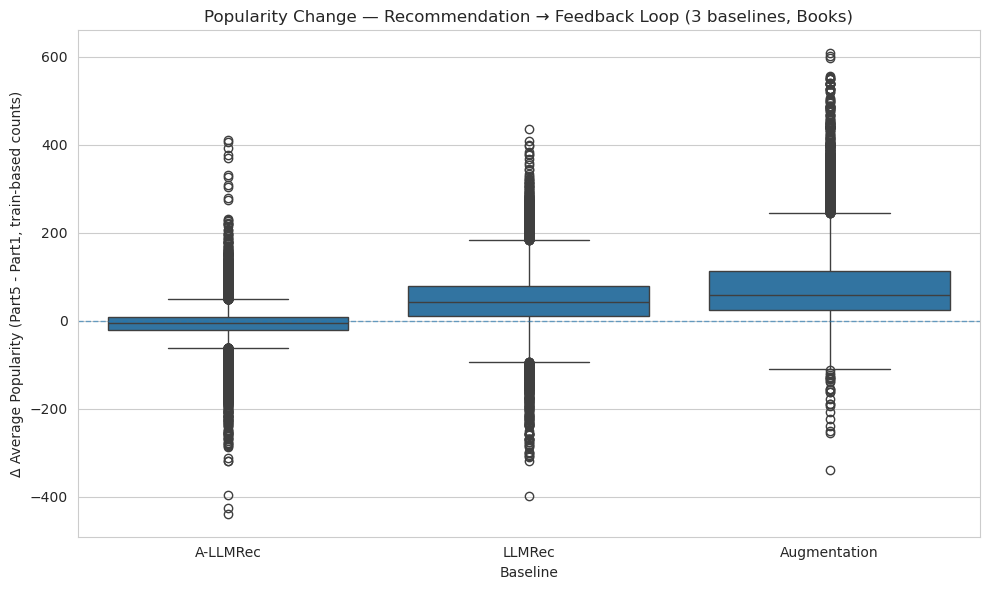

Summary (Δ Popularity = Part5 - Part1)
                count    mean     std    min    25%    50%      75%    max
baseline                                                                  
A-LLMRec      30754.0  -7.579  35.601 -439.0 -20.50  -5.50    7.429  412.0
Augmentation  31445.0  76.683  74.120 -339.0  23.25  58.60  112.250  608.0
LLMRec        31445.0  46.992  58.976 -399.0  10.10  42.65   79.778  437.0
plot is saved -> /home/parkdw00/Codes/data/books/plots/popularity_p1_to_p5.png


In [5]:
# ===== Books: Part1 -> Part5 (4 baselines) Popularity Change Boxplot =====
import os
import json
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# 0) Paths (Part1 predictions of 4 baselines)
# ---------------------------
BASELINES_P1 = {
    "A-LLMRec": "/home/parkdw00/Codes/A-LLMRec/books_results/predict_label_part1.json",
    "LLMRec": "/home/parkdw00/Codes/data/books/books_llmrec_format/predict_label_part1.json",
    "Augmentation": "/home/parkdw00/Codes/Augmentation/data/books/predict_label_part1.json",
    #"TraditionalCF": "/home/parkdw00/Codes/data/books/traditionalCF/predict_label_part1.json",
}

def part1_to_part5_path(p1_path: str) -> str:
    return p1_path.replace("predict_label_part1.json", "predict_label_part5.json")

BASELINES_P5 = {k: part1_to_part5_path(v) for k, v in BASELINES_P1.items()}

# ---------------------------
# 1) Popularity from train_data
# ---------------------------
def build_item_popularity(train_data: dict) -> Counter:
    item_pop = Counter()
    for items in train_data.values():
        for it in items:
            item_pop[int(it)] += 1
    return item_pop

item_pop = build_item_popularity(train_data)

# ---------------------------
# 2) Utilities
# ---------------------------
def load_json(path: str) -> dict:
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    with open(path, "r") as f:
        return json.load(f)

def avg_popularity_from_item_ids(user_items: dict, item_pop: Counter) -> dict[str, float]:
    """user_items: dict[uid]->list[item_id] (or int), return dict[str(uid)]->avg_popularity"""
    out = {}
    for uid, items in user_items.items():
        if items is None:
            out[str(uid)] = 0.0
            continue
        if isinstance(items, int):
            items = [items]
        ids = [int(x) for x in items]
        pops = [item_pop.get(it, 0) for it in ids]
        out[str(uid)] = float(np.mean(pops)) if len(pops) > 0 else 0.0
    return out

def filter_dict_by_users(d: dict, users: set[str]) -> dict:
    return {u: d[u] for u in users if u in d}

# ---------------------------
# 3) Common users base
#   - common_users: 기존 코드에서 쓰던 그대로 있다고 가정
# ---------------------------
common_users_base = set(map(str, common_users))
print("len(common_users_base):", len(common_users_base))

# ---------------------------
# 4) For each baseline: compute Δ (Part5 - Part1)
# ---------------------------
rows = []

for bname in BASELINES_P1.keys():
    p1_path = BASELINES_P1[bname]
    p5_path = BASELINES_P5[bname]

    pred_p1 = load_json(p1_path)
    pred_p5 = load_json(p5_path)

    pred_p1 = {str(k): v for k, v in pred_p1.items()}
    pred_p5 = {str(k): v for k, v in pred_p5.items()}

    # 이 baseline에서 Part1 & Part5 둘 다 있는 사용자만 + common_users
    users_b = common_users_base & set(pred_p1.keys()) & set(pred_p5.keys())

    # 사용자 필터
    p1_common = filter_dict_by_users(pred_p1, users_b)
    p5_common = filter_dict_by_users(pred_p5, users_b)

    # popularity metric
    m_p1 = avg_popularity_from_item_ids(p1_common, item_pop)
    m_p5 = avg_popularity_from_item_ids(p5_common, item_pop)

    # delta
    for u in users_b:
        p1v = m_p1.get(u, 0.0)
        p5v = m_p5.get(u, 0.0)
        rows.append({
            "uid": u,
            "baseline": bname,
            "delta": p5v - p1v,
            "metric": "Popularity",
            "case": "Books",
        })

    print(f"{bname}: users used = {len(users_b)}")
    print(f"  - p1: {p1_path}")
    print(f"  - p5: {p5_path}")

df_delta = pd.DataFrame(rows)
print("df_delta shape:", df_delta.shape)

# ---------------------------
# 5) Plot (single plot comparing 4 baselines)
# ---------------------------
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

ax = sns.boxplot(
    data=df_delta,
    x="baseline",
    y="delta",
    order=list(BASELINES_P1.keys()),
)

ax.set_title("Popularity Change — Recommendation → Feedback Loop (3 baselines, Books)")
ax.set_xlabel("Baseline")
ax.set_ylabel("Δ Average Popularity (Part5 - Part1, train-based counts)")
ax.axhline(0, linestyle="--", linewidth=1, alpha=0.6)

plt.tight_layout()
os.makedirs("/home/parkdw00/Codes/data/books/plots", exist_ok=True)
out_path = "/home/parkdw00/Codes/data/books/plots/popularity_p1_to_p5.png"
plt.savefig(out_path, dpi=300)
plt.show()

# ---------------------------
# 6) Summary
# ---------------------------
print("Summary (Δ Popularity = Part5 - Part1)")
print(df_delta.groupby("baseline")["delta"].describe().round(3))
print("plot is saved ->", out_path)


### Diversity

In [23]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os, json, math
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
import networkx as nx

# Louvain
import community as community_louvain  # pip install python-louvain

# =========================
# 경로/설정
# =========================
STEPS    = list(range(PARTS))
OUT_DIR  = os.path.join(BASE_DIR, "figs_tsne_cluster_progress")
os.makedirs(OUT_DIR, exist_ok=True)

TSNE_PERPLEXITY      = 30
TSNE_RANDOM_STATE    = 42
KMEANS_RANDOM_STATE  = 42
K_USERS = 2   # placeholder; Louvain 결과로 갱신
K_ITEMS = 2

SUBSAMPLE_USERS_FOR_TSNE = None
SUBSAMPLE_ITEMS_FOR_TSNE = None

# ===== 커뮤니티 탐지(그래프 구성) 설정 =====
USE_COSINE       = True        # Louvain용 가중치로 cosine 유사도 사용
SIM_THRESHOLD    = 0.5         # 간선 생성 임계값 (cosine sim >= threshold)
MAX_EDGES_PER_NODE = None      # 노드당 최대 간선 수 제한(예: 50). None이면 제한 없음.
EDGE_WEIGHT_NAME = "w"         # 가중치 속성명

# =========================
# 유틸
# =========================

def _get_items(d, uid):
    """
    d: {user_id: [items,...]} with user_id possibly str or int
    uid: int
    returns list of items (possibly empty)
    """
    if uid in d:
        return d[uid]
    suid = str(uid)
    if suid in d:
        return d[suid]
    return []

def build_user_item_graph_common(train_data, pred_dict, common_users,
                                 alpha: float = 0.3,
                                 drop_isolates: bool = True,
                                 min_degree: int | None = None) -> nx.Graph:
    """
    train_data + pred_dict로 user-item 이분 그래프 생성하되,
    user는 오직 common_users에 한정.

    - alpha: 예측 엣지 가중치
    - drop_isolates: 차수 0인 노드 제거
    - min_degree: 지정 시, 차수 < min_degree 노드 제거(반복 1회)

    return: networkx.Graph (무방향, 간선 속성 'w'에 가중치 저장)
    """
    # 1) 에지 가중치 누적(메모리 절약 + 합산 정확성)
    ew = defaultdict(float)  # key=(u_node, i_node) -> weight

    # 2) train 엣지
    for u in common_users:
        u = int(u)
        items = _get_items(train_data, u)
        for it in items:
            ew[(f"U{u}", f"I{int(it)}")] += 1.0

    # 3) predict 엣지
    for u in common_users:
        u = int(u)
        items = _get_items(pred_dict, u)
        for it in items:
            ew[(f"U{u}", f"I{int(it)}")] += alpha

    # 4) 그래프 구성
    G = nx.Graph()
    # add_edges_from with attributes
    G.add_nodes_from([f"U{u}" for u in common_users])  # 유저 노드는 미리 추가(고정 집합)
    G.add_edges_from([(u, i, {"w": w}) for (u, i), w in ew.items() if w > 0])

    # 5) 고립/저차수 노드 정리(옵션)
    if drop_isolates:
        iso = list(nx.isolates(G))
        if iso:
            G.remove_nodes_from(iso)
    if min_degree is not None and min_degree > 0:
        low = [n for n, d in dict(G.degree()).items() if d < min_degree]
        if low:
            G.remove_nodes_from(low)

    return G


def louvain_detect(G: nx.Graph, weight_name: str = "w"):
    """
    Louvain 커뮤니티 탐지 (임의 노드명 지원)
    return:
      node_order: List[hashable]        # 라벨 배열과 1:1로 매핑되는 노드 순서
      labels_arr: np.ndarray[int]       # node_order와 같은 순서의 커뮤니티 라벨(0..C-1)
      num_comms: int
      part: Dict[node, community_id]    # 원본 매핑(네가 직접 조회할 때 편함)
    """
    part = community_louvain.best_partition(G, weight=weight_name, random_state=42)
    # 라벨을 0..C-1로 압축
    uniq = {}
    cur = 0
    for n, c in part.items():
        if c not in uniq:
            uniq[c] = cur
            cur += 1
        part[n] = uniq[c]
    node_order = list(G.nodes())
    labels_arr = np.array([part[n] for n in node_order], dtype=int)
    return node_order, labels_arr, cur, part


def compute_centers(coords: np.ndarray, labels: np.ndarray, K: int):
    centers = {}
    for k in range(K):
        mask = (labels == k)
        if np.any(mask):
            centers[k] = coords[mask].mean(axis=0)
    return centers
# =========================
print("=== Part1 Louvain ===")
# G_users = build_user_item_graph(train_data, pred_p1, alpha=1.0)
G_users = build_user_item_graph_common(
    train_data=train_data,
    pred_dict=pred_p1,
    common_users=common_users,
    alpha=1.0,          # 예측 엣지 영향 강화
    drop_isolates=True,
    min_degree=None
)


print(f"Graph nodes={G_users.number_of_nodes()}, edges={G_users.number_of_edges()}")

# ---- (수정) Louvain 호출 및 결과 요약 ----
node_order, node_labels_final, K_USERS, part = louvain_detect(G_users, weight_name=EDGE_WEIGHT_NAME)
print(f"Diversity Score(Detected communities (total nodes) based): {1/K_USERS}")

# 커뮤니티 크기 출력
_, counts = np.unique(node_labels_final, return_counts=True)
print("Community sizes (all nodes U+I):", K_USERS, counts.tolist())


# =========================
print("\n=== Part5 Louvain ===")
#G_users = build_user_item_graph(train_data, pred_p5, alpha=1.0)
G_users = build_user_item_graph_common(
    train_data=train_data,
    pred_dict=pred_p5,
    common_users=common_users,
    alpha=1.0,          # 예측 엣지 영향 강화
    drop_isolates=True,
    min_degree=None
)

print(f"Graph nodes={G_users.number_of_nodes()}, edges={G_users.number_of_edges()}")

# ---- (수정) Louvain 호출 및 결과 요약 ----
node_order, node_labels_final, K_USERS, part = louvain_detect(G_users, weight_name=EDGE_WEIGHT_NAME)
print(f"Diversity Score(Detected communities (total nodes) based): {1/K_USERS}")

# 커뮤니티 크기 출력
_, counts = np.unique(node_labels_final, return_counts=True)
print("Community sizes (all nodes U+I):", K_USERS, counts.tolist())


=== Part1 Louvain ===
Graph nodes=53447, edges=859388
Diversity Score(Detected communities (total nodes) based): 0.045454545454545456
Community sizes (all nodes U+I): 22 [11158, 13180, 17235, 11354, 209, 194, 33, 5, 20, 6, 10, 2, 7, 7, 7, 2, 2, 3, 2, 6, 2, 3]

=== Part5 Louvain ===
Graph nodes=53655, edges=835853
Diversity Score(Detected communities (total nodes) based): 0.09090909090909091
Community sizes (all nodes U+I): 11 [9277, 11702, 17693, 10926, 2330, 943, 318, 115, 347, 2, 2]


In [8]:
import os
import numpy as np
from tqdm import tqdm

# ---------------------------
# 1) 아이템 임베딩 로드
# ---------------------------
def load_item_embeddings(base_dir: str, parts: int, step: int):
    """
    ipath = os.path.join(base_dir, f"item_emb_part{parts}_step{step}.npy")
    를 로드해서 (num_items, d) 배열 반환
    """
    ipath = os.path.join(base_dir, f"item_emb_part{parts}_step{step}.npy")
    if not os.path.exists(ipath):
        raise FileNotFoundError(ipath)
    I = np.load(ipath)
    if I.ndim != 2:
        raise ValueError(f"item_emb shape invalid: {I.shape}")
    return I

# ---------------------------
# 2) 헬퍼: pred_dict에서 유저 키 안전 조회
# ---------------------------
def _get_user_items(pred_dict, uid):
    if uid in pred_dict:
        return pred_dict[uid]
    suid = str(uid)
    if suid in pred_dict:
        return pred_dict[suid]
    return []

# ---------------------------
# 3) 사용자별 평균 코사인 유사도 계산
# ---------------------------
def avg_pairwise_cos_sim_for_user(item_ids, item_emb_norm):
    """
    item_ids: 추천된 item id 리스트(정수 or 문자열)
    item_emb_norm: (N, d) 정규화된 임베딩 (각 행 L2=1)
    return: 평균 코사인 유사도 (상삼각 평균). 유효 아이템 <2이면 np.nan
    """
    # 정수 캐스팅 + 중복 제거(추천 리스트 내 중복 아이템이 평균을 왜곡하지 않도록)
    try:
        idx = [int(x) for x in item_ids]
    except Exception:
        idx = []
    # 유효 범위만 유지
    N = item_emb_norm.shape[0]
    idx = [i for i in dict.fromkeys(idx) if 0 <= i < N]  # dict.fromkeys: 순서 보존 중복 제거

    m = len(idx)
    if m < 2:
        return np.nan

    V = item_emb_norm[idx]            # (m, d) 이미 정규화됨
    S = V @ V.T                       # (m, m) 코사인 유사도 행렬
    # 상삼각(diag 제외) 평균
    triu_idx = np.triu_indices(m, k=1)
    sims = S[triu_idx]
    return float(np.mean(sims)) if sims.size > 0 else np.nan

# ---------------------------
# 4) 메인: 사용자별/전체 평균 계산
# ---------------------------
def compute_rec_list_avg_cos_sim(
    pred_dict: dict,
    base_dir: str,
    parts: int,
    step: int,
    users: list | set | None = None,   # None이면 pred_dict의 모든 유저
    clip01: bool = True,               # 수치 오차 보정용 [0,1] 클리핑
):
    """
    반환:
      user2avg_sim: {user_id(int): 평균 코사인 유사도(낮을수록 다양)}
      global_mean: 전체 사용자 평균(na 제외)
      user2diversity: {user_id: 1 - avg_sim}  # 높을수록 다양
      global_div_mean: 전체 사용자 diversity 평균
    """
    # 1) 임베딩 로드 & 정규화
    I = load_item_embeddings(base_dir, parts, step)       # (num_items, d)
    norms = np.linalg.norm(I, axis=1, keepdims=True)
    norms[norms == 0] = 1.0
    In = I / norms

    # 2) 대상 사용자 집합
    if users is None:
        # pred_dict 키가 str/int 섞여있을 수 있으므로 모두 int 캐스팅 시도
        cand = []
        for k in pred_dict.keys():
            try:
                cand.append(int(k))
            except Exception:
                # int로 안 바뀌는 키는 스킵
                pass
        users = cand
    else:
        users = [int(u) for u in users]

    user2avg_sim = {}
    user2diversity = {}

    for u in tqdm(users, total=len(users)):
        items = _get_user_items(pred_dict, u)
        avg_sim = avg_pairwise_cos_sim_for_user(items, In)
        if np.isnan(avg_sim):
            user2avg_sim[u] = np.nan
            user2diversity[u] = np.nan
        else:
            if clip01:
                avg_sim = max(0.0, min(1.0, avg_sim))
            user2avg_sim[u] = avg_sim
            user2diversity[u] = 1.0 - avg_sim  # 점수 ↑ = 더 다양

    # 3) 전체 평균(na 제외)
    vals = np.array([v for v in user2avg_sim.values() if not np.isnan(v)], dtype=float)
    global_mean = float(vals.mean()) if vals.size > 0 else np.nan

    div_vals = np.array([v for v in user2diversity.values() if not np.isnan(v)], dtype=float)
    global_div_mean = float(div_vals.mean()) if div_vals.size > 0 else np.nan

    return user2avg_sim, global_mean, user2diversity, global_div_mean

# pred_dict: predict_label.json을 로드한 dict (user_id -> [item_ids...])
# base_dir, parts, step: 네 실험 경로/스텝

user2sim, mean_sim, user2div, mean_div = compute_rec_list_avg_cos_sim(
    pred_dict=pred_p1,
    base_dir=BASE_DIR,
    parts=1,
    step=0,      # 혹은 평가하고 싶은 step
    users=common_users,             # 또는 common_users로 한정하려면 users=common_users
    clip01=True
)

print(f"[Avg CosSim] 전체 사용자 평균: {mean_sim:.6f} (낮을수록 다양)")
print(f"[Diversity]  전체 사용자 평균: {mean_div:.6f} (높을수록 다양)")


user2sim, mean_sim, user2div, mean_div = compute_rec_list_avg_cos_sim(
    pred_dict=pred_p5,
    base_dir=BASE_DIR,
    parts=5,
    step=4,      # 혹은 평가하고 싶은 step
    users=common_users,             # 또는 common_users로 한정하려면 users=common_users
    clip01=True
)

print(f"[Avg CosSim] 전체 사용자 평균: {mean_sim:.6f} (낮을수록 다양)")
print(f"[Diversity]  전체 사용자 평균: {mean_div:.6f} (높을수록 다양)")

# 특정 사용자 u의 점수 확인
# print(user2sim[u], user2div[u])


NameError: name 'pred_p1' is not defined

# RQ4
피드백 루프로 생성된 임베딩으로 분터 발생할 수 있는 위험성 분석(양극화, 필터버블 등)

포함: LLMRec, A-LLMRec, Augmentation, TR_CF

## Polarization

### 5step 한번에

In [17]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os, json, math
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# =========================
# 경로/설정
# =========================
STEPS    = list(range(PARTS))
CLUSTER_STEP = STEPS[-1]              # 최종 step에서 KMeans 수행
OUT_DIR  = os.path.join(BASE_DIR, "figs_tsne_cluster_progress")
os.makedirs(OUT_DIR, exist_ok=True)

TSNE_PERPLEXITY      = 30
TSNE_RANDOM_STATE    = 42
KMEANS_RANDOM_STATE  = 42
K_USERS = 2
K_ITEMS = 2

# (선택) t-SNE 가속 샘플링
SUBSAMPLE_USERS_FOR_TSNE = None  # 예: 5000
SUBSAMPLE_ITEMS_FOR_TSNE = None  # 예: 5000

# =========================
# 유틸
# =========================
def load_users_items_for_step(base_dir: str, parts: int, step: int):
    upath = os.path.join(base_dir, f"user_emb_part{parts}_step{step}.npy")
    ipath = os.path.join(base_dir, f"item_emb_part{parts}_step{step}.npy")
    if not os.path.exists(upath):
        raise FileNotFoundError(upath)
    U = np.load(upath)  # shape: (num_users_step, d)
    I = np.load(ipath) if os.path.exists(ipath) else None  # shape: (num_items_step, d) or None
    if U.ndim != 2:
        raise ValueError(f"user_emb shape invalid at step{step}: {U.shape}")
    if I is not None and I.ndim != 2:
        raise ValueError(f"item_emb shape invalid at step{step}: {I.shape}")
    return U, I


def align_users_for_step(common_users, num_users_step: int) -> np.ndarray:
    """
    common_users: set/list/ndarray 모두 허용.
    num_users_step: 이 step의 user 축 길이 (ex. user_by_step[s].shape[0])
    return: [N_u'] 정렬된 유효 유저 id 배열
    """
    # 1) 입력을 넘파이 int64 배열로 통일
    if isinstance(common_users, (set, list, tuple)):
        cu = np.asarray(sorted(common_users), dtype=np.int64)  # 재현성 위해 정렬 권장
    else:
        cu = np.asarray(common_users, dtype=np.int64)

    if cu.size == 0:
        return cu

    # 2) 유효 범위 마스킹
    mask = (cu >= 0) & (cu < num_users_step)
    return cu[mask]


# =========================
# 1) 각 step 임베딩 로드
# =========================
print("Loading augmentation embeddings per step...")
user_by_step = {}
item_by_step = {}
dims = set()

for s in STEPS:
    U, I = load_users_items_for_step(BASE_DIR, PARTS, s)
    user_by_step[s] = U
    item_by_step[s] = I
    dims.add(U.shape[1])
    if I is not None:
        dims.add(I.shape[1])
    print(f"  - step{s}: users={U.shape}, items={None if I is None else I.shape}")

if len(dims) != 1:
    raise RuntimeError(f"임베딩 차원이 step별로 다릅니다: {dims}")
D = dims.pop()

# =========================
# 2) train∩label 공통 유저 산출 + step별 정렬
# =========================
print(f"common users: {len(common_users)}")

aligned_users_by_step = {s: align_users_for_step(common_users, user_by_step[s].shape[0])
                         for s in STEPS}
print({s: len(aligned_users_by_step[s]) for s in STEPS})

# =========================
# 3) 아이템 공통 부분 정렬(최소 길이)
# =========================
item_lengths = [item_by_step[s].shape[0] for s in STEPS if item_by_step[s] is not None]
if len(item_lengths) == 0:
    I_base = 0
else:
    I_base = min(item_lengths)
    uniq = set(item_lengths)
    if len(uniq) != 1:
        print(f"[warn] step별 아이템 수가 다릅니다: {uniq} → 앞에서 {I_base}개만 공통 사용")
    for s in STEPS:
        I = item_by_step[s]
        item_by_step[s] = None if I is None or I.shape[0] < I_base else I[:I_base]

rng = np.random.RandomState(0)
if I_base > 0:
    if SUBSAMPLE_ITEMS_FOR_TSNE is not None and SUBSAMPLE_ITEMS_FOR_TSNE < I_base:
        keep_items = np.sort(rng.choice(I_base, size=SUBSAMPLE_ITEMS_FOR_TSNE, replace=False))
    else:
        keep_items = np.arange(I_base)
else:
    keep_items = np.array([], dtype=int)

# =========================
# 4) 최종 step에서 KMeans → 레이블 생성
# =========================
print(f"KMeans on final step: step{CLUSTER_STEP}")
U_final = user_by_step[CLUSTER_STEP]
ids_final = aligned_users_by_step[CLUSTER_STEP]
if len(ids_final) < K_USERS:
    raise RuntimeError(f"최종 step에서 클러스터링 가능한 공통 유저가 부족합니다: {len(ids_final)}")

emb_final_users = U_final[ids_final, :]  # (|ids_final|, D)
user_kmeans = KMeans(n_clusters=K_USERS, random_state=KMEANS_RANDOM_STATE, n_init=10)
user_labels_final = user_kmeans.fit_predict(emb_final_users)
user_center_idx = {k: user_labels_final == k for k in range(K_USERS)}

# 아이템 KMeans (최종 step 공통 아이템)
if item_by_step[CLUSTER_STEP] is not None and len(keep_items) > 0:
    I_final = item_by_step[CLUSTER_STEP][keep_items]  # (|keep_items|, D)
    item_kmeans = KMeans(n_clusters=K_ITEMS, random_state=KMEANS_RANDOM_STATE, n_init=10)
    item_labels_final = item_kmeans.fit_predict(I_final)
else:
    item_kmeans = None
    item_labels_final = None
    print("[warn] 최종 step 아이템이 없어 item clustering 생략")

# =========================
# 5) t-SNE에 넣을 데이터 블록 구성 (users + items across steps)
# =========================
print("Preparing t-SNE blocks...")
ids_for_tsne = {}      # step -> user_id 배열(샘플링 반영)
users_for_tsne = {}    # step -> user_emb 배열
item_for_tsne  = {}    # step -> item_emb 배열 (공통 keep_items에 해당)

# 유저 샘플링 기준: 최종 step의 ids_final 집합
if SUBSAMPLE_USERS_FOR_TSNE is not None and SUBSAMPLE_USERS_FOR_TSNE < len(ids_final):
    sample_users = np.sort(rng.choice(ids_final, size=SUBSAMPLE_USERS_FOR_TSNE, replace=False))
else:
    sample_users = ids_final

for s in STEPS:
    ids_s = aligned_users_by_step[s]
    if len(ids_s) == 0:
        ids_for_tsne[s] = np.array([], dtype=np.int64)
        users_for_tsne[s] = np.empty((0, D), dtype=np.float32)
    else:
        mask = np.isin(ids_s, sample_users)
        ids_for_tsne[s] = ids_s[mask]
        users_for_tsne[s] = user_by_step[s][ids_for_tsne[s], :]

    I = item_by_step[s]
    item_for_tsne[s] = None if I is None or len(keep_items) == 0 else I[keep_items]

# =========================
# 6) t-SNE 수행 (모든 step의 유저/아이템 합쳐서)
# =========================
print("Fitting joint t-SNE on users + items across steps")
blocks = []
slices = {}  # step -> {"user": (st,en), "item": (st,en) or None}
cursor = 0

for s in STEPS:
    Ublk = users_for_tsne[s]
    blocks.append(Ublk)
    u_st, u_en = cursor, cursor + len(Ublk)
    cursor = u_en

    Iblk = item_for_tsne[s]
    if Iblk is not None and len(Iblk) > 0:
        blocks.append(Iblk)
        i_st, i_en = cursor, cursor + len(Iblk)
        cursor = i_en
        slices[s] = {"user": (u_st, u_en), "item": (i_st, i_en)}
    else:
        slices[s] = {"user": (u_st, u_en), "item": None}

if len(blocks) == 0 or sum(len(b) for b in blocks) < 3:
    raise RuntimeError("t-SNE에 사용할 표본이 너무 적습니다.")

X_all = np.vstack(blocks)
perp = min(TSNE_PERPLEXITY, max(5, (len(X_all) - 1)//3))
tsne = TSNE(
    n_components=2,
    perplexity=perp,
    init="pca",
    learning_rate="auto",
    random_state=TSNE_RANDOM_STATE,
    max_iter=1000,
    verbose=1
)
X_tsne = tsne.fit_transform(X_all)

# 좌표 범위(공통 축)
xmin, ymin = X_tsne.min(axis=0)
xmax, ymax = X_tsne.max(axis=0)
xpad = 0.05 * (xmax - xmin) if xmax > xmin else 0.5
ypad = 0.05 * (ymax - ymin) if ymax > ymin else 0.5

# 최종 step 중심 좌표(사용자/아이템)
palette = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple",
           "tab:brown","tab:pink","tab:gray","tab:olive","tab:cyan"]

def compute_centers(coords: np.ndarray, labels: np.ndarray, K: int):
    centers = {}
    for k in range(K):
        mask = (labels == k)
        if np.any(mask):
            centers[k] = coords[mask].mean(axis=0)
    return centers

# 최종 step 사용자/아이템 좌표 슬라이스
u_st_f, u_en_f = slices[CLUSTER_STEP]["user"]
coords_u_final = X_tsne[u_st_f:u_en_f]
# user_labels_final는 ids_final(=샘플링 전 최종 step 공통유저)에 대한 레이블
# t-SNE에는 sample_users만 포함됐을 수 있으므로, ids_for_tsne[CLUSTER_STEP] 순서에 맞춰 레이블 재정렬
ids_tsne_final = ids_for_tsne[CLUSTER_STEP]
# ids_tsne_final의 각 user_id가 ids_final 내에서의 index를 찾아 매핑
idx_map_final = {int(u): i for i, u in enumerate(ids_final.tolist())}
labels_u_for_plot = np.array([user_labels_final[idx_map_final[int(u)]] for u in ids_tsne_final], dtype=int)
user_centers = compute_centers(coords_u_final, labels_u_for_plot, K_USERS)

if slices[CLUSTER_STEP]["item"] is not None and item_labels_final is not None:
    i_st_f, i_en_f = slices[CLUSTER_STEP]["item"]
    coords_i_final = X_tsne[i_st_f:i_en_f]
    item_centers = compute_centers(coords_i_final, item_labels_final, K_ITEMS)
else:
    item_centers = {}

# =========================
# 7) 그림 저장 — Users only / Items only / Users+Items
# =========================
def plot_users_only():
    S = len(STEPS)
    cols = min(3, S)
    rows = math.ceil(S / cols)
    fig = plt.figure(figsize=(5*cols, 4*rows))
    for idx, s in enumerate(STEPS, start=1):
        ax = fig.add_subplot(rows, cols, idx)
        u_st, u_en = slices[s]["user"]
        coords_u = X_tsne[u_st:u_en]
        # 최종 step 기준 라벨로 색칠
        if s == CLUSTER_STEP:
            labels_plot = labels_u_for_plot
        else:
            # 다른 step은 같은 사용자(샘플링된 ids)에 대해 동일한 라벨을 사용
            # ids_for_tsne[s] -> ids_tsne_final로 매핑
            ids_tsne_s = ids_for_tsne[s]
            labels_plot = np.empty((len(ids_tsne_s),), dtype=int)
            for i, uid in enumerate(ids_tsne_s):
                labels_plot[i] = labels_u_for_plot[np.where(ids_tsne_final == uid)[0][0]]
        for k in range(K_USERS):
            mk = (labels_plot == k)
            if np.any(mk):
                ax.scatter(coords_u[mk,0], coords_u[mk,1], s=8, alpha=0.7,
                           c=palette[k % len(palette)], label=f"Users: C{k}")
        if s == CLUSTER_STEP:
            for k, ctr in user_centers.items():
                ax.scatter(ctr[0], ctr[1], s=120, marker="X",
                           c=palette[k % len(palette)], edgecolor="k")
        ax.set_title(f"step{s} (Users only, colored by step{CLUSTER_STEP})")
        ax.set_xticks([]); ax.set_yticks([])
        # 고정 축을 쓰고 싶으면 주석 해제
        # ax.set_xlim(xmin - xpad, xmax + xpad)
        # ax.set_ylim(ymin - ypad, ymax + ypad)
        if idx == 1:
            ax.legend(loc="best", frameon=True)
    plt.tight_layout()
    out = os.path.join(OUT_DIR, f"step{CLUSTER_STEP}_tsne2d_USERS_ONLY.png")
    plt.savefig(out, dpi=220); plt.close()
    print("  - saved:", out)

def plot_items_only():
    has_any = any(item_for_tsne[s] is not None for s in STEPS) and (item_labels_final is not None)
    if not has_any:
        print("  - Item only plot 생략(아이템 임베딩/라벨 없음)")
        return
    S = len(STEPS)
    cols = min(3, S)
    rows = math.ceil(S / cols)
    fig = plt.figure(figsize=(5*cols, 4*rows))
    for idx, s in enumerate(STEPS, start=1):
        ax = fig.add_subplot(rows, cols, idx)
        if slices[s]["item"] is not None:
            i_st, i_en = slices[s]["item"]
            coords_i = X_tsne[i_st:i_en]
            # 최종 step의 item_labels_final을 그대로 사용 (공통 keep_items에 대응)
            for k in range(K_ITEMS):
                mk = (item_labels_final == k)
                if np.any(mk):
                    ax.scatter(coords_i[mk,0], coords_i[mk,1], s=5, alpha=0.35,
                               c=palette[(k+2) % len(palette)], label=f"Items: C{k}")
            if s == CLUSTER_STEP and len(item_centers) > 0:
                for k, ctr in item_centers.items():
                    ax.scatter(ctr[0], ctr[1], s=110, marker="D",
                               c=palette[(k+2) % len(palette)], edgecolor="k")
        ax.set_title(f"step{s} (Items only, colored by step{CLUSTER_STEP})")
        ax.set_xticks([]); ax.set_yticks([])
        if idx == 1:
            ax.legend(loc="best", frameon=True)
    plt.tight_layout()
    out = os.path.join(OUT_DIR, f"step{CLUSTER_STEP}_tsne2d_ITEMS_ONLY.png")
    plt.savefig(out, dpi=220); plt.close()
    print("  - saved:", out)

def plot_users_items():
    S = len(STEPS)
    cols = min(3, S)
    rows = math.ceil(S / cols)
    fig = plt.figure(figsize=(5*cols, 4*rows))
    for idx, s in enumerate(STEPS, start=1):
        ax = fig.add_subplot(rows, cols, idx)
        # 아이템
        if slices[s]["item"] is not None and item_labels_final is not None:
            i_st, i_en = slices[s]["item"]
            coords_i = X_tsne[i_st:i_en]
            for k in range(K_ITEMS):
                mk = (item_labels_final == k)
                if np.any(mk):
                    ax.scatter(coords_i[mk,0], coords_i[mk,1], s=5, alpha=0.35,
                               c=palette[(k+2) % len(palette)], label=f"Items: C{k}")
            if s == CLUSTER_STEP and len(item_centers) > 0:
                for k, ctr in item_centers.items():
                    ax.scatter(ctr[0], ctr[1], s=110, marker="D",
                               c=palette[(k+2) % len(palette)], edgecolor="k")
        # 유저
        u_st, u_en = slices[s]["user"]
        coords_u = X_tsne[u_st:u_en]
        # step별 유저 라벨 구성
        if s == CLUSTER_STEP:
            labels_plot = labels_u_for_plot
        else:
            ids_tsne_s = ids_for_tsne[s]
            labels_plot = np.empty((len(ids_tsne_s),), dtype=int)
            for i, uid in enumerate(ids_tsne_s):
                labels_plot[i] = labels_u_for_plot[np.where(ids_tsne_final == uid)[0][0]]
        for k in range(K_USERS):
            mk = (labels_plot == k)
            if np.any(mk):
                ax.scatter(coords_u[mk,0], coords_u[mk,1], s=8, alpha=0.7,
                           c=palette[k % len(palette)], label=f"Users: C{k}")
        if s == CLUSTER_STEP:
            for k, ctr in user_centers.items():
                ax.scatter(ctr[0], ctr[1], s=120, marker="X",
                           c=palette[k % len(palette)], edgecolor="k")

        ax.set_title(f"step{s} (Users & Items, colored by step{CLUSTER_STEP})")
        ax.set_xlim(xmin - xpad, xmax + xpad)
        ax.set_ylim(ymin - ypad, ymax + ypad)
        ax.set_xticks([]); ax.set_yticks([])
        if idx == 1:
            ax.legend(loc="best", frameon=True)
    plt.tight_layout()
    out = os.path.join(OUT_DIR, f"step{CLUSTER_STEP}_tsne2d_USERS_ITEMS.png")
    plt.savefig(out, dpi=220); plt.close()
    print("  - saved:", out)

print("Plotting...")
plot_users_only()
plot_items_only()
plot_users_items()
print("Done.")


Loading augmentation embeddings per step...
  - step0: users=(32559, 50), items=(25879, 50)
  - step1: users=(32559, 50), items=(25879, 50)
  - step2: users=(32559, 50), items=(25879, 50)
  - step3: users=(32559, 50), items=(25879, 50)
  - step4: users=(32559, 50), items=(25879, 50)
common users: 31445
{0: 31445, 1: 31445, 2: 31445, 3: 31445, 4: 31445}
KMeans on final step: step4
Preparing t-SNE blocks...
Fitting joint t-SNE on users + items across steps
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 286620 samples in 0.008s...
[t-SNE] Computed neighbors for 286620 samples in 18.050s...
[t-SNE] Computed conditional probabilities for sample 1000 / 286620
[t-SNE] Computed conditional probabilities for sample 2000 / 286620
[t-SNE] Computed conditional probabilities for sample 3000 / 286620
[t-SNE] Computed conditional probabilities for sample 4000 / 286620
[t-SNE] Computed conditional probabilities for sample 5000 / 286620
[t-SNE] Computed conditional probabilities for sample 6

In [18]:
# ===== 9) Raw: 클러스터 중심 간 거리(step별) 계산 & 시각화 (t-SNE 제거, 2row×1col 하나의 figure) =====
import csv
import numpy as np
import matplotlib.pyplot as plt
import os
from itertools import combinations

# 전제: 위에서 다음 변수들이 이미 정의되어 있음
# - STEPS, CLUSTER_STEP, OUT_DIR
# - aligned_users_by_step, user_by_step
# - item_for_tsne (raw item embedding common subset), item_labels_final 또는 None
# - ids_final, user_labels_final
# - K_USERS, K_ITEMS

_user_label_map_final = {int(u): int(l) for u, l in zip(ids_final.tolist(), user_labels_final.tolist())}

def _labels_for_user_ids(user_ids: np.ndarray) -> np.ndarray:
    if len(user_ids) == 0:
        return np.empty((0,), dtype=int)
    out = np.full((len(user_ids),), -1, dtype=int)
    for i, u in enumerate(user_ids.tolist()):
        out[i] = _user_label_map_final.get(int(u), -1)
    return out

def _centers_from_points(points: np.ndarray, labels: np.ndarray, K: int) -> dict:
    centers = {}
    for k in range(K):
        m = (labels == k)
        centers[k] = points[m].mean(axis=0) if np.any(m) else None
    return centers

def _dist(a, b):
    if a is None or b is None:
        return np.nan
    return float(np.linalg.norm(a - b))

def _pairwise_center_stats(centers: dict):
    vecs = [v for v in centers.values() if v is not None]
    if len(vecs) < 2:
        return (np.nan, np.nan, np.nan)
    dists = [np.linalg.norm(a - b) for a, b in combinations(vecs, 2)]
    return (float(np.mean(dists)), float(np.min(dists)), float(np.max(dists)))

def _ui_stats(centers_u: dict, centers_i: dict):
    vec_u = [v for v in centers_u.values() if v is not None]
    vec_i = [v for v in centers_i.values() if v is not None]
    if len(vec_u) == 0 or len(vec_i) == 0:
        return (np.nan, np.nan, np.nan)
    d = []
    for u in vec_u:
        for i in vec_i:
            d.append(np.linalg.norm(u - i))
    return (float(np.mean(d)), float(np.min(d)), float(np.max(d)))

rows = []
for s in STEPS:
    # ---- raw space: user centers ----
    ids_u_raw = aligned_users_by_step[s]  # (Nr_s,)
    if len(ids_u_raw) > 0:
        emb_u_raw = user_by_step[s][ids_u_raw, :]
    else:
        emb_u_raw = np.empty((0, user_by_step[s].shape[1]))
    labels_u_raw = _labels_for_user_ids(ids_u_raw)
    centers_u_raw = _centers_from_points(emb_u_raw, labels_u_raw, K_USERS)

    # ---- raw space: item centers (keep_items common subset) ----
    if item_for_tsne[s] is not None and item_labels_final is not None:
        emb_i_raw = item_for_tsne[s]          # (Ni_common, d)
        labels_i_raw = item_labels_final      # (Ni_common,)
        centers_i_raw = _centers_from_points(emb_i_raw, labels_i_raw, K_ITEMS)
    else:
        centers_i_raw = {k: None for k in range(K_ITEMS)}

    # ---- summary stats (raw) ----
    uu_raw_mean, uu_raw_min, uu_raw_max = _pairwise_center_stats(centers_u_raw)
    ii_raw_mean, ii_raw_min, ii_raw_max = _pairwise_center_stats(centers_i_raw)

    row = {
        "step": s,
        "user_dist_raw_mean": uu_raw_mean,
        "user_dist_raw_min":  uu_raw_min,
        "user_dist_raw_max":  uu_raw_max,
        "item_dist_raw_mean": ii_raw_mean,
        "item_dist_raw_min":  ii_raw_min,
        "item_dist_raw_max":  ii_raw_max,
    }

    # K==2 상세
    if K_USERS == 2:
        row["user_dist_raw_U0U1"] = _dist(centers_u_raw.get(0), centers_u_raw.get(1))
    if K_ITEMS == 2:
        row["item_dist_raw_I0I1"] = _dist(centers_i_raw.get(0), centers_i_raw.get(1))

    # user-item distances (raw)
    if K_USERS == 2 and K_ITEMS == 2:
        row.update({
            "ui_raw_U0_I0": _dist(centers_u_raw.get(0), centers_i_raw.get(0)),
            "ui_raw_U0_I1": _dist(centers_u_raw.get(0), centers_i_raw.get(1)),
            "ui_raw_U1_I0": _dist(centers_u_raw.get(1), centers_i_raw.get(0)),
            "ui_raw_U1_I1": _dist(centers_u_raw.get(1), centers_i_raw.get(1)),
        })
    else:
        m, mn, mx = _ui_stats(centers_u_raw, centers_i_raw)
        row.update({
            "ui_raw_mean": m,
            "ui_raw_min":  mn,
            "ui_raw_max":  mx,
        })

    rows.append(row)

# ---- CSV 저장 ----
dist_csv = os.path.join(OUT_DIR, f"step{CLUSTER_STEP}_center_distances_over_steps_RAW_ONLY.csv")
with open(dist_csv, "w", newline="") as f:
    w = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
    w.writeheader()
    w.writerows(rows)
print(f"  - saved: {dist_csv}")

# ---- Plot: 2row×1col in ONE figure (raw only) ----
steps_ax = [r["step"] for r in rows]

ud_r_mean = [r["user_dist_raw_mean"] for r in rows]
id_r_mean = [r["item_dist_raw_mean"] for r in rows]

fig, axes = plt.subplots(2, 1, figsize=(9, 7), sharex=True)

# (row 1) user-user / item-item raw mean
axes[0].plot(steps_ax, ud_r_mean, marker="o", label="Users (raw, mean)")
axes[0].plot(steps_ax, id_r_mean, marker="o", label="Items (raw, mean)")
axes[0].set_ylabel("Center distance")
axes[0].set_title("User/User & Item/Item center distance over steps (raw)")
axes[0].legend()

# (row 2) user-item raw
if K_USERS == 2 and K_ITEMS == 2:
    ui_raw_u0i0 = [r.get("ui_raw_U0_I0", np.nan) for r in rows]
    ui_raw_u0i1 = [r.get("ui_raw_U0_I1", np.nan) for r in rows]
    ui_raw_u1i0 = [r.get("ui_raw_U1_I0", np.nan) for r in rows]
    ui_raw_u1i1 = [r.get("ui_raw_U1_I1", np.nan) for r in rows]

    axes[1].plot(steps_ax, ui_raw_u0i0, marker="s", label="U0–I0 (raw)")
    axes[1].plot(steps_ax, ui_raw_u0i1, marker="s", label="U0–I1 (raw)")
    axes[1].plot(steps_ax, ui_raw_u1i0, marker="s", label="U1–I0 (raw)")
    axes[1].plot(steps_ax, ui_raw_u1i1, marker="s", label="U1–I1 (raw)")
    axes[1].legend(ncol=2)
else:
    ui_raw_mean = [r.get("ui_raw_mean", np.nan) for r in rows]
    ui_raw_min  = [r.get("ui_raw_min",  np.nan) for r in rows]
    ui_raw_max  = [r.get("ui_raw_max",  np.nan) for r in rows]

    axes[1].plot(steps_ax, ui_raw_mean, marker="s", label="mean (raw)")
    axes[1].plot(steps_ax, ui_raw_min,  marker="s", label="min (raw)")
    axes[1].plot(steps_ax, ui_raw_max,  marker="s", label="max (raw)")
    axes[1].legend()

axes[1].set_xlabel("Step")
axes[1].set_ylabel("Center distance")
axes[1].set_title("User–Item center distances over steps (raw)")

plt.tight_layout()
dist_png = os.path.join(OUT_DIR, f"step{CLUSTER_STEP}_center_distances_over_steps_RAW_ONLY.png")
plt.savefig(dist_png, dpi=220)
plt.close()
print(f"  - saved: {dist_png}")


  - saved: /home/parkdw00/Codes/A-LLMRec/books_results/figs_tsne_cluster_progress/step4_center_distances_over_steps_RAW_ONLY.csv
  - saved: /home/parkdw00/Codes/A-LLMRec/books_results/figs_tsne_cluster_progress/step4_center_distances_over_steps_RAW_ONLY.png


### 1스텝별로

In [14]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os, math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# ============================================================
# 사용자 환경에서 미리 정의되어 있어야 하는 값들
#   - BASE_DIR: 임베딩(.npy)들이 있는 디렉토리
#   - PARTS: step 개수 (예: 5)
#   - common_users: train∩label 공통 유저 id 집합/리스트/ndarray
# ============================================================
# BASE_DIR = "..."
# PARTS = 5
# common_users = ...

# =========================
# 경로/설정
# =========================
STEPS = list(range(PARTS))
CLUSTER_STEP = STEPS[-1]  # 최종 step에서 KMeans 수행
OUT_DIR = os.path.join(BASE_DIR, "figs_tsne_cluster_progress")
os.makedirs(OUT_DIR, exist_ok=True)

TSNE_PERPLEXITY = 30
TSNE_RANDOM_STATE = 42
KMEANS_RANDOM_STATE = 42
K_USERS = 2
K_ITEMS = 2

# (선택) t-SNE 가속 샘플링
SUBSAMPLE_USERS_FOR_TSNE = None  # 예: 5000
SUBSAMPLE_ITEMS_FOR_TSNE = None  # 예: 5000

# (전역) t-SNE 2D에서 중심으로부터 거리 상위 p%를 "플로팅에서만" 제거
GLOBAL_TRIM_TOP_PCT = 0.0   # 전역 trimming 원하면 0.005 등으로 (0이면 전역 trim off)

# (핵심) step별(local) trimming: step1의 외딴 점 같은 걸 제거
STEP_TRIM_TOP_PCT = 0.01        # 기본: 각 step에서 상위 0.2% 제거
STEP_TRIM_TOP_PCT_STEP1 = 0.01  # step==1만 더 세게(0.5%) 제거

# =========================
# 유틸
# =========================
def load_users_items_for_step(base_dir: str, parts: int, step: int):
    upath = os.path.join(base_dir, f"user_emb_part{parts}_step{step}.npy")
    ipath = os.path.join(base_dir, f"item_emb_part{parts}_step{step}.npy")
    if not os.path.exists(upath):
        raise FileNotFoundError(upath)
    U = np.load(upath)  # (num_users_step, d)
    I = np.load(ipath) if os.path.exists(ipath) else None  # (num_items_step, d) or None
    if U.ndim != 2:
        raise ValueError(f"user_emb shape invalid at step{step}: {U.shape}")
    if I is not None and I.ndim != 2:
        raise ValueError(f"item_emb shape invalid at step{step}: {I.shape}")
    return U, I


def align_users_for_step(common_users, num_users_step: int) -> np.ndarray:
    if isinstance(common_users, (set, list, tuple)):
        cu = np.asarray(sorted(common_users), dtype=np.int64)
    else:
        cu = np.asarray(common_users, dtype=np.int64)

    if cu.size == 0:
        return cu

    mask = (cu >= 0) & (cu < num_users_step)
    return cu[mask]


def compute_centers(coords: np.ndarray, labels: np.ndarray, K: int):
    centers = {}
    for k in range(K):
        mk = (labels == k)
        if np.any(mk):
            centers[k] = coords[mk].mean(axis=0)
    return centers


def stepwise_trim_mask(coords2d: np.ndarray, top_pct: float) -> np.ndarray:
    """
    coords2d: (N,2)
    top_pct: 이 step에서 중심으로부터 거리 상위 top_pct 제거 (plot-only)
    return: keep mask (True=keep)
    """
    n = 0 if coords2d is None else len(coords2d)
    if n == 0:
        return np.zeros((0,), dtype=bool)
    if top_pct is None or top_pct <= 0:
        return np.ones((n,), dtype=bool)
    if top_pct >= 1.0:
        return np.zeros((n,), dtype=bool)

    ctr = np.median(coords2d, axis=0)
    dist = np.linalg.norm(coords2d - ctr, axis=1)

    q = 1.0 - top_pct
    q = min(max(q, 0.0), 1.0)
    thr = np.quantile(dist, q)
    return dist <= thr


# =========================
# 1) 각 step 임베딩 로드
# =========================
print("Loading augmentation embeddings per step...")
user_by_step = {}
item_by_step = {}
dims = set()

for s in STEPS:
    U, I = load_users_items_for_step(BASE_DIR, PARTS, s)
    user_by_step[s] = U
    item_by_step[s] = I
    dims.add(U.shape[1])
    if I is not None:
        dims.add(I.shape[1])
    print(f"  - step{s}: users={U.shape}, items={None if I is None else I.shape}")

if len(dims) != 1:
    raise RuntimeError(f"임베딩 차원이 step별로 다릅니다: {dims}")
D = dims.pop()

# =========================
# 2) train∩label 공통 유저 산출 + step별 정렬
# =========================
print(f"common users: {len(common_users)}")
aligned_users_by_step = {
    s: align_users_for_step(common_users, user_by_step[s].shape[0])
    for s in STEPS
}
print({s: len(aligned_users_by_step[s]) for s in STEPS})

# =========================
# 3) 아이템 공통 부분 정렬(최소 길이)
# =========================
item_lengths = [item_by_step[s].shape[0] for s in STEPS if item_by_step[s] is not None]
if len(item_lengths) == 0:
    I_base = 0
else:
    I_base = min(item_lengths)
    uniq = set(item_lengths)
    if len(uniq) != 1:
        print(f"[warn] step별 아이템 수가 다릅니다: {uniq} → 앞에서 {I_base}개만 공통 사용")
    for s in STEPS:
        I = item_by_step[s]
        item_by_step[s] = None if (I is None or I.shape[0] < I_base) else I[:I_base]

rng = np.random.RandomState(0)
if I_base > 0:
    if SUBSAMPLE_ITEMS_FOR_TSNE is not None and SUBSAMPLE_ITEMS_FOR_TSNE < I_base:
        keep_items = np.sort(rng.choice(I_base, size=SUBSAMPLE_ITEMS_FOR_TSNE, replace=False))
    else:
        keep_items = np.arange(I_base, dtype=int)
else:
    keep_items = np.array([], dtype=int)

# =========================
# 4) 최종 step에서 KMeans → 레이블 생성
# =========================
print(f"KMeans on final step: step{CLUSTER_STEP}")
U_final = user_by_step[CLUSTER_STEP]
ids_final = aligned_users_by_step[CLUSTER_STEP]
if len(ids_final) < K_USERS:
    raise RuntimeError(f"최종 step에서 클러스터링 가능한 공통 유저가 부족합니다: {len(ids_final)}")

emb_final_users = U_final[ids_final, :]  # (|ids_final|, D)
user_kmeans = KMeans(n_clusters=K_USERS, random_state=KMEANS_RANDOM_STATE, n_init=10)
user_labels_final_full = user_kmeans.fit_predict(emb_final_users)  # ids_final 순서 기준

# 아이템 KMeans (최종 step 공통 아이템)
if item_by_step[CLUSTER_STEP] is not None and len(keep_items) > 0:
    I_final = item_by_step[CLUSTER_STEP][keep_items, :]  # (|keep_items|, D)
    item_kmeans = KMeans(n_clusters=K_ITEMS, random_state=KMEANS_RANDOM_STATE, n_init=10)
    item_labels_final_full = item_kmeans.fit_predict(I_final)  # keep_items 순서 기준
else:
    item_kmeans = None
    item_labels_final_full = None
    print("[warn] 최종 step 아이템이 없어 item clustering 생략")

# ids_final uid -> label 매핑 (최종 step 기준)
uid2label = {int(uid): int(lb) for uid, lb in zip(ids_final.tolist(), user_labels_final_full.tolist())}

# =========================
# 5) t-SNE에 넣을 데이터 블록 구성 (users + items across steps)
# =========================
print("Preparing t-SNE blocks...")
ids_for_tsne = {}      # step -> user_id 배열(샘플링 반영)
users_for_tsne = {}    # step -> user_emb 배열
item_for_tsne  = {}    # step -> item_emb 배열 (공통 keep_items에 해당)

# 유저 샘플링 기준: 최종 step의 ids_final 집합
if SUBSAMPLE_USERS_FOR_TSNE is not None and SUBSAMPLE_USERS_FOR_TSNE < len(ids_final):
    sample_users = np.sort(rng.choice(ids_final, size=SUBSAMPLE_USERS_FOR_TSNE, replace=False))
else:
    sample_users = ids_final

for s in STEPS:
    ids_s = aligned_users_by_step[s]
    if len(ids_s) == 0:
        ids_for_tsne[s] = np.array([], dtype=np.int64)
        users_for_tsne[s] = np.empty((0, D), dtype=np.float32)
    else:
        mask = np.isin(ids_s, sample_users)
        ids_for_tsne[s] = ids_s[mask]
        users_for_tsne[s] = user_by_step[s][ids_for_tsne[s], :]

    I = item_by_step[s]
    item_for_tsne[s] = None if (I is None or len(keep_items) == 0) else I[keep_items, :]

# =========================
# 6) t-SNE 수행 (모든 step의 유저/아이템 합쳐서)
# =========================
print("Fitting joint t-SNE on users + items across steps")
blocks = []
slices = {}  # step -> {"user": (st,en), "item": (st,en) or None}
cursor = 0

for s in STEPS:
    Ublk = users_for_tsne[s]
    blocks.append(Ublk)
    u_st, u_en = cursor, cursor + len(Ublk)
    cursor = u_en

    Iblk = item_for_tsne[s]
    if Iblk is not None and len(Iblk) > 0:
        blocks.append(Iblk)
        i_st, i_en = cursor, cursor + len(Iblk)
        cursor = i_en
        slices[s] = {"user": (u_st, u_en), "item": (i_st, i_en)}
    else:
        slices[s] = {"user": (u_st, u_en), "item": None}

if len(blocks) == 0 or sum(len(b) for b in blocks) < 3:
    raise RuntimeError("t-SNE에 사용할 표본이 너무 적습니다.")

X_all = np.vstack(blocks)
perp = min(TSNE_PERPLEXITY, max(5, (len(X_all) - 1)//3))
tsne = TSNE(
    n_components=2,
    perplexity=perp,
    init="pca",
    learning_rate="auto",
    random_state=TSNE_RANDOM_STATE,
    max_iter=1000,
    verbose=1
)
X_tsne = tsne.fit_transform(X_all)

# =========================
# (선택) 전역 trimming (plot-only)
# =========================
if GLOBAL_TRIM_TOP_PCT is not None and GLOBAL_TRIM_TOP_PCT > 0:
    ctr2d = np.median(X_tsne, axis=0)
    dist2d = np.linalg.norm(X_tsne - ctr2d, axis=1)
    thr = np.quantile(dist2d, 1.0 - GLOBAL_TRIM_TOP_PCT)
    global_keep_mask = dist2d <= thr
    print(f"[global-trim] keep {global_keep_mask.sum()}/{len(global_keep_mask)} "
          f"({100.0 * global_keep_mask.mean():.2f}%) points")
else:
    global_keep_mask = np.ones((X_tsne.shape[0],), dtype=bool)

# 축 범위: 전역 keep 기준(없으면 전체)
X_plot = X_tsne[global_keep_mask]
xmin, ymin = X_plot.min(axis=0)
xmax, ymax = X_plot.max(axis=0)
xpad = 0.05 * (xmax - xmin) if xmax > xmin else 0.5
ypad = 0.05 * (ymax - ymin) if ymax > ymin else 0.5

palette = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple",
           "tab:brown","tab:pink","tab:gray","tab:olive","tab:cyan"]

# =========================
# 6.5) 최종 step 사용자/아이템의 (plot용) 라벨/센터 준비
#     - center 계산도 trimming(전역/로컬) 적용해서 일관되게
# =========================
# final users slice
u_st_f, u_en_f = slices[CLUSTER_STEP]["user"]
coords_u_final_all = X_tsne[u_st_f:u_en_f]
ids_tsne_final_all = ids_for_tsne[CLUSTER_STEP]
labels_u_final_all = np.array([uid2label[int(uid)] for uid in ids_tsne_final_all], dtype=int)

# 전역 trim 적용
g_keep_u_f = global_keep_mask[u_st_f:u_en_f]
coords_u_final_g = coords_u_final_all[g_keep_u_f]
ids_tsne_final_g = ids_tsne_final_all[g_keep_u_f]
labels_u_final_g = labels_u_final_all[g_keep_u_f]

# 최종 step에 대해 로컬 trim도 적용 (기본 step 규칙)
local_pct_f = STEP_TRIM_TOP_PCT_STEP1 if CLUSTER_STEP == 1 else STEP_TRIM_TOP_PCT
l_keep_u_f = stepwise_trim_mask(coords_u_final_g, top_pct=local_pct_f)
coords_u_final = coords_u_final_g[l_keep_u_f]
ids_tsne_final = ids_tsne_final_g[l_keep_u_f]
labels_u_for_plot = labels_u_final_g[l_keep_u_f]

user_centers = compute_centers(coords_u_final, labels_u_for_plot, K_USERS)

# final items slice
if slices[CLUSTER_STEP]["item"] is not None and item_labels_final_full is not None:
    i_st_f, i_en_f = slices[CLUSTER_STEP]["item"]
    coords_i_final_all = X_tsne[i_st_f:i_en_f]
    labels_i_final_all = item_labels_final_full

    # 전역 trim
    g_keep_i_f = global_keep_mask[i_st_f:i_en_f]
    coords_i_final_g = coords_i_final_all[g_keep_i_f]
    labels_i_final_g = labels_i_final_all[g_keep_i_f]

    # 로컬 trim(최종 step)
    local_pct_i_f = STEP_TRIM_TOP_PCT_STEP1 if CLUSTER_STEP == 1 else STEP_TRIM_TOP_PCT
    l_keep_i_f = stepwise_trim_mask(coords_i_final_g, top_pct=local_pct_i_f)
    coords_i_final = coords_i_final_g[l_keep_i_f]
    labels_i_final = labels_i_final_g[l_keep_i_f]

    item_centers = compute_centers(coords_i_final, labels_i_final, K_ITEMS)
else:
    item_centers = {}

# final uid -> position (trimmed final 기준)
pos_map_final = {int(uid): i for i, uid in enumerate(ids_tsne_final.tolist())}

# =========================
# 7) 그림 저장 — Users only / Items only / Users+Items
# =========================
def plot_users_only():
    step_dir = os.path.join(OUT_DIR, "step_by_step")
    os.makedirs(step_dir, exist_ok=True)

    S = len(STEPS)
    cols = min(3, S)
    rows = math.ceil(S / cols)
    fig = plt.figure(figsize=(5*cols, 4*rows))

    for idx, s in enumerate(STEPS, start=1):
        ax = fig.add_subplot(rows, cols, idx)
        fig_s, ax_s = plt.subplots(figsize=(6, 5))

        u_st, u_en = slices[s]["user"]
        coords_u_all = X_tsne[u_st:u_en]
        ids_tsne_s_all = ids_for_tsne[s]

        if len(ids_tsne_s_all) == 0:
            ax.set_xticks([]); ax.set_yticks([])
            plt.close(fig_s)
            continue

        # (1) 전역 trim
        g_keep = global_keep_mask[u_st:u_en]
        coords_u_g = coords_u_all[g_keep]
        ids_u_g = ids_tsne_s_all[g_keep]

        if len(ids_u_g) == 0:
            ax.set_xticks([]); ax.set_yticks([])
            plt.close(fig_s)
            continue

        # (2) step별 로컬 trim
        local_pct = STEP_TRIM_TOP_PCT_STEP1 if s == 1 else STEP_TRIM_TOP_PCT
        l_keep = stepwise_trim_mask(coords_u_g, top_pct=local_pct)
        coords_u = coords_u_g[l_keep]
        ids_tsne_s = ids_u_g[l_keep]

        if len(ids_tsne_s) == 0:
            ax.set_xticks([]); ax.set_yticks([])
            plt.close(fig_s)
            continue

        # final 기준 라벨로 색칠: final에 없는 uid는 버림
        valid_mask = np.array([int(uid) in pos_map_final for uid in ids_tsne_s], dtype=bool)
        coords_valid = coords_u[valid_mask]
        ids_valid = ids_tsne_s[valid_mask]

        if len(ids_valid) == 0:
            ax.set_xticks([]); ax.set_yticks([])
            plt.close(fig_s)
            continue

        labels_plot = np.array([labels_u_for_plot[pos_map_final[int(uid)]] for uid in ids_valid], dtype=int)

        for k in range(K_USERS):
            mk = (labels_plot == k)
            if np.any(mk):
                ax.scatter(coords_valid[mk, 0], coords_valid[mk, 1],
                           s=8, alpha=0.7, c=palette[k % len(palette)],
                           label=f"Users: C{k}")
                ax_s.scatter(coords_valid[mk, 0], coords_valid[mk, 1],
                             s=10, alpha=0.7, c=palette[k % len(palette)],
                             label=f"Users: C{k}")

        if s == CLUSTER_STEP:
            for k, ctr in user_centers.items():
                ax.scatter(ctr[0], ctr[1], s=120, marker="X",
                           c=palette[k % len(palette)], edgecolor="k")

        for a in (ax, ax_s):
            #a.set_xlim(xmin - xpad, xmax + xpad)
            #a.set_ylim(ymin - ypad, ymax + ypad)
            a.set_xticks([]); a.set_yticks([])

        if idx == 1:
            ax.legend(loc="best", frameon=True)
        ax_s.legend(loc="best", frameon=True)

        fig_s.tight_layout()
        out_s = os.path.join(step_dir, f"step{s}_tsne2d_USERS_ONLY.png")
        fig_s.savefig(out_s, dpi=220)
        plt.close(fig_s)
        print("  - saved:", out_s)

    fig.tight_layout()
    out = os.path.join(OUT_DIR, f"step{CLUSTER_STEP}_tsne2d_USERS_ONLY.png")
    fig.savefig(out, dpi=220)
    plt.close(fig)
    print("  - saved:", out)


def plot_items_only():
    has_any = any(item_for_tsne[s] is not None for s in STEPS) and (item_labels_final_full is not None)
    if not has_any:
        print("  - Item only plot 생략(아이템 임베딩/라벨 없음)")
        return

    step_dir = os.path.join(OUT_DIR, "step_by_step")
    os.makedirs(step_dir, exist_ok=True)

    S = len(STEPS)
    cols = min(3, S)
    rows = math.ceil(S / cols)
    fig = plt.figure(figsize=(5*cols, 4*rows))

    for idx, s in enumerate(STEPS, start=1):
        ax = fig.add_subplot(rows, cols, idx)
        fig_s, ax_s = plt.subplots(figsize=(5, 4))

        if slices[s]["item"] is not None:
            i_st, i_en = slices[s]["item"]
            coords_i_all = X_tsne[i_st:i_en]
            labels_i_all = item_labels_final_full

            # (1) 전역 trim
            g_keep = global_keep_mask[i_st:i_en]
            coords_i_g = coords_i_all[g_keep]
            labels_i_g = labels_i_all[g_keep]

            # (2) step별 로컬 trim
            local_pct = STEP_TRIM_TOP_PCT_STEP1 if s == 1 else STEP_TRIM_TOP_PCT
            l_keep = stepwise_trim_mask(coords_i_g, top_pct=local_pct)
            coords_i = coords_i_g[l_keep]
            labels_i = labels_i_g[l_keep]

            if len(coords_i) > 0:
                for k in range(K_ITEMS):
                    mk = (labels_i == k)
                    if np.any(mk):
                        ax.scatter(coords_i[mk, 0], coords_i[mk, 1],
                                   s=5, alpha=0.35, c=palette[(k+2) % len(palette)],
                                   label=f"Items: C{k}")
                        ax_s.scatter(coords_i[mk, 0], coords_i[mk, 1],
                                     s=5, alpha=0.35, c=palette[(k+2) % len(palette)],
                                     label=f"Items: C{k}")

                if s == CLUSTER_STEP and len(item_centers) > 0:
                    for k, ctr in item_centers.items():
                        ax.scatter(ctr[0], ctr[1], s=110, marker="D",
                                   c=palette[(k+2) % len(palette)], edgecolor="k")

        for a in (ax, ax_s):
            #a.set_xlim(xmin - xpad, xmax + xpad)
            #a.set_ylim(ymin - ypad, ymax + ypad)
            a.set_xticks([]); a.set_yticks([])

        if idx == 1:
            ax.legend(loc="best", frameon=True)
        ax_s.legend(loc="best", frameon=True)

        fig_s.tight_layout()
        out_s = os.path.join(step_dir, f"step{s}_tsne2d_ITEMS_ONLY.png")
        fig_s.savefig(out_s, dpi=220)
        plt.close(fig_s)
        print("  - saved:", out_s)

    fig.tight_layout()
    out = os.path.join(OUT_DIR, f"step{CLUSTER_STEP}_tsne2d_ITEMS_ONLY.png")
    fig.savefig(out, dpi=220)
    plt.close(fig)
    print("  - saved:", out)


def plot_users_items():
    step_dir = os.path.join(OUT_DIR, "step_by_step")
    os.makedirs(step_dir, exist_ok=True)

    S = len(STEPS)
    cols = min(3, S)
    rows = math.ceil(S / cols)
    fig = plt.figure(figsize=(5*cols, 4*rows))

    for idx, s in enumerate(STEPS, start=1):
        ax = fig.add_subplot(rows, cols, idx)

        # 아이템
        if slices[s]["item"] is not None and item_labels_final_full is not None:
            i_st, i_en = slices[s]["item"]
            coords_i_all = X_tsne[i_st:i_en]
            labels_i_all = item_labels_final_full

            # (1) 전역 trim
            g_keep = global_keep_mask[i_st:i_en]
            coords_i_g = coords_i_all[g_keep]
            labels_i_g = labels_i_all[g_keep]

            # (2) step별 로컬 trim
            local_pct = STEP_TRIM_TOP_PCT_STEP1 if s == 1 else STEP_TRIM_TOP_PCT
            l_keep = stepwise_trim_mask(coords_i_g, top_pct=local_pct)
            coords_i = coords_i_g[l_keep]
            labels_i = labels_i_g[l_keep]

            if len(coords_i) > 0:
                for k in range(K_ITEMS):
                    mk = (labels_i == k)
                    if np.any(mk):
                        ax.scatter(coords_i[mk, 0], coords_i[mk, 1],
                                   s=5, alpha=0.35, c=palette[(k+2) % len(palette)],
                                   label=f"Items: C{k}")
                if s == CLUSTER_STEP and len(item_centers) > 0:
                    for k, ctr in item_centers.items():
                        ax.scatter(ctr[0], ctr[1], s=110, marker="D",
                                   c=palette[(k+2) % len(palette)], edgecolor="k")

        # 유저
        u_st, u_en = slices[s]["user"]
        coords_u_all = X_tsne[u_st:u_en]
        ids_tsne_s_all = ids_for_tsne[s]

        if len(ids_tsne_s_all) > 0:
            # (1) 전역 trim
            g_keep = global_keep_mask[u_st:u_en]
            coords_u_g = coords_u_all[g_keep]
            ids_u_g = ids_tsne_s_all[g_keep]

            # (2) step별 로컬 trim
            local_pct = STEP_TRIM_TOP_PCT_STEP1 if s == 1 else STEP_TRIM_TOP_PCT
            l_keep = stepwise_trim_mask(coords_u_g, top_pct=local_pct)
            coords_u = coords_u_g[l_keep]
            ids_tsne_s = ids_u_g[l_keep]

            # final 기준 라벨로 색칠 (final에 없는 uid는 버림)
            valid_mask = np.array([int(uid) in pos_map_final for uid in ids_tsne_s], dtype=bool)
            coords_valid = coords_u[valid_mask]
            ids_valid = ids_tsne_s[valid_mask]

            if len(ids_valid) > 0:
                labels_plot = np.array(
                    [labels_u_for_plot[pos_map_final[int(uid)]] for uid in ids_valid],
                    dtype=int
                )

                for k in range(K_USERS):
                    mk = (labels_plot == k)
                    if np.any(mk):
                        ax.scatter(coords_valid[mk, 0], coords_valid[mk, 1],
                                   s=8, alpha=0.7, c=palette[k % len(palette)],
                                   label=f"Users: C{k}")

                if s == CLUSTER_STEP:
                    for k, ctr in user_centers.items():
                        ax.scatter(ctr[0], ctr[1], s=120, marker="X",
                                   c=palette[k % len(palette)], edgecolor="k")

        ax.set_title(f"step{s} (Users & Items, colored by step{CLUSTER_STEP})")
        #ax.set_xlim(xmin - xpad, xmax + xpad)
        #ax.set_ylim(ymin - ypad, ymax + ypad)
        ax.set_xticks([]); ax.set_yticks([])

        if idx == 1:
            ax.legend(loc="best", frameon=True)

    fig.tight_layout()
    out = os.path.join(OUT_DIR, f"step{CLUSTER_STEP}_tsne2d_USERS_ITEMS.png")
    fig.savefig(out, dpi=220)
    plt.close(fig)
    print("  - saved:", out)


print("Plotting...")
plot_users_only()
plot_items_only()
plot_users_items()
print("Done.")


Loading augmentation embeddings per step...
  - step0: users=(32559, 50), items=(25879, 50)
  - step1: users=(32559, 50), items=(25879, 50)
  - step2: users=(32559, 50), items=(25879, 50)
  - step3: users=(32559, 50), items=(25879, 50)
  - step4: users=(32559, 50), items=(25879, 50)
common users: 31445
{0: 31445, 1: 31445, 2: 31445, 3: 31445, 4: 31445}
KMeans on final step: step4
Preparing t-SNE blocks...
Fitting joint t-SNE on users + items across steps
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 286620 samples in 0.009s...
[t-SNE] Computed neighbors for 286620 samples in 18.845s...
[t-SNE] Computed conditional probabilities for sample 1000 / 286620
[t-SNE] Computed conditional probabilities for sample 2000 / 286620
[t-SNE] Computed conditional probabilities for sample 3000 / 286620
[t-SNE] Computed conditional probabilities for sample 4000 / 286620
[t-SNE] Computed conditional probabilities for sample 5000 / 286620
[t-SNE] Computed conditional probabilities for sample 6

### Distance: Step1, Step5

In [ ]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import os
from itertools import combinations
from typing import Dict, Tuple, Optional

# --- Helper Functions ---

def get_user_label_map(user_ids: np.ndarray, user_labels: np.ndarray) -> Dict[int, int]:
    return {int(u): int(l) for u, l in zip(user_ids.tolist(), user_labels.tolist())}

def get_labels_for_ids(target_ids: np.ndarray, label_map: Dict[int, int]) -> np.ndarray:
    if len(target_ids) == 0:
        return np.empty((0,), dtype=int)
    return np.array([label_map.get(int(u), -1) for u in target_ids.tolist()], dtype=int)

def calculate_centers(points: np.ndarray, labels: np.ndarray, k: int) -> Dict[int, Optional[np.ndarray]]:
    centers = {}
    for cluster_id in range(k):
        mask = (labels == cluster_id)
        centers[cluster_id] = points[mask].mean(axis=0) if np.any(mask) else None
    return centers

def calculate_distance(point_a: Optional[np.ndarray], point_b: Optional[np.ndarray]) -> float:
    if point_a is None or point_b is None:
        return np.nan
    return float(np.linalg.norm(point_a - point_b))

def get_pairwise_stats(centers: Dict[int, Optional[np.ndarray]]) -> Tuple[float, float, float]:
    valid = [v for v in centers.values() if v is not None]
    if len(valid) < 2:
        return np.nan, np.nan, np.nan
    dists = [np.linalg.norm(a - b) for a, b in combinations(valid, 2)]
    return float(np.mean(dists)), float(np.min(dists)), float(np.max(dists))

def get_user_item_stats(centers_u: Dict[int, Optional[np.ndarray]],
                        centers_i: Dict[int, Optional[np.ndarray]]) -> Tuple[float, float, float]:
    vec_u = [v for v in centers_u.values() if v is not None]
    vec_i = [v for v in centers_i.values() if v is not None]
    if not vec_u or not vec_i:
        return np.nan, np.nan, np.nan
    dists = [np.linalg.norm(u - i) for u in vec_u for i in vec_i]
    return float(np.mean(dists)), float(np.min(dists)), float(np.max(dists))

# =========================
# Main (RAW ONLY) - Only first & last step
# =========================

# 0) 사용할 step: 첫번째와 마지막만
FIRST_STEP = STEPS[0]
LAST_STEP = STEPS[-1]
TARGET_STEPS = [FIRST_STEP, LAST_STEP]

# 1) Prepare label map from final step clustering
user_label_map_final = get_user_label_map(ids_final, user_labels_final)

rows = []

for s in TARGET_STEPS:
    step_data = {"step": s}

    # --- A) RAW: User centers ---
    ids_u_raw = aligned_users_by_step[s]
    emb_u_raw = user_by_step[s][ids_u_raw, :] if len(ids_u_raw) > 0 else np.empty((0, user_by_step[s].shape[1]))
    labels_u_raw = get_labels_for_ids(ids_u_raw, user_label_map_final)
    centers_u_raw = calculate_centers(emb_u_raw, labels_u_raw, K_USERS)

    # --- B) RAW: Item centers ---
    # item_for_tsne[s]를 raw item embedding으로 쓰고 있었으므로 그대로 사용
    if item_for_tsne[s] is not None and item_labels_final is not None:
        emb_i_raw = item_for_tsne[s]
        centers_i_raw = calculate_centers(emb_i_raw, item_labels_final, K_ITEMS)
    else:
        centers_i_raw = {k: None for k in range(K_ITEMS)}

    # --- C) Stats (RAW) ---
    # User-User / Item-Item (raw)
    step_data["user_dist_raw_mean"], step_data["user_dist_raw_min"], step_data["user_dist_raw_max"] = get_pairwise_stats(centers_u_raw)
    step_data["item_dist_raw_mean"], step_data["item_dist_raw_min"], step_data["item_dist_raw_max"] = get_pairwise_stats(centers_i_raw)

    # Detailed stats when K=2
    if K_USERS == 2:
        step_data["user_dist_raw_U0U1"] = calculate_distance(centers_u_raw.get(0), centers_u_raw.get(1))
    if K_ITEMS == 2:
        step_data["item_dist_raw_I0I1"] = calculate_distance(centers_i_raw.get(0), centers_i_raw.get(1))

    # User-Item (raw)
    if K_USERS == 2 and K_ITEMS == 2:
        for u_idx in range(2):
            for i_idx in range(2):
                key_suffix = f"U{u_idx}_I{i_idx}"
                step_data[f"ui_raw_{key_suffix}"] = calculate_distance(
                    centers_u_raw.get(u_idx), centers_i_raw.get(i_idx)
                )
    else:
        step_data["ui_raw_mean"], step_data["ui_raw_min"], step_data["ui_raw_max"] = get_user_item_stats(centers_u_raw, centers_i_raw)

    rows.append(step_data)

# --- Save CSV (only 2 rows) ---
csv_filename = os.path.join(OUT_DIR, f"step{CLUSTER_STEP}_RAW_center_distances_first_last.csv")
if rows:
    with open(csv_filename, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
        writer.writeheader()
        writer.writerows(rows)
    print(f"  - saved: {csv_filename}")

# =========================
# Visualization (RAW, only first & last)
# =========================

steps_ax = [r["step"] for r in rows]

fig, (ax_top, ax_bottom) = plt.subplots(
    nrows=2, ncols=1, figsize=(8, 8), sharex=True
)

# -------------------------
# (Top) User-User & Item-Item (RAW)
# -------------------------
ax_top.plot(
    steps_ax,
    [r["user_dist_raw_mean"] for r in rows],
    marker="o",
    label="Users (raw, mean)"
)
ax_top.plot(
    steps_ax,
    [r["item_dist_raw_mean"] for r in rows],
    marker="s",
    label="Items (raw, mean)"
)
ax_top.set_ylabel("Center distance")
ax_top.set_title("User/User & Item/Item Center Distance (RAW) - First vs Last")
ax_top.legend()

# -------------------------
# (Bottom) User-Item (RAW)
# -------------------------
if K_USERS == 2 and K_ITEMS == 2:
    keys = ["U0_I0", "U0_I1", "U1_I0", "U1_I1"]
    for key_suffix in keys:
        ax_bottom.plot(
            steps_ax,
            [r.get(f"ui_raw_{key_suffix}", np.nan) for r in rows],
            marker="o",
            label=key_suffix.replace("_", "–")
        )
    ax_bottom.legend(ncol=2)
    title_suffix = "(Detailed K=2)"
else:
    for stat, mk in [("mean", "o"), ("min", "s"), ("max", "^")]:
        ax_bottom.plot(
            steps_ax,
            [r.get(f"ui_raw_{stat}", np.nan) for r in rows],
            marker=mk,
            label=stat
        )
    ax_bottom.legend()
    title_suffix = "(Summary)"

ax_bottom.set_xlabel("Step")
ax_bottom.set_ylabel("Center distance")
ax_bottom.set_title(f"User–Item Center Distances (RAW) - First vs Last {title_suffix}")

plt.tight_layout()

out = os.path.join(
    OUT_DIR,
    f"step{CLUSTER_STEP}_RAW_center_distances_first_last.png"
)
plt.savefig(out, dpi=220)
plt.close()

print(f"  - saved: {out}")


## FilterBubble


[raw distances + decreases]
 U  I   d_step0  d_step4  decrease
U0 I0 19.384548 8.226038 11.158510
U0 I1 18.539291 6.669264 11.870028
U1 I0 20.084824 9.641218 10.443605
U1 I1 19.264061 8.277864 10.986197

[summary: compare decreases]
 U  step_start  step_end  decrease_to_I0  decrease_to_I1  diff(I0_minus_I1) moved_more_toward
U0           0         4       11.158510       11.870028          -0.711517                I1
U1           0         4       10.443605       10.986197          -0.542592                I1


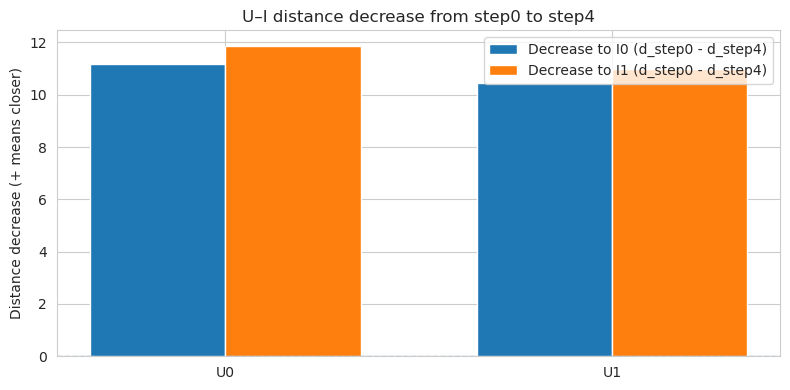


Saved plot -> /home/parkdw00/Codes/A-LLMRec/books_results/figs_tsne_cluster_progress/p0_to_p4_U_to_I_distance_decrease.png


In [38]:
csv_path = f"{BASE_DIR}/figs_tsne_cluster_progress/step4_center_distances_over_steps_RAW_ONLY.csv"

df = pd.read_csv(csv_path)

# step0, step4가 정확히 있는지 확인 (없으면 가장 작은/큰 step 사용)
step_min = int(df["step"].min())
step_max = int(df["step"].max())

# 네가 원하는 게 step0/step4 고정이면 아래 두 줄을 쓰고,
# CSV에 없으면 KeyError/빈결과 날 수 있음.
s0 = 0
s4 = 4
if not ((df["step"] == s0).any() and (df["step"] == s4).any()):
    print(f"[warn] step {s0}/{s4}가 CSV에 없어서 {step_min}/{step_max}로 대체합니다.")
    s0, s4 = step_min, step_max

row0 = df.loc[df["step"] == s0].iloc[0]
row4 = df.loc[df["step"] == s4].iloc[0]

pairs = [
    ("U0", "I0", "ui_raw_U0_I0"),
    ("U0", "I1", "ui_raw_U0_I1"),
    ("U1", "I0", "ui_raw_U1_I0"),
    ("U1", "I1", "ui_raw_U1_I1"),
]

results = []
for u, i, col in pairs:
    d0 = float(row0[col])
    d4 = float(row4[col])
    dec = d0 - d4   # +면 가까워짐, -면 멀어짐
    results.append({"U": u, "I": i, "d_step0": d0, "d_step4": d4, "decrease": dec})

res = pd.DataFrame(results)

# U별 요약: I0/I1 감소량 비교 및 "I0쪽으로 더 가까워졌는지" 판단
summary_rows = []
for u in ["U0", "U1"]:
    dec_i0 = float(res[(res["U"] == u) & (res["I"] == "I0")]["decrease"].iloc[0])
    dec_i1 = float(res[(res["U"] == u) & (res["I"] == "I1")]["decrease"].iloc[0])
    # 감소량 차이(양수면 I0쪽으로 더 가까워짐)
    diff = dec_i0 - dec_i1
    summary_rows.append({
        "U": u,
        "step_start": s0,
        "step_end": s4,
        "decrease_to_I0": dec_i0,
        "decrease_to_I1": dec_i1,
        "diff(I0_minus_I1)": diff,
        "moved_more_toward": "I0" if diff > 0 else ("I1" if diff < 0 else "Same")
    })

summary = pd.DataFrame(summary_rows)

print("\n[raw distances + decreases]")
print(res.to_string(index=False))

print("\n[summary: compare decreases]")
print(summary.to_string(index=False))

# ---------------------------
# Visualization
# - U0, U1 각각에서 (I0 감소량, I1 감소량) 막대 비교
# ---------------------------
fig, ax = plt.subplots(figsize=(8, 4))

x = np.arange(2)  # U0, U1
width = 0.35

dec_i0s = summary["decrease_to_I0"].values
dec_i1s = summary["decrease_to_I1"].values

ax.bar(x - width/2, dec_i0s, width, label="Decrease to I0 (d_step0 - d_step4)")
ax.bar(x + width/2, dec_i1s, width, label="Decrease to I1 (d_step0 - d_step4)")

ax.set_xticks(x)
ax.set_xticklabels(summary["U"].values)
ax.set_ylabel("Distance decrease (+ means closer)")
ax.set_title(f"U–I distance decrease from step{s0} to step{s4}")
ax.axhline(0, linestyle="--", linewidth=1, alpha=0.6)
ax.legend()

plt.tight_layout()

out_png = os.path.join(os.path.dirname(csv_path), f"p{s0}_to_p{s4}_U_to_I_distance_decrease.png")
plt.savefig(out_png, dpi=220)
plt.show()

print("\nSaved plot ->", out_png)
